In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


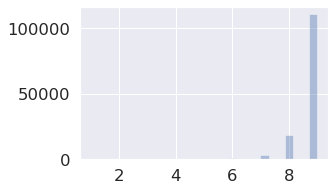

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  503


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

2936777
preprocess.0.linear.weight torch.Size([280, 39])
preprocess.0.linear.bias torch.Size([280])
preprocess.0.bn.weight torch.Size([280])
preprocess.0.bn.bias torch.Size([280])
encoder.0.linear.weight torch.Size([280, 49])
encoder.0.linear.bias torch.Size([280])
encoder.0.bn.weight torch.Size([280])
encoder.0.bn.bias torch.Size([280])
align.weight torch.Size([1, 560])
align.bias torch.Size([1])
attend.linear.weight torch.Size([280, 280])
attend.linear.bias torch.Size([280])
attend.bn.weight torch.Size([280])
attend.bn.bias torch.Size([280])
gru.weight_ih torch.Size([840, 280])
gru.weight_hh torch.Size([840, 280])
gru.bias_ih torch.Size([840])
gru.bias_hh torch.Size([840])
propagate.0.align.weight torch.Size([1, 560])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([280, 280])
propagate.0.attend.linear.bias torch.Size([280])
propagate.0.attend.bn.weight torch.Size([280])
propagate.0.attend.bn.bias torch.Size([280])
propagate.0.gru.weight_ih torch.Si

In [11]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)


def eval(model, smiles_list):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]

            MAE = F.l1_loss(y_pred, label[:,i], reduction='none')        
            MSE = F.mse_loss(y_pred, label[:,i], reduction='none')
        
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], label[:,i].cpu().detach().numpy()])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized, np.array(std_list))
    eval_RMSE_normalized = np.sqrt(np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)]))
    eval_RMSE = np.multiply(eval_RMSE_normalized, np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_RMSE_normalized, eval_RMSE #, r2_score_list



In [12]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 800
best_param["valid_MSE_normalized"] = 800
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


212it [00:13, 17.19it/s]
212it [00:06, 32.93it/s]
27it [00:00, 36.59it/s]

EPOCH:	0 0.5741046395785404
train_MAE:
[7.80952222e-01 1.12073762e+00 8.46123282e-03 1.02877599e-02
 1.21683914e-02 5.72127470e+01 3.52494737e-03 4.63936317e+00
 5.73090726e+00 4.21646704e+00 6.02094474e+00 4.92395756e-01]
valid_MAE:
[7.70853665e-01 1.11977503e+00 8.40171382e-03 1.03908082e-02
 1.22586156e-02 5.75629112e+01 3.55284435e-03 4.66221160e+00
 5.75291295e+00 4.25719786e+00 6.03782636e+00 4.95980876e-01]
train_MSE_normalized_mean: 0.26799243955858243
valid_MSE_normalized_mean: 0.2651108161869623




212it [00:12, 18.66it/s]
212it [00:05, 41.65it/s]
27it [00:00, 39.70it/s]

EPOCH:	1 0.3262166417432281
train_MAE:
[7.31423440e-01 9.89267326e-01 7.84097631e-03 8.64271462e-03
 1.14556773e-02 5.23075990e+01 3.42764807e-03 4.45778814e+00
 4.13343212e+00 3.67996696e+00 4.23569510e+00 4.71041697e-01]
valid_MAE:
[7.25193167e-01 9.94689266e-01 7.85667610e-03 8.65433334e-03
 1.15023685e-02 5.23983255e+01 3.45291136e-03 4.49149911e+00
 4.17079414e+00 3.72138279e+00 4.26902961e+00 4.73477199e-01]
train_MSE_normalized_mean: 0.241450608794145
valid_MSE_normalized_mean: 0.24060332507000695




212it [00:12, 16.85it/s]
212it [00:05, 38.43it/s]
27it [00:00, 31.61it/s]

EPOCH:	2 0.2822828577515089
train_MAE:
[7.01136774e-01 1.05047451e+00 6.92883274e-03 8.92656063e-03
 1.13354606e-02 5.04410043e+01 4.47769648e-03 4.84097985e+00
 4.61278041e+00 4.68237546e+00 4.52706504e+00 5.11670917e-01]
valid_MAE:
[6.95206046e-01 1.05679040e+00 6.92628076e-03 8.91097201e-03
 1.13689986e-02 5.08531401e+01 4.50403555e-03 4.80804763e+00
 4.57565575e+00 4.65084724e+00 4.49439965e+00 5.12688617e-01]
train_MSE_normalized_mean: 0.24176211346700807
valid_MSE_normalized_mean: 0.24052606080271524




212it [00:12, 18.55it/s]
212it [00:06, 32.64it/s]
27it [00:00, 29.78it/s]

EPOCH:	3 0.26371901658064917
train_MAE:
[7.09742555e-01 1.59990263e+00 6.63967232e-03 1.02388508e-02
 1.21940670e-02 5.19853923e+01 5.31376656e-03 1.83393504e+00
 1.76084613e+00 1.80753957e+00 1.78422363e+00 6.61668728e-01]
valid_MAE:
[7.05117458e-01 1.59741567e+00 6.64968206e-03 1.02023842e-02
 1.22210959e-02 5.23630594e+01 5.32990299e-03 1.82547406e+00
 1.75234693e+00 1.80003103e+00 1.77630294e+00 6.61073947e-01]
train_MSE_normalized_mean: 0.22816013573950145
valid_MSE_normalized_mean: 0.22741808235038427




212it [00:13, 15.35it/s]
212it [00:05, 36.26it/s]
27it [00:00, 30.67it/s]

EPOCH:	4 0.2508669213725711
train_MAE:
[6.69326106e-01 1.07101302e+00 6.58195308e-03 8.35834133e-03
 1.05644588e-02 4.53627054e+01 2.55039815e-03 2.62177651e+00
 2.62850817e+00 2.58761370e+00 2.51773933e+00 4.38516859e-01]
valid_MAE:
[6.62925306e-01 1.07217018e+00 6.59666058e-03 8.36768878e-03
 1.06545979e-02 4.58216425e+01 2.55478975e-03 2.63012623e+00
 2.63812298e+00 2.60180687e+00 2.53029152e+00 4.39399612e-01]
train_MSE_normalized_mean: 0.20755883365479041
valid_MSE_normalized_mean: 0.20710888551584739




212it [00:12, 19.44it/s]
212it [00:05, 36.51it/s]
27it [00:00, 29.67it/s]

EPOCH:	5 0.24450787894849507
train_MAE:
[6.70877981e-01 7.76137823e-01 6.41098875e-03 8.17705809e-03
 9.77101910e-03 4.74556789e+01 2.49996242e-03 1.67854947e+00
 1.66470762e+00 1.68790512e+00 1.70409897e+00 4.10959645e-01]
valid_MAE:
[6.67624161e-01 7.79648813e-01 6.41602318e-03 8.17451242e-03
 9.82302709e-03 4.78259461e+01 2.51730341e-03 1.68265067e+00
 1.66911531e+00 1.69009550e+00 1.70619286e+00 4.10808601e-01]
train_MSE_normalized_mean: 0.19408631307197133
valid_MSE_normalized_mean: 0.1932981304691693




212it [00:12, 17.84it/s]
212it [00:06, 35.30it/s]
27it [00:00, 29.19it/s]

EPOCH:	6 0.23503148344890126
train_MAE:
[6.66983565e-01 8.78265831e-01 6.18299578e-03 7.57901698e-03
 9.73672237e-03 4.38674380e+01 2.42974560e-03 2.82676668e+00
 2.83536183e+00 2.81393144e+00 2.79374424e+00 5.70206183e-01]
valid_MAE:
[6.60529136e-01 8.82626340e-01 6.23764362e-03 7.52689353e-03
 9.78529232e-03 4.39606928e+01 2.42800362e-03 2.84136588e+00
 2.84937685e+00 2.82942387e+00 2.80886946e+00 5.72457755e-01]
train_MSE_normalized_mean: 0.20365499741463353
valid_MSE_normalized_mean: 0.20317168113100645




212it [00:12, 18.40it/s]
212it [00:06, 34.93it/s]
27it [00:00, 35.53it/s]

EPOCH:	7 0.22725549059094124
train_MAE:
[6.75045238e-01 7.44035983e-01 6.01695315e-03 7.11137779e-03
 8.88837673e-03 4.58956941e+01 1.96687345e-03 3.07188768e+00
 3.03748551e+00 3.03031065e+00 3.02658631e+00 3.85155435e-01]
valid_MAE:
[6.72869415e-01 7.43868182e-01 6.04326617e-03 7.12854548e-03
 8.95480059e-03 4.60408231e+01 1.98307117e-03 3.06834996e+00
 3.03383463e+00 3.02797994e+00 3.02418192e+00 3.86332070e-01]
train_MSE_normalized_mean: 0.19298939242398935
valid_MSE_normalized_mean: 0.19237793671911207




212it [00:12, 16.43it/s]
212it [00:06, 39.62it/s]
27it [00:00, 31.71it/s]

EPOCH:	8 0.22097734375944678
train_MAE:
[6.25446074e-01 6.98161716e-01 5.89997709e-03 6.92864151e-03
 8.88695367e-03 4.10989327e+01 2.43010274e-03 1.22775718e+00
 1.23210861e+00 1.24756441e+00 1.23969491e+00 4.23705970e-01]
valid_MAE:
[6.26628460e-01 7.00697971e-01 5.97290277e-03 6.92746598e-03
 8.95210170e-03 4.15069722e+01 2.45353387e-03 1.22607986e+00
 1.23055600e+00 1.24633127e+00 1.23865081e+00 4.25131191e-01]
train_MSE_normalized_mean: 0.17447145983048193
valid_MSE_normalized_mean: 0.1746965249577571




212it [00:13, 15.81it/s]
212it [00:06, 37.86it/s]
27it [00:00, 32.46it/s]

EPOCH:	9 0.21548862987250653
train_MAE:
[6.08181770e-01 7.74604006e-01 5.98711341e-03 7.80762154e-03
 8.84014839e-03 4.22277077e+01 1.93995930e-03 2.17415907e+00
 2.18115690e+00 2.16429396e+00 2.16590706e+00 4.09764003e-01]
valid_MAE:
[6.11320802e-01 7.80533091e-01 6.08175047e-03 7.83737681e-03
 8.91593696e-03 4.26759333e+01 1.97340949e-03 2.20129205e+00
 2.20827713e+00 2.19164287e+00 2.19322808e+00 4.09813929e-01]
train_MSE_normalized_mean: 0.18345803902207636
valid_MSE_normalized_mean: 0.1843323255510071




212it [00:12, 16.34it/s]
212it [00:05, 35.33it/s]
27it [00:00, 36.13it/s]

EPOCH:	10 0.21076815715938244
train_MAE:
[5.98948520e-01 9.75153129e-01 6.10090353e-03 7.14571452e-03
 8.29053094e-03 4.54987110e+01 3.06076108e-03 2.48588048e+00
 2.48280922e+00 2.46496057e+00 2.46865973e+00 5.34201574e-01]
valid_MAE:
[6.00059062e-01 9.75865179e-01 6.12461750e-03 7.09613193e-03
 8.33595922e-03 4.58240336e+01 3.07099148e-03 2.47076753e+00
 2.46773709e+00 2.45129698e+00 2.45494869e+00 5.34419643e-01]
train_MSE_normalized_mean: 0.18964603547714912
valid_MSE_normalized_mean: 0.1898812902532352




212it [00:12, 16.40it/s]
212it [00:05, 36.17it/s]
27it [00:00, 34.21it/s]

EPOCH:	11 0.20738924688325738
train_MAE:
[5.97103064e-01 9.50031204e-01 5.58265406e-03 7.03016256e-03
 8.51188664e-03 4.62394463e+01 2.35865662e-03 3.18379005e+00
 3.17664357e+00 3.14252556e+00 3.14493915e+00 5.21884390e-01]
valid_MAE:
[5.98974624e-01 9.50249007e-01 5.62343138e-03 7.02264988e-03
 8.64800776e-03 4.65382364e+01 2.37897291e-03 3.19793254e+00
 3.19070899e+00 3.15718010e+00 3.15946784e+00 5.25682983e-01]
train_MSE_normalized_mean: 0.19345545038539483
valid_MSE_normalized_mean: 0.19455704527742523




212it [00:13, 16.29it/s]
212it [00:05, 37.07it/s]
27it [00:00, 33.13it/s]

EPOCH:	12 0.20286077738932842
train_MAE:
[6.00733958e-01 6.34071924e-01 5.51755801e-03 6.25889127e-03
 8.13082588e-03 3.83997107e+01 2.70333177e-03 1.99963350e+00
 2.00489069e+00 2.02652181e+00 2.02258323e+00 3.60561769e-01]
valid_MAE:
[6.05860384e-01 6.41027666e-01 5.61691069e-03 6.26358268e-03
 8.24944132e-03 3.89534846e+01 2.71994962e-03 1.99655414e+00
 2.00154988e+00 2.02180712e+00 2.01808240e+00 3.62514941e-01]
train_MSE_normalized_mean: 0.17125900428868515
valid_MSE_normalized_mean: 0.17228722065990984




212it [00:13, 17.87it/s]
212it [00:06, 31.87it/s]
27it [00:00, 27.80it/s]

EPOCH:	13 0.19892747580723943
train_MAE:
[5.95221793e-01 7.00956176e-01 5.79726381e-03 5.89582366e-03
 8.13065949e-03 3.76753452e+01 2.04346087e-03 1.18969425e+00
 1.19294419e+00 1.20208811e+00 1.20053280e+00 3.43514310e-01]
valid_MAE:
[5.97496667e-01 6.98836467e-01 5.89653446e-03 5.86883224e-03
 8.23630257e-03 3.81810371e+01 2.05165918e-03 1.19671207e+00
 1.19993198e+00 1.20898864e+00 1.20749113e+00 3.46458007e-01]
train_MSE_normalized_mean: 0.16132089125782126
valid_MSE_normalized_mean: 0.16224771847076672




212it [00:13, 17.90it/s]
212it [00:05, 35.03it/s]
27it [00:00, 18.39it/s]

EPOCH:	14 0.19602489190281563
train_MAE:
[5.82999860e-01 7.54531388e-01 5.34014665e-03 6.90020806e-03
 8.06605845e-03 3.76875593e+01 2.22447465e-03 2.78878015e+00
 2.78575380e+00 2.76466921e+00 2.76811268e+00 3.57493403e-01]
valid_MAE:
[5.85941117e-01 7.58618008e-01 5.45942687e-03 6.90387714e-03
 8.16302477e-03 3.83473903e+01 2.24726772e-03 2.79519049e+00
 2.79229305e+00 2.77217684e+00 2.77553880e+00 3.58955013e-01]
train_MSE_normalized_mean: 0.17523014216583796
valid_MSE_normalized_mean: 0.1765937888833142




212it [00:12, 16.45it/s]
212it [00:05, 39.16it/s]
27it [00:00, 32.90it/s]

EPOCH:	15 0.19312039172311998
train_MAE:
[5.82989872e-01 6.35999110e-01 5.22441887e-03 6.28712533e-03
 7.94850719e-03 3.93403150e+01 2.05861662e-03 2.04815633e+00
 2.04615157e+00 2.03590902e+00 2.03644772e+00 3.85948973e-01]
valid_MAE:
[5.87220452e-01 6.48749493e-01 5.34268035e-03 6.26065710e-03
 8.07492692e-03 4.00598100e+01 2.07361319e-03 2.04815954e+00
 2.04629167e+00 2.03712442e+00 2.03756423e+00 3.88616240e-01]
train_MSE_normalized_mean: 0.1681440972330659
valid_MSE_normalized_mean: 0.16990303824257544




212it [00:13, 16.17it/s]
212it [00:05, 40.92it/s]
27it [00:00, 32.03it/s]

EPOCH:	16 0.19116627242205278
train_MAE:
[5.75178007e-01 6.59257133e-01 5.35992878e-03 6.03980171e-03
 7.72180839e-03 4.24055796e+01 1.91174933e-03 1.10344629e+00
 1.10295847e+00 1.10238506e+00 1.10211918e+00 3.04125032e-01]
valid_MAE:
[5.76766107e-01 6.65401425e-01 5.48801887e-03 6.04774908e-03
 7.87058638e-03 4.32548972e+01 1.91367645e-03 1.10799669e+00
 1.10741979e+00 1.10589367e+00 1.10569841e+00 3.05823035e-01]
train_MSE_normalized_mean: 0.15642266450028533
valid_MSE_normalized_mean: 0.15816299123156147




212it [00:13, 18.37it/s]
212it [00:05, 39.65it/s]
27it [00:00, 28.39it/s]

EPOCH:	17 0.18814633519582027
train_MAE:
[5.56501998e-01 6.52416549e-01 5.30154634e-03 5.76606483e-03
 7.64842242e-03 3.90485807e+01 1.66996347e-03 1.70710360e+00
 1.70847957e+00 1.71618053e+00 1.71566257e+00 3.51162161e-01]
valid_MAE:
[5.63047344e-01 6.60503633e-01 5.42756746e-03 5.79548205e-03
 7.81071522e-03 3.97311958e+01 1.67723941e-03 1.71694610e+00
 1.71824274e+00 1.72585181e+00 1.72534137e+00 3.55636962e-01]
train_MSE_normalized_mean: 0.1597997624846733
valid_MSE_normalized_mean: 0.16197148410803117




212it [00:13, 17.71it/s]
212it [00:05, 36.17it/s]
27it [00:01, 26.55it/s]

EPOCH:	18 0.18518880129141627
train_MAE:
[5.53054338e-01 8.38467885e-01 5.05243854e-03 5.82483783e-03
 7.40969629e-03 3.87600816e+01 2.30340950e-03 1.67068342e+00
 1.67000241e+00 1.65963234e+00 1.66101191e+00 4.03950028e-01]
valid_MAE:
[5.61152698e-01 8.41221067e-01 5.20875750e-03 5.86380714e-03
 7.53559629e-03 3.95504769e+01 2.31754417e-03 1.67630273e+00
 1.67566955e+00 1.66569537e+00 1.66701760e+00 4.04324925e-01]
train_MSE_normalized_mean: 0.1620064749678167
valid_MSE_normalized_mean: 0.16476611251652098




212it [00:12, 16.41it/s]
212it [00:06, 34.34it/s]
27it [00:00, 35.48it/s]

EPOCH:	19 0.184075533992277
train_MAE:
[5.47795579e-01 6.64830802e-01 4.90349697e-03 6.09062572e-03
 7.65904629e-03 3.46599136e+01 1.83431315e-03 3.09045866e+00
 3.09267009e+00 3.10172717e+00 3.10121621e+00 3.03340729e-01]
valid_MAE:
[5.56247916e-01 6.68140014e-01 5.03155956e-03 6.10948767e-03
 7.80380058e-03 3.53740819e+01 1.83725667e-03 3.09306432e+00
 3.09521674e+00 3.10376975e+00 3.10330937e+00 3.04374858e-01]
train_MSE_normalized_mean: 0.1658201958855712
valid_MSE_normalized_mean: 0.16821958762662234




212it [00:12, 17.94it/s]
212it [00:07, 29.58it/s]
27it [00:01, 25.71it/s]

EPOCH:	20 0.18065060871951985
train_MAE:
[5.46182806e-01 8.05748156e-01 5.24173568e-03 6.03663821e-03
 7.67018656e-03 3.75477060e+01 2.12142668e-03 1.55229591e+00
 1.55083443e+00 1.54557914e+00 1.54630903e+00 3.57956795e-01]
valid_MAE:
[5.56157802e-01 8.14248591e-01 5.38361814e-03 6.10890890e-03
 7.86330377e-03 3.82024948e+01 2.16450584e-03 1.56838921e+00
 1.56689281e+00 1.56146678e+00 1.56220892e+00 3.61577590e-01]
train_MSE_normalized_mean: 0.159429131552055
valid_MSE_normalized_mean: 0.16263077164110676




212it [00:13, 16.02it/s]
212it [00:06, 33.43it/s]
27it [00:00, 35.80it/s]

EPOCH:	21 0.1790116975470534
train_MAE:
[5.35580504e-01 9.42156979e-01 4.87420342e-03 5.77474215e-03
 7.57287551e-03 3.98188235e+01 1.56612779e-03 1.21705667e+00
 1.21713971e+00 1.21917280e+00 1.21881034e+00 3.50585994e-01]
valid_MAE:
[5.47612300e-01 9.48848781e-01 5.03380870e-03 5.83805289e-03
 7.73153763e-03 4.03445749e+01 1.56829749e-03 1.24103400e+00
 1.24108508e+00 1.24300643e+00 1.24264513e+00 3.54979717e-01]
train_MSE_normalized_mean: 0.153540837351821
valid_MSE_normalized_mean: 0.15661450252501305




212it [00:12, 16.18it/s]
212it [00:06, 38.84it/s]
27it [00:00, 33.86it/s]

EPOCH:	22 0.17801823199919933
train_MAE:
[5.30140916e-01 6.66645260e-01 4.89424230e-03 5.53939028e-03
 7.07343804e-03 4.24882089e+01 2.21714909e-03 1.54162612e+00
 1.54251610e+00 1.54641428e+00 1.54652138e+00 4.38756371e-01]
valid_MAE:
[5.40525886e-01 6.75909471e-01 5.04104662e-03 5.54546259e-03
 7.19383423e-03 4.37266460e+01 2.21984726e-03 1.55707027e+00
 1.55797582e+00 1.56201547e+00 1.56211063e+00 4.37563712e-01]
train_MSE_normalized_mean: 0.1572024743961993
valid_MSE_normalized_mean: 0.16013805726000954




212it [00:13, 17.21it/s]
212it [00:06, 32.77it/s]
27it [00:00, 23.99it/s]

EPOCH:	23 0.17456416209351341
train_MAE:
[5.37121692e-01 7.47945956e-01 4.82213171e-03 6.29066097e-03
 7.37555957e-03 3.81551265e+01 2.68789117e-03 2.81552081e+00
 2.81423717e+00 2.80678239e+00 2.80728652e+00 4.47280096e-01]
valid_MAE:
[5.53343932e-01 7.54301194e-01 4.95872948e-03 6.38813245e-03
 7.58269259e-03 3.86921089e+01 2.71244362e-03 2.84279218e+00
 2.84148101e+00 2.83384016e+00 2.83436284e+00 4.52808559e-01]
train_MSE_normalized_mean: 0.17277741211510755
valid_MSE_normalized_mean: 0.1765951232725671




212it [00:13, 19.30it/s]
212it [00:05, 43.89it/s]
27it [00:00, 31.24it/s]

EPOCH:	24 0.17362794097302095
train_MAE:
[5.28935839e-01 8.40133077e-01 4.78978455e-03 6.81217221e-03
 7.75863858e-03 3.86817959e+01 2.68157646e-03 3.91589143e+00
 3.91454607e+00 3.90429760e+00 3.90533401e+00 3.82189521e-01]
valid_MAE:
[5.44880349e-01 8.46713014e-01 4.99268303e-03 6.92741598e-03
 7.95669397e-03 3.94139348e+01 2.69604184e-03 3.94995303e+00
 3.94861712e+00 3.93845206e+00 3.93947202e+00 3.88397185e-01]
train_MSE_normalized_mean: 0.18025280202250651
valid_MSE_normalized_mean: 0.18457135075069675




212it [00:13, 16.04it/s]
212it [00:05, 36.72it/s]
27it [00:00, 29.84it/s]

EPOCH:	25 0.1728636589393301
train_MAE:
[5.33383975e-01 7.00027167e-01 4.77537147e-03 5.72496078e-03
 7.17943519e-03 3.54461246e+01 1.90188239e-03 5.71047740e+00
 5.70973867e+00 5.70430277e+00 5.70506445e+00 3.54470595e-01]
valid_MAE:
[5.46796564e-01 7.08062784e-01 4.96132231e-03 5.82363299e-03
 7.40622666e-03 3.61277353e+01 1.91017247e-03 5.70975270e+00
 5.70905138e+00 5.70387001e+00 5.70460445e+00 3.59055115e-01]
train_MSE_normalized_mean: 0.18548197010071651
valid_MSE_normalized_mean: 0.1890724300955793




212it [00:12, 16.37it/s]
212it [00:05, 37.22it/s]
27it [00:00, 33.45it/s]

EPOCH:	26 0.17080599491326315
train_MAE:
[5.22356621e-01 7.89754994e-01 4.65247773e-03 5.45489236e-03
 6.79233620e-03 4.20756220e+01 2.68542537e-03 1.91212675e+00
 1.91148984e+00 1.90889602e+00 1.90963306e+00 4.88881505e-01]
valid_MAE:
[5.38239777e-01 7.95826274e-01 4.82227444e-03 5.54486143e-03
 7.04984719e-03 4.26363986e+01 2.69464951e-03 1.92975513e+00
 1.92915230e+00 1.92678702e+00 1.92749585e+00 4.90860305e-01]
train_MSE_normalized_mean: 0.15933848701338071
valid_MSE_normalized_mean: 0.1633576878562312




212it [00:12, 18.37it/s]
212it [00:05, 38.05it/s]
27it [00:00, 33.82it/s]

EPOCH:	27 0.1676334617132286
train_MAE:
[5.10617648e-01 6.34063926e-01 4.80344859e-03 6.21514653e-03
 7.68105755e-03 3.57262588e+01 2.54368556e-03 1.58174561e+00
 1.58143452e+00 1.58003146e+00 1.58020582e+00 3.40100852e-01]
valid_MAE:
[5.29034534e-01 6.41472415e-01 4.97445044e-03 6.31556700e-03
 7.92056525e-03 3.65982686e+01 2.56174089e-03 1.59932867e+00
 1.59900760e+00 1.59751590e+00 1.59769077e+00 3.43763539e-01]
train_MSE_normalized_mean: 0.15281740530709156
valid_MSE_normalized_mean: 0.1575910854066769




212it [00:13, 15.76it/s]
212it [00:05, 36.59it/s]
27it [00:00, 27.60it/s]

EPOCH:	28 0.1683268203347359
train_MAE:
[5.14500404e-01 6.25422138e-01 4.73766030e-03 5.47836676e-03
 7.28126293e-03 3.54903724e+01 2.13432779e-03 4.69470778e+00
 4.69462642e+00 4.69287882e+00 4.69308257e+00 2.96649531e-01]
valid_MAE:
[5.35365253e-01 6.36940517e-01 4.92429536e-03 5.63958940e-03
 7.53496166e-03 3.66601346e+01 2.14866602e-03 4.69594108e+00
 4.69588003e+00 4.69425612e+00 4.69443923e+00 3.00340756e-01]
train_MSE_normalized_mean: 0.1730450302116153
valid_MSE_normalized_mean: 0.1778012012211391




212it [00:13, 16.96it/s]
212it [00:05, 38.43it/s]
27it [00:00, 30.89it/s]

EPOCH:	29 0.16549436009998592
train_MAE:
[4.98951595e-01 1.31883052e+00 4.41705683e-03 5.26790917e-03
 6.69516856e-03 5.04644037e+01 4.59535978e-03 2.57784948e+00
 2.57787348e+00 2.58012038e+00 2.58041577e+00 6.70889582e-01]
valid_MAE:
[5.21124393e-01 1.32901866e+00 4.64313918e-03 5.35023836e-03
 6.89761943e-03 5.20564575e+01 4.60252229e-03 2.58324037e+00
 2.58324229e+00 2.58534629e+00 2.58566431e+00 6.73674720e-01]
train_MSE_normalized_mean: 0.17647465048845853
valid_MSE_normalized_mean: 0.18181256017202985




212it [00:13, 15.84it/s]
212it [00:06, 34.75it/s]
27it [00:00, 28.62it/s]

EPOCH:	30 0.16447280579299298
train_MAE:
[5.05017323e-01 7.48658353e-01 4.57054342e-03 5.34950861e-03
 6.76154213e-03 3.57630641e+01 2.15381837e-03 1.83139616e+00
 1.83146196e+00 1.83192134e+00 1.83187407e+00 4.19194974e-01]
valid_MAE:
[5.27095988e-01 7.54263104e-01 4.81042946e-03 5.48088435e-03
 7.06241324e-03 3.67216948e+01 2.17189515e-03 1.83376650e+00
 1.83379048e+00 1.83402886e+00 1.83401699e+00 4.22615105e-01]
train_MSE_normalized_mean: 0.15185465169673687
valid_MSE_normalized_mean: 0.15737466887525317




212it [00:12, 16.36it/s]
212it [00:06, 35.21it/s]
27it [00:00, 22.95it/s]

EPOCH:	31 0.16361478392807943
train_MAE:
[4.93329865e-01 6.03403082e-01 4.43375131e-03 5.15746169e-03
 6.89096471e-03 3.33913956e+01 2.34122802e-03 1.30663201e+00
 1.30684929e+00 1.30831971e+00 1.30819285e+00 3.71879196e-01]
valid_MAE:
[5.17275429e-01 6.15220665e-01 4.64091871e-03 5.30424537e-03
 7.09994563e-03 3.47796161e+01 2.34902264e-03 1.31325838e+00
 1.31344793e+00 1.31474153e+00 1.31463157e+00 3.72586289e-01]
train_MSE_normalized_mean: 0.14275791139129318
valid_MSE_normalized_mean: 0.14849516111238753




212it [00:12, 16.65it/s]
212it [00:06, 34.09it/s]
27it [00:00, 29.92it/s]

EPOCH:	32 0.16060468498265967
train_MAE:
[4.86679296e-01 5.81138743e-01 4.35317566e-03 5.31277962e-03
 6.84113158e-03 3.23174075e+01 1.57774732e-03 1.25277036e+00
 1.25312051e+00 1.25538578e+00 1.25528180e+00 2.78252041e-01]
valid_MAE:
[5.09432007e-01 5.96420562e-01 4.60677154e-03 5.39637971e-03
 7.10507867e-03 3.36880547e+01 1.58584355e-03 1.26449548e+00
 1.26483281e+00 1.26704065e+00 1.26695975e+00 2.82409414e-01]
train_MSE_normalized_mean: 0.1364851184998942
valid_MSE_normalized_mean: 0.14286276397249953




212it [00:13, 16.11it/s]
212it [00:07, 29.20it/s]
27it [00:00, 28.15it/s]

EPOCH:	33 0.16095396721700453
train_MAE:
[5.06635292e-01 5.87354615e-01 4.38834014e-03 4.98246697e-03
 6.48366095e-03 3.26751106e+01 2.20969187e-03 1.05792433e+00
 1.05765275e+00 1.05586042e+00 1.05598362e+00 3.05702889e-01]
valid_MAE:
[5.28188872e-01 5.99115396e-01 4.63457458e-03 5.09079523e-03
 6.76883989e-03 3.38774526e+01 2.21381215e-03 1.07759353e+00
 1.07733100e+00 1.07559275e+00 1.07571463e+00 3.06861743e-01]
train_MSE_normalized_mean: 0.13796595017409288
valid_MSE_normalized_mean: 0.14371310559518582




212it [00:13, 15.79it/s]
212it [00:06, 32.24it/s]
27it [00:00, 29.89it/s]

EPOCH:	34 0.15885465662434417
train_MAE:
[5.03839598e-01 7.25115741e-01 4.43509642e-03 5.17633319e-03
 6.51535221e-03 3.30158202e+01 2.02553656e-03 1.15843031e+00
 1.15841022e+00 1.15825196e+00 1.15822587e+00 3.42525786e-01]
valid_MAE:
[5.27585338e-01 7.37531270e-01 4.67976281e-03 5.32224063e-03
 6.83485836e-03 3.42271473e+01 2.02891290e-03 1.17903409e+00
 1.17900252e+00 1.17879188e+00 1.17878095e+00 3.46242633e-01]
train_MSE_normalized_mean: 0.14102333875175088
valid_MSE_normalized_mean: 0.14774912544568564




212it [00:13, 16.09it/s]
212it [00:06, 33.07it/s]
27it [00:00, 31.95it/s]

EPOCH:	35 0.15742967305880673
train_MAE:
[4.83164160e-01 6.78428125e-01 4.57673468e-03 5.19283262e-03
 6.48480698e-03 3.40515932e+01 1.93455934e-03 1.84742911e+00
 1.84727930e+00 1.84660659e+00 1.84674448e+00 3.17660604e-01]
valid_MAE:
[5.10898521e-01 6.90999490e-01 4.84051163e-03 5.34236372e-03
 6.84103376e-03 3.54708549e+01 1.93516943e-03 1.85488668e+00
 1.85473251e+00 1.85404138e+00 1.85418272e+00 3.21933744e-01]
train_MSE_normalized_mean: 0.14453588425475924
valid_MSE_normalized_mean: 0.15131507109484482




212it [00:13, 15.74it/s]
212it [00:06, 34.21it/s]
27it [00:00, 29.12it/s]

EPOCH:	36 0.15755975640045022
train_MAE:
[4.79898742e-01 6.22315822e-01 4.21433110e-03 6.33146777e-03
 7.30117084e-03 3.09409676e+01 2.74354353e-03 4.75888863e+00
 4.75897592e+00 4.75945858e+00 4.75947494e+00 2.81387849e-01]
valid_MAE:
[5.07503687e-01 6.32763324e-01 4.49441816e-03 6.37259208e-03
 7.58341704e-03 3.25967911e+01 2.76391895e-03 4.76734399e+00
 4.76742513e+00 4.76786578e+00 4.76789169e+00 2.85711718e-01]
train_MSE_normalized_mean: 0.16916241729184164
valid_MSE_normalized_mean: 0.17625159815868918




212it [00:16, 13.07it/s]
212it [00:06, 32.61it/s]
27it [00:00, 28.43it/s]

EPOCH:	37 0.15527907604316496
train_MAE:
[4.78489104e-01 6.46986735e-01 4.42021655e-03 5.72921480e-03
 6.72713669e-03 3.71785693e+01 2.13308176e-03 4.04411525e+00
 4.04382879e+00 4.04255655e+00 4.04295409e+00 3.50050013e-01]
valid_MAE:
[5.07645890e-01 6.57078232e-01 4.68184404e-03 5.85847363e-03
 7.07380476e-03 3.83061857e+01 2.13182962e-03 4.05165073e+00
 4.05136972e+00 4.05012425e+00 4.05050980e+00 3.55299709e-01]
train_MSE_normalized_mean: 0.16451206960050216
valid_MSE_normalized_mean: 0.17116732757945805




212it [00:13, 15.90it/s]
212it [00:05, 35.69it/s]
27it [00:00, 27.13it/s]

EPOCH:	38 0.15423801112568603
train_MAE:
[4.82564882e-01 5.89257928e-01 4.22716874e-03 5.09851562e-03
 6.56999601e-03 3.43069630e+01 1.41298692e-03 1.52085054e+00
 1.52088629e+00 1.52127696e+00 1.52129887e+00 2.91240480e-01]
valid_MAE:
[5.14560969e-01 5.99636552e-01 4.52554716e-03 5.22142847e-03
 6.90030763e-03 3.57436070e+01 1.41954488e-03 1.51758065e+00
 1.51760743e+00 1.51793854e+00 1.51796519e+00 2.96376768e-01]
train_MSE_normalized_mean: 0.13660826933888162
valid_MSE_normalized_mean: 0.14409182781265287




212it [00:13, 18.64it/s]
212it [00:06, 35.13it/s]
27it [00:01, 20.79it/s]

EPOCH:	39 0.15401941741693695
train_MAE:
[4.76500536e-01 7.01708564e-01 4.33018488e-03 5.40381586e-03
 6.65420044e-03 3.57416613e+01 1.85139039e-03 1.61762396e+00
 1.61765286e+00 1.61783618e+00 1.61779716e+00 3.25850698e-01]
valid_MAE:
[5.07366899e-01 7.12055763e-01 4.63668292e-03 5.57108084e-03
 7.05413809e-03 3.70712921e+01 1.87335275e-03 1.62846815e+00
 1.62848806e+00 1.62863408e+00 1.62860994e+00 3.29450060e-01]
train_MSE_normalized_mean: 0.14177097574537176
valid_MSE_normalized_mean: 0.1495493901931992




212it [00:14, 18.34it/s]
212it [00:06, 35.02it/s]
27it [00:00, 33.07it/s]

EPOCH:	40 0.15242385077026654
train_MAE:
[4.74704028e-01 6.97702011e-01 4.26971715e-03 5.51388810e-03
 6.97145468e-03 4.19157952e+01 2.83692305e-03 4.10218870e+00
 4.10191101e+00 4.10111542e+00 4.10157774e+00 5.21657220e-01]
valid_MAE:
[5.07173089e-01 7.06916272e-01 4.57176648e-03 5.67944620e-03
 7.36293329e-03 4.30057689e+01 2.85899135e-03 4.12862294e+00
 4.12834678e+00 4.12755297e+00 4.12800538e+00 5.27119049e-01]
train_MSE_normalized_mean: 0.1717518988325022
valid_MSE_normalized_mean: 0.17972379621664472




212it [00:13, 18.03it/s]
212it [00:05, 39.41it/s]
27it [00:00, 27.21it/s]

EPOCH:	41 0.15056437485904064
train_MAE:
[4.61961054e-01 7.81941768e-01 4.59582303e-03 5.10088819e-03
 6.00729647e-03 3.24145190e+01 2.42875062e-03 2.27318873e+00
 2.27312052e+00 2.27256159e+00 2.27256627e+00 3.50093067e-01]
valid_MAE:
[4.96785199e-01 7.91110381e-01 4.89544344e-03 5.29114409e-03
 6.41443686e-03 3.38616568e+01 2.44498834e-03 2.31120661e+00
 2.31113657e+00 2.31057438e+00 2.31058032e+00 3.51126829e-01]
train_MSE_normalized_mean: 0.14872272573724651
valid_MSE_normalized_mean: 0.15674893370822




212it [00:12, 17.39it/s]
212it [00:05, 36.47it/s]
27it [00:01, 26.34it/s]

EPOCH:	42 0.15059031335250386
train_MAE:
[4.71441808e-01 5.94275280e-01 4.06434685e-03 5.52009954e-03
 6.82240023e-03 3.01108091e+01 2.67320699e-03 1.58070048e+00
 1.58079656e+00 1.58114957e+00 1.58103583e+00 3.03247006e-01]
valid_MAE:
[5.07230857e-01 6.02856512e-01 4.38437163e-03 5.62791752e-03
 7.18342635e-03 3.17132296e+01 2.68577857e-03 1.57379879e+00
 1.57389382e+00 1.57422698e+00 1.57410950e+00 3.07571113e-01]
train_MSE_normalized_mean: 0.13885037520597018
valid_MSE_normalized_mean: 0.14683285535140675




212it [00:13, 16.24it/s]
212it [00:06, 33.84it/s]
27it [00:01, 24.64it/s]

EPOCH:	43 0.14870864806591338
train_MAE:
[4.58757526e-01 5.16145251e-01 4.01697364e-03 6.95536333e-03
 7.77371632e-03 3.13668136e+01 2.73420731e-03 1.79749855e+00
 1.79752471e+00 1.79786850e+00 1.79796189e+00 2.76495740e-01]
valid_MAE:
[4.98450748e-01 5.28899298e-01 4.36549916e-03 7.03447379e-03
 8.10089508e-03 3.31721800e+01 2.75428340e-03 1.80109557e+00
 1.80111828e+00 1.80144559e+00 1.80154623e+00 2.80524688e-01]
train_MSE_normalized_mean: 0.14196183673566423
valid_MSE_normalized_mean: 0.15074719503543635




212it [00:13, 16.38it/s]
212it [00:06, 35.54it/s]
27it [00:00, 13.02it/s]

EPOCH:	44 0.14772373662804658
train_MAE:
[4.50281751e-01 5.88903338e-01 4.12469964e-03 5.32467731e-03
 6.36698922e-03 3.56627209e+01 1.98026319e-03 3.37510416e+00
 3.37494808e+00 3.37434092e+00 3.37459357e+00 3.19690901e-01]
valid_MAE:
[4.93448875e-01 6.05549774e-01 4.44908202e-03 5.50831499e-03
 6.79243656e-03 3.72012222e+01 1.99155323e-03 3.37490186e+00
 3.37475034e+00 3.37415740e+00 3.37439482e+00 3.23743068e-01]
train_MSE_normalized_mean: 0.15077174432336155
valid_MSE_normalized_mean: 0.15992137568081258




212it [00:13, 18.29it/s]
212it [00:06, 33.30it/s]
27it [00:00, 35.08it/s]

EPOCH:	45 0.14679848845556098
train_MAE:
[4.54022391e-01 5.99348464e-01 3.98507652e-03 5.82658256e-03
 6.50630809e-03 3.11999598e+01 1.81703935e-03 1.10322200e+00
 1.10325400e+00 1.10353120e+00 1.10354111e+00 2.72748171e-01]
valid_MAE:
[4.95120060e-01 6.12363032e-01 4.31181198e-03 5.94597454e-03
 6.86371569e-03 3.30042237e+01 1.83853017e-03 1.10998199e+00
 1.11001390e+00 1.11028154e+00 1.11029368e+00 2.76567298e-01]
train_MSE_normalized_mean: 0.12994596288009327
valid_MSE_normalized_mean: 0.13915203454689415




212it [00:12, 18.87it/s]
212it [00:06, 31.56it/s]
27it [00:00, 37.03it/s]

EPOCH:	46 0.14665395035496298
train_MAE:
[4.40177518e-01 5.47083963e-01 4.11630298e-03 5.84950192e-03
 6.47439647e-03 3.00291103e+01 1.78503763e-03 1.02776743e+00
 1.02778410e+00 1.02797077e+00 1.02797438e+00 3.48218739e-01]
valid_MAE:
[4.86204875e-01 5.60434612e-01 4.47898530e-03 6.02638373e-03
 6.85692145e-03 3.17487817e+01 1.80638962e-03 1.04608324e+00
 1.04610192e+00 1.04629240e+00 1.04629008e+00 3.49588945e-01]
train_MSE_normalized_mean: 0.1298490183185258
valid_MSE_normalized_mean: 0.1398431589828706




212it [00:13, 15.52it/s]
212it [00:07, 29.01it/s]
27it [00:00, 22.41it/s]

EPOCH:	47 0.14587526687614197
train_MAE:
[4.55990390e-01 6.25871257e-01 4.08343235e-03 5.17871254e-03
 6.04828387e-03 3.50708681e+01 2.13440506e-03 1.02103568e+00
 1.02103350e+00 1.02105177e+00 1.02103661e+00 3.49129079e-01]
valid_MAE:
[5.03387908e-01 6.39427061e-01 4.48051955e-03 5.38903919e-03
 6.48751939e-03 3.67243315e+01 2.15427211e-03 1.02455739e+00
 1.02455297e+00 1.02456022e+00 1.02454658e+00 3.55056055e-01]
train_MSE_normalized_mean: 0.1317298909478823
valid_MSE_normalized_mean: 0.14215384903474643




212it [00:13, 15.91it/s]
212it [00:06, 39.30it/s]
27it [00:00, 30.88it/s]

EPOCH:	48 0.14519207973806364
train_MAE:
[4.39515354e-01 5.19355855e-01 3.96870808e-03 4.64417508e-03
 5.78747652e-03 3.01538748e+01 1.32288623e-03 1.51946704e+00
 1.51950476e+00 1.51965501e+00 1.51961446e+00 2.89359957e-01]
valid_MAE:
[4.89094665e-01 5.37456937e-01 4.35319901e-03 4.85504390e-03
 6.21930236e-03 3.19477075e+01 1.35735501e-03 1.53072790e+00
 1.53076402e+00 1.53090091e+00 1.53086322e+00 2.93886856e-01]
train_MSE_normalized_mean: 0.12726820350797827
valid_MSE_normalized_mean: 0.13817614542466664




212it [00:13, 16.20it/s]
212it [00:06, 34.40it/s]
27it [00:00, 30.46it/s]

EPOCH:	49 0.1438126712334606
train_MAE:
[4.52084754e-01 5.52669679e-01 4.08218132e-03 5.09244504e-03
 6.16809328e-03 2.99280007e+01 2.01861322e-03 1.73406189e+00
 1.73399283e+00 1.73383920e+00 1.73396076e+00 3.36573492e-01]
valid_MAE:
[5.00967566e-01 5.68703689e-01 4.47022906e-03 5.32023654e-03
 6.62163030e-03 3.16791397e+01 2.04781270e-03 1.76172602e+00
 1.76165460e+00 1.76149641e+00 1.76161989e+00 3.42539796e-01]
train_MSE_normalized_mean: 0.135004463158337
valid_MSE_normalized_mean: 0.1459157731749419




212it [00:13, 18.01it/s]
212it [00:06, 33.44it/s]
27it [00:00, 28.77it/s]

EPOCH:	50 0.14366635746972742
train_MAE:
[4.37008503e-01 6.81006650e-01 3.95167385e-03 4.47521685e-03
 5.77464524e-03 3.15536416e+01 2.26728165e-03 1.05034775e+00
 1.05037124e+00 1.05023148e+00 1.05013816e+00 3.68976856e-01]
valid_MAE:
[4.89344210e-01 6.93323624e-01 4.34728447e-03 4.69325771e-03
 6.21362044e-03 3.33870784e+01 2.28272767e-03 1.06610307e+00
 1.06612308e+00 1.06598202e+00 1.06589445e+00 3.69724333e-01]
train_MSE_normalized_mean: 0.1285195911912798
valid_MSE_normalized_mean: 0.1393452721552791




212it [00:19, 10.98it/s]
212it [00:07, 27.36it/s]
27it [00:01, 20.10it/s]

EPOCH:	51 0.1426961628966174
train_MAE:
[4.29173414e-01 5.49016315e-01 3.89706783e-03 4.54952017e-03
 5.76457784e-03 2.96130198e+01 1.75511459e-03 2.93485167e+00
 2.93484549e+00 2.93469110e+00 2.93464949e+00 2.80001924e-01]
valid_MAE:
[4.81961179e-01 5.67372315e-01 4.30752890e-03 4.81092557e-03
 6.25629424e-03 3.15613854e+01 1.76375687e-03 2.95588510e+00
 2.95587932e+00 2.95573009e+00 2.95568428e+00 2.85916915e-01]
train_MSE_normalized_mean: 0.13790404298263106
valid_MSE_normalized_mean: 0.14942019198552256




212it [00:19, 10.94it/s]
212it [00:08, 25.06it/s]
27it [00:01, 22.74it/s]

EPOCH:	52 0.14124647113230993
train_MAE:
[4.32216992e-01 6.64566571e-01 3.96860201e-03 4.79762360e-03
 5.92803545e-03 3.22055217e+01 2.12102295e-03 1.40056295e+00
 1.40055893e+00 1.40053999e+00 1.40053492e+00 3.23321468e-01]
valid_MAE:
[4.87124214e-01 6.82044305e-01 4.37021385e-03 5.01358531e-03
 6.43241620e-03 3.38606671e+01 2.15269649e-03 1.41262924e+00
 1.41262192e+00 1.41259488e+00 1.41259745e+00 3.29967074e-01]
train_MSE_normalized_mean: 0.13118552683533877
valid_MSE_normalized_mean: 0.14298061595452957




212it [00:19, 12.10it/s]
212it [00:07, 26.74it/s]
27it [00:00, 34.80it/s]

EPOCH:	53 0.14125612564384937
train_MAE:
[4.21130645e-01 5.78159851e-01 3.89491701e-03 4.76334818e-03
 6.08156343e-03 3.35931503e+01 1.75918102e-03 1.07082396e+00
 1.07078758e+00 1.07080044e+00 1.07086613e+00 3.75324658e-01]
valid_MAE:
[4.79019905e-01 5.94220891e-01 4.28963498e-03 4.95221758e-03
 6.52362563e-03 3.55091857e+01 1.76363214e-03 1.07832920e+00
 1.07829194e+00 1.07830653e+00 1.07837041e+00 3.82150888e-01]
train_MSE_normalized_mean: 0.12760020123024876
valid_MSE_normalized_mean: 0.13887416488910193




212it [00:18, 12.32it/s]
212it [00:07, 28.00it/s]
27it [00:01, 19.19it/s]

EPOCH:	54 0.14001443651768397
train_MAE:
[4.30214874e-01 5.33239142e-01 3.84842698e-03 4.50922561e-03
 5.65055443e-03 2.97906968e+01 1.33402088e-03 3.00279070e+00
 3.00272969e+00 3.00283696e+00 3.00301182e+00 2.97555085e-01]
valid_MAE:
[4.88031233e-01 5.47546849e-01 4.28332679e-03 4.72695146e-03
 6.17191593e-03 3.18286154e+01 1.35596033e-03 3.02354843e+00
 3.02348609e+00 3.02359030e+00 3.02377373e+00 3.02928563e-01]
train_MSE_normalized_mean: 0.1366796609256298
valid_MSE_normalized_mean: 0.14901970426350342




212it [00:19, 11.59it/s]
212it [00:09, 24.46it/s]
27it [00:01, 20.00it/s]

EPOCH:	55 0.13924975636995063
train_MAE:
[4.52511414e-01 7.66294490e-01 3.75387328e-03 4.69487783e-03
 6.01411968e-03 3.10303417e+01 2.93540551e-03 1.45281528e+00
 1.45286356e+00 1.45289197e+00 1.45281029e+00 3.85552277e-01]
valid_MAE:
[5.10031492e-01 7.83173780e-01 4.18834359e-03 4.89374366e-03
 6.48185817e-03 3.29774395e+01 2.96292683e-03 1.46753983e+00
 1.46758672e+00 1.46761118e+00 1.46753426e+00 3.94302818e-01]
train_MSE_normalized_mean: 0.13403205270874277
valid_MSE_normalized_mean: 0.1461405340228644




212it [00:18, 11.99it/s]
212it [00:08, 25.56it/s]
27it [00:01, 16.28it/s]

EPOCH:	56 0.1380401617443224
train_MAE:
[4.15327007e-01 5.88545861e-01 3.86632454e-03 4.58456932e-03
 5.95868749e-03 2.99696274e+01 2.07279570e-03 8.76757494e-01
 8.76752659e-01 8.76725830e-01 8.76744082e-01 3.13593294e-01]
valid_MAE:
[4.84660326e-01 6.08696224e-01 4.32532228e-03 4.85693827e-03
 6.49194854e-03 3.18955126e+01 2.09190765e-03 8.79921773e-01
 8.79914808e-01 8.79888158e-01 8.79913845e-01 3.19735933e-01]
train_MSE_normalized_mean: 0.12199164747094347
valid_MSE_normalized_mean: 0.135334973379883




212it [00:19, 10.71it/s]
212it [00:08, 26.33it/s]
27it [00:01, 21.83it/s]

EPOCH:	57 0.136054465687781
train_MAE:
[4.15142617e-01 6.70685572e-01 3.67155281e-03 4.73700377e-03
 5.77530082e-03 2.97651302e+01 1.91111009e-03 2.27273306e+00
 2.27277976e+00 2.27272317e+00 2.27259263e+00 3.12324691e-01]
valid_MAE:
[4.80554476e-01 6.88178017e-01 4.12924713e-03 5.03217804e-03
 6.32867152e-03 3.19064018e+01 1.93276347e-03 2.28272751e+00
 2.28277369e+00 2.28271810e+00 2.28258288e+00 3.13757487e-01]
train_MSE_normalized_mean: 0.13232124552419403
valid_MSE_normalized_mean: 0.14530808927185604




212it [00:19, 10.84it/s]
212it [00:09, 21.87it/s]
27it [00:01, 14.97it/s]

EPOCH:	58 0.13792379182886402
train_MAE:
[4.08584183e-01 5.77975224e-01 3.98710800e-03 5.07773685e-03
 5.89695376e-03 3.23086222e+01 1.70574400e-03 1.22854544e+00
 1.22850718e+00 1.22844620e+00 1.22855534e+00 3.10531391e-01]
valid_MAE:
[4.72261352e-01 5.93844371e-01 4.43635591e-03 5.33342482e-03
 6.40066757e-03 3.42445655e+01 1.72024688e-03 1.24124522e+00
 1.24120375e+00 1.24114523e+00 1.24126331e+00 3.17160094e-01]
train_MSE_normalized_mean: 0.12517560792669194
valid_MSE_normalized_mean: 0.1381443150970742




212it [00:18, 11.22it/s]
212it [00:08, 24.82it/s]
27it [00:01, 20.41it/s]

EPOCH:	59 0.13617641218709495
train_MAE:
[4.08221180e-01 5.18450156e-01 3.69431735e-03 4.81805413e-03
 5.91826927e-03 3.31520734e+01 1.74212432e-03 1.59096608e+00
 1.59090084e+00 1.59096191e+00 1.59115427e+00 3.02542311e-01]
valid_MAE:
[4.75911002e-01 5.41439254e-01 4.16007733e-03 5.08449583e-03
 6.45296227e-03 3.53773391e+01 1.75597401e-03 1.59247715e+00
 1.59241160e+00 1.59246937e+00 1.59266833e+00 3.04751884e-01]
train_MSE_normalized_mean: 0.1249012984383593
valid_MSE_normalized_mean: 0.13813509865030818




212it [00:19, 11.08it/s]
212it [00:08, 25.06it/s]
27it [00:01, 16.61it/s]


EPOCH:	60 0.13569605800340762
train_MAE:
[4.06694748e-01 6.26342832e-01 3.67670928e-03 4.35047769e-03
 5.57850097e-03 3.66850173e+01 1.69895253e-03 1.13661070e+00
 1.13655130e+00 1.13654172e+00 1.13669339e+00 3.59292581e-01]
valid_MAE:
[4.78051461e-01 6.42929315e-01 4.16073740e-03 4.61543396e-03
 6.10169896e-03 3.89107531e+01 1.71440643e-03 1.15537731e+00
 1.15531373e+00 1.15530522e+00 1.15547044e+00 3.61953716e-01]
train_MSE_normalized_mean: 0.12451111404585093
valid_MSE_normalized_mean: 0.1380972401754367



212it [00:19, 11.34it/s]
212it [00:08, 31.71it/s]
27it [00:01, 20.19it/s]

EPOCH:	61 0.13466000595604474
train_MAE:
[4.04441661e-01 4.92443038e-01 3.80077752e-03 5.00679512e-03
 6.00670396e-03 2.88299186e+01 1.49061944e-03 1.09432328e+00
 1.09432796e+00 1.09436016e+00 1.09437160e+00 2.70300986e-01]
valid_MAE:
[4.77010718e-01 5.12323736e-01 4.29873090e-03 5.27152954e-03
 6.53991036e-03 3.11639243e+01 1.51472509e-03 1.10436052e+00
 1.10436212e+00 1.10439370e+00 1.10441137e+00 2.76618200e-01]
train_MSE_normalized_mean: 0.11919921488542766
valid_MSE_normalized_mean: 0.1336762990887657




212it [00:19, 11.08it/s]
212it [00:07, 26.61it/s]
27it [00:01, 19.18it/s]

EPOCH:	62 0.13331715298711128
train_MAE:
[3.99254263e-01 6.73030334e-01 3.66525528e-03 4.28024797e-03
 5.39053023e-03 2.80691682e+01 2.08686473e-03 1.33064356e+00
 1.33061381e+00 1.33065518e+00 1.33072761e+00 3.58138472e-01]
valid_MAE:
[4.72989212e-01 6.90827450e-01 4.18330114e-03 4.57279071e-03
 6.00469867e-03 3.04001970e+01 2.10942805e-03 1.33414610e+00
 1.33411433e+00 1.33415419e+00 1.33423633e+00 3.62084547e-01]
train_MSE_normalized_mean: 0.12230163657787253
valid_MSE_normalized_mean: 0.1369839585226103




212it [00:18, 11.64it/s]
212it [00:11, 18.80it/s]
27it [00:01, 19.39it/s]


EPOCH:	63 0.13367177971269725
train_MAE:
[3.99355265e-01 6.40466406e-01 3.54769226e-03 5.00396407e-03
 5.94323064e-03 3.91382920e+01 1.83337619e-03 1.82089795e+00
 1.82081834e+00 1.82079577e+00 1.82101295e+00 3.22942380e-01]
valid_MAE:
[4.78393445e-01 6.54306608e-01 4.04312379e-03 5.28708976e-03
 6.50934730e-03 4.09350649e+01 1.85680766e-03 1.83487754e+00
 1.83479634e+00 1.83477377e+00 1.83499048e+00 3.30882211e-01]
train_MSE_normalized_mean: 0.1317045364149607
valid_MSE_normalized_mean: 0.14642398676090607



212it [00:19, 11.34it/s]
212it [00:08, 25.82it/s]
27it [00:01, 22.19it/s]

EPOCH:	64 0.13232467214594473
train_MAE:
[4.03939340e-01 5.66182852e-01 3.68504372e-03 4.40702771e-03
 5.32797743e-03 2.83362793e+01 1.56002490e-03 1.13674650e+00
 1.13674199e+00 1.13672458e+00 1.13670738e+00 2.84583602e-01]
valid_MAE:
[4.80972640e-01 5.87125700e-01 4.15935700e-03 4.68447959e-03
 5.89746829e-03 3.06663708e+01 1.59057190e-03 1.16272677e+00
 1.16271936e+00 1.16270104e+00 1.16269260e+00 2.92571955e-01]
train_MSE_normalized_mean: 0.11757898035182475
valid_MSE_normalized_mean: 0.13271854587667317




212it [00:19, 11.80it/s]
212it [00:08, 26.06it/s]
27it [00:01, 21.03it/s]

EPOCH:	65 0.13210657562287348
train_MAE:
[3.83926812e-01 5.08848658e-01 3.76610663e-03 5.08037562e-03
 5.70893066e-03 2.72427483e+01 1.38096878e-03 1.26911338e+00
 1.26908458e+00 1.26910418e+00 1.26917244e+00 2.59623808e-01]
valid_MAE:
[4.67635134e-01 5.29405835e-01 4.28693792e-03 5.36950637e-03
 6.31747585e-03 2.96505446e+01 1.40056549e-03 1.27429207e+00
 1.27426197e+00 1.27428049e+00 1.27435455e+00 2.66980783e-01]
train_MSE_normalized_mean: 0.11705383916457718
valid_MSE_normalized_mean: 0.13307585071075764




212it [00:18, 11.18it/s]
212it [00:08, 24.76it/s]
27it [00:01, 15.09it/s]

EPOCH:	66 0.13156965062162787
train_MAE:
[3.88299046e-01 5.34639776e-01 3.54031177e-03 5.12183211e-03
 6.04327764e-03 2.83745759e+01 1.49881030e-03 1.94180311e+00
 1.94179978e+00 1.94178262e+00 1.94177150e+00 2.54782237e-01]
valid_MAE:
[4.73735941e-01 5.54276928e-01 4.06711020e-03 5.37125172e-03
 6.59058805e-03 3.06796317e+01 1.53400343e-03 1.94658720e+00
 1.94658448e+00 1.94656730e+00 1.94654826e+00 2.60351234e-01]
train_MSE_normalized_mean: 0.12394879954792522
valid_MSE_normalized_mean: 0.13942049344871338




212it [00:18, 11.22it/s]
212it [00:08, 25.11it/s]
27it [00:01, 19.76it/s]

EPOCH:	67 0.13009219989180565
train_MAE:
[3.89412524e-01 5.60988216e-01 3.88128305e-03 4.59689509e-03
 5.38089083e-03 2.80181952e+01 1.95100247e-03 1.63209706e+00
 1.63209120e+00 1.63209217e+00 1.63209519e+00 3.05969006e-01]
valid_MAE:
[4.71365173e-01 5.83023196e-01 4.34935062e-03 4.82953196e-03
 5.95988503e-03 3.03982788e+01 1.98438424e-03 1.64800863e+00
 1.64800220e+00 1.64800241e+00 1.64800501e+00 3.13423078e-01]
train_MSE_normalized_mean: 0.12415173303069338
valid_MSE_normalized_mean: 0.13966144378961992




212it [00:18, 12.25it/s]
212it [00:09, 23.16it/s]
27it [00:01, 21.83it/s]

EPOCH:	68 0.1301421257755104
train_MAE:
[3.81039013e-01 8.40839835e-01 3.71901735e-03 4.27123015e-03
 5.26957498e-03 3.24453299e+01 2.53002280e-03 1.68304913e+00
 1.68308931e+00 1.68309607e+00 1.68299656e+00 3.56385274e-01]
valid_MAE:
[4.70494274e-01 8.56542406e-01 4.24215358e-03 4.55797725e-03
 5.90421991e-03 3.44566152e+01 2.55170861e-03 1.69660825e+00
 1.69664590e+00 1.69665219e+00 1.69656145e+00 3.61568660e-01]
train_MSE_normalized_mean: 0.12900998905029423
valid_MSE_normalized_mean: 0.1456828518904932




212it [00:19, 11.55it/s]
212it [00:08, 25.90it/s]
27it [00:01, 18.80it/s]

EPOCH:	69 0.12944888330574306
train_MAE:
[3.99530294e-01 6.79447669e-01 3.54970476e-03 6.28891943e-03
 6.99738985e-03 2.72724408e+01 3.50169554e-03 1.16619768e+00
 1.16621795e+00 1.16622792e+00 1.16621087e+00 3.57094447e-01]
valid_MAE:
[4.84360704e-01 6.99383610e-01 4.07771324e-03 6.51992047e-03
 7.50092715e-03 2.97527619e+01 3.55015815e-03 1.17700411e+00
 1.17702315e+00 1.17703274e+00 1.17702421e+00 3.63421237e-01]
train_MSE_normalized_mean: 0.12971214369171744
valid_MSE_normalized_mean: 0.1458685009645344




212it [00:19, 11.88it/s]
212it [00:07, 28.05it/s]
27it [00:01, 20.88it/s]

EPOCH:	70 0.13060864254410537
train_MAE:
[3.87773755e-01 7.15355195e-01 3.56088215e-03 4.53093793e-03
 5.83362734e-03 3.74514552e+01 2.06231086e-03 1.34171067e+00
 1.34163620e+00 1.34163939e+00 1.34184474e+00 3.62654521e-01]
valid_MAE:
[4.78725293e-01 7.32303579e-01 4.10781118e-03 4.84945879e-03
 6.47853958e-03 3.99340332e+01 2.07058985e-03 1.35896683e+00
 1.35888929e+00 1.35889227e+00 1.35911401e+00 3.65004648e-01]
train_MSE_normalized_mean: 0.12496864165128606
valid_MSE_normalized_mean: 0.14115220538760742




212it [00:18, 11.32it/s]
212it [00:08, 24.92it/s]
27it [00:01, 16.32it/s]

EPOCH:	71 0.12821535671235257
train_MAE:
[3.71236350e-01 5.43943543e-01 3.55634456e-03 5.01772024e-03
 5.69468428e-03 2.83172674e+01 1.88007245e-03 1.19362859e+00
 1.19363921e+00 1.19363231e+00 1.19362957e+00 2.93024915e-01]
valid_MAE:
[4.62539243e-01 5.66487589e-01 4.10949121e-03 5.31763697e-03
 6.30901441e-03 3.09411924e+01 1.90685909e-03 1.20070675e+00
 1.20071686e+00 1.20071006e+00 1.20070577e+00 2.97157536e-01]
train_MSE_normalized_mean: 0.11690106448762559
valid_MSE_normalized_mean: 0.13372244394114527




212it [00:18, 11.43it/s]
212it [00:08, 24.61it/s]
27it [00:01, 18.25it/s]

EPOCH:	72 0.127993670485492
train_MAE:
[3.77026387e-01 5.10758942e-01 3.60989222e-03 4.45487094e-03
 5.83458343e-03 2.80191315e+01 2.35782605e-03 9.17798434e-01
 9.17803187e-01 9.17805884e-01 9.17793255e-01 3.27082272e-01]
valid_MAE:
[4.72153355e-01 5.35728547e-01 4.16036206e-03 4.76038451e-03
 6.45930688e-03 3.05179500e+01 2.39651689e-03 9.35490242e-01
 9.35492075e-01 9.35494560e-01 9.35491513e-01 3.35891441e-01]
train_MSE_normalized_mean: 0.11581180523407353
valid_MSE_normalized_mean: 0.13359747658599655




212it [00:19, 11.00it/s]
212it [00:08, 23.73it/s]
27it [00:01, 19.40it/s]

EPOCH:	73 0.12763134541236004
train_MAE:
[3.68630140e-01 4.97229676e-01 3.47513311e-03 4.15138937e-03
 5.15860873e-03 2.77843901e+01 1.25676849e-03 2.09945819e+00
 2.09943099e+00 2.09943825e+00 2.09950283e+00 2.37637325e-01]
valid_MAE:
[4.66098346e-01 5.21841443e-01 4.04663633e-03 4.50696165e-03
 5.84930681e-03 3.06454837e+01 1.27859062e-03 2.09801111e+00
 2.09798178e+00 2.09798885e+00 2.09806537e+00 2.43929219e-01]
train_MSE_normalized_mean: 0.1167658479552759
valid_MSE_normalized_mean: 0.13507999648982819




212it [00:18, 11.45it/s]
212it [00:07, 29.34it/s]
27it [00:01, 21.66it/s]

EPOCH:	74 0.1271240006569984
train_MAE:
[3.74250396e-01 4.86443892e-01 3.65231514e-03 4.32144384e-03
 5.62522259e-03 2.93440090e+01 1.34930539e-03 2.54098765e+00
 2.54089567e+00 2.54090022e+00 2.54113776e+00 3.09560932e-01]
valid_MAE:
[4.71614496e-01 5.12462612e-01 4.21605892e-03 4.63725588e-03
 6.25245333e-03 3.20897969e+01 1.38852122e-03 2.53211374e+00
 2.53202091e+00 2.53202521e+00 2.53227245e+00 3.13483438e-01]
train_MSE_normalized_mean: 0.12514172918277333
valid_MSE_normalized_mean: 0.14298196829138468




212it [00:19, 10.74it/s]
212it [00:08, 26.46it/s]
27it [00:01, 18.20it/s]

EPOCH:	75 0.12752363310669954
train_MAE:
[3.70735926e-01 5.69143475e-01 3.45819105e-03 4.31330205e-03
 5.39977867e-03 2.87666166e+01 1.30985074e-03 2.32050998e+00
 2.32050914e+00 2.32050561e+00 2.32053510e+00 2.52998352e-01]
valid_MAE:
[4.70481175e-01 5.90946481e-01 4.05147902e-03 4.61197029e-03
 6.05988331e-03 3.13417819e+01 1.32686455e-03 2.34806490e+00
 2.34806196e+00 2.34805836e+00 2.34809350e+00 2.57811148e-01]
train_MSE_normalized_mean: 0.12400796255153763
valid_MSE_normalized_mean: 0.14209491544922262




212it [00:18, 12.15it/s]
212it [00:09, 26.43it/s]
27it [00:01, 16.80it/s]

EPOCH:	76 0.12631120012616212
train_MAE:
[3.64955489e-01 7.79601305e-01 3.62290998e-03 4.19421574e-03
 5.17489131e-03 2.94833266e+01 2.90140341e-03 1.16097498e+00
 1.16102918e+00 1.16102400e+00 1.16090046e+00 3.61365855e-01]
valid_MAE:
[4.70470707e-01 7.99506162e-01 4.20054179e-03 4.52891467e-03
 5.87585148e-03 3.21392354e+01 2.90392509e-03 1.16431818e+00
 1.16436810e+00 1.16436295e+00 1.16424739e+00 3.64389243e-01]
train_MSE_normalized_mean: 0.11958432909933074
valid_MSE_normalized_mean: 0.1381136793843342




212it [00:19, 10.92it/s]
212it [00:08, 26.22it/s]
27it [00:01, 19.01it/s]


EPOCH:	77 0.12512404317001127
train_MAE:
[3.76045409e-01 5.58852644e-01 3.52737829e-03 4.58056722e-03
 5.38691473e-03 3.07044598e+01 1.69653602e-03 1.75223788e+00
 1.75222803e+00 1.75222772e+00 1.75223794e+00 3.03647190e-01]
valid_MAE:
[4.77583416e-01 5.75999658e-01 4.09960063e-03 4.91425079e-03
 6.08281213e-03 3.32458798e+01 1.71207752e-03 1.76200962e+00
 1.76199652e+00 1.76199606e+00 1.76201008e+00 3.11308323e-01]
train_MSE_normalized_mean: 0.12216776757581364
valid_MSE_normalized_mean: 0.14019580194636894



212it [00:19, 10.81it/s]
212it [00:08, 25.23it/s]
27it [00:01, 17.98it/s]

EPOCH:	78 0.12509115975139276
train_MAE:
[3.60628012e-01 6.31452537e-01 3.54998420e-03 6.10081152e-03
 6.10780619e-03 2.84323088e+01 2.54086160e-03 3.33407918e+00
 3.33407505e+00 3.33407006e+00 3.33410796e+00 3.29179030e-01]
valid_MAE:
[4.63288750e-01 6.55025159e-01 4.14539888e-03 6.38077656e-03
 6.73113432e-03 3.11783570e+01 2.53936622e-03 3.34919926e+00
 3.34919464e+00 3.34918976e+00 3.34922309e+00 3.36057193e-01]
train_MSE_normalized_mean: 0.1400274144222991
valid_MSE_normalized_mean: 0.15802682813908717




212it [00:18, 11.72it/s]
212it [00:09, 23.53it/s]
27it [00:01, 16.20it/s]

EPOCH:	79 0.12444774310965583
train_MAE:
[3.61665003e-01 7.86020160e-01 3.64493213e-03 4.35307501e-03
 5.23895851e-03 3.59352079e+01 3.34439337e-03 3.55678645e+00
 3.55663619e+00 3.55663214e+00 3.55696195e+00 5.86101798e-01]
valid_MAE:
[4.66410362e-01 8.04938769e-01 4.20894273e-03 4.69723840e-03
 5.93923800e-03 3.83404530e+01 3.39132798e-03 3.60045645e+00
 3.60030537e+00 3.60030129e+00 3.60062810e+00 5.92897640e-01]
train_MSE_normalized_mean: 0.15271405750021336
valid_MSE_normalized_mean: 0.17121713811113148




212it [00:20, 11.39it/s]
212it [00:08, 24.21it/s]
27it [00:01, 16.89it/s]

EPOCH:	80 0.12358220459295893
train_MAE:
[3.62624289e-01 7.01039531e-01 3.66626707e-03 5.76067636e-03
 5.89768938e-03 2.78758099e+01 3.71659180e-03 3.21361741e+00
 3.21364155e+00 3.21363948e+00 3.21364509e+00 3.63696753e-01]
valid_MAE:
[4.74660201e-01 7.26314609e-01 4.26465122e-03 6.06454460e-03
 6.61491576e-03 3.06718398e+01 3.71606842e-03 3.22517858e+00
 3.22520307e+00 3.22520106e+00 3.22519988e+00 3.68410312e-01]
train_MSE_normalized_mean: 0.14187882358487577
valid_MSE_normalized_mean: 0.1608948707891386




212it [00:19, 11.01it/s]
212it [00:10, 19.47it/s]
27it [00:01, 16.26it/s]

EPOCH:	81 0.1239717674072621
train_MAE:
[3.72933459e-01 5.21243619e-01 3.71048368e-03 4.19356424e-03
 5.21215951e-03 2.64669600e+01 1.59099861e-03 3.18825839e+00
 3.18826775e+00 3.18826825e+00 3.18825969e+00 2.66873587e-01]
valid_MAE:
[4.81027836e-01 5.49784358e-01 4.32607968e-03 4.57410250e-03
 6.00973362e-03 2.94682000e+01 1.62609912e-03 3.19258805e+00
 3.19259771e+00 3.19259819e+00 3.19259316e+00 2.73132254e-01]
train_MSE_normalized_mean: 0.13041397421622614
valid_MSE_normalized_mean: 0.1505201083015137




212it [00:18, 11.34it/s]
212it [00:10, 20.35it/s]
27it [00:01, 19.98it/s]

EPOCH:	82 0.12319482957838841
train_MAE:
[3.67466962e-01 4.77592938e-01 3.67352610e-03 5.06134595e-03
 6.79606272e-03 2.66790336e+01 1.37653345e-03 1.02756884e+00
 1.02754397e+00 1.02754272e+00 1.02759464e+00 2.77360286e-01]
valid_MAE:
[4.77565451e-01 5.04319284e-01 4.27331363e-03 5.38192885e-03
 7.42985000e-03 2.97119382e+01 1.40314430e-03 1.04293747e+00
 1.04290948e+00 1.04290823e+00 1.04296317e+00 2.85529926e-01]
train_MSE_normalized_mean: 0.11361417723392091
valid_MSE_normalized_mean: 0.13310613405337834




212it [00:19, 11.33it/s]
212it [00:07, 26.76it/s]
27it [00:01, 17.87it/s]

EPOCH:	83 0.12299495657800504
train_MAE:
[3.43950310e-01 4.86021898e-01 3.40265768e-03 4.10720311e-03
 5.03943334e-03 2.69176411e+01 1.49180171e-03 1.43465350e+00
 1.43461553e+00 1.43461694e+00 1.43472272e+00 2.93898057e-01]
valid_MAE:
[4.61202198e-01 5.14657166e-01 4.03048524e-03 4.45788140e-03
 5.79837869e-03 2.99857306e+01 1.52116156e-03 1.43059971e+00
 1.43056415e+00 1.43056549e+00 1.43066724e+00 2.99006555e-01]
train_MSE_normalized_mean: 0.10986762402530353
valid_MSE_normalized_mean: 0.130541301044423




212it [00:19, 12.26it/s]
212it [00:08, 24.92it/s]
27it [00:01, 19.21it/s]

EPOCH:	84 0.12320277934788533
train_MAE:
[3.50384511e-01 6.31942452e-01 3.44482212e-03 5.00832373e-03
 5.57958327e-03 3.04481242e+01 1.81650910e-03 1.48631575e+00
 1.48631153e+00 1.48631193e+00 1.48631082e+00 2.91419340e-01]
valid_MAE:
[4.64746916e-01 6.56445852e-01 4.06325793e-03 5.37012466e-03
 6.30045893e-03 3.34005319e+01 1.83252520e-03 1.49276550e+00
 1.49275843e+00 1.49275873e+00 1.49276629e+00 2.97592743e-01]
train_MSE_normalized_mean: 0.1189161805343598
valid_MSE_normalized_mean: 0.13865898645352973




212it [00:19, 10.75it/s]
212it [00:08, 25.55it/s]
27it [00:01, 19.23it/s]

EPOCH:	85 0.12147847636831256
train_MAE:
[3.51868453e-01 6.51466272e-01 3.27605164e-03 4.20109585e-03
 5.04804182e-03 2.61264364e+01 1.67886802e-03 9.58376212e-01
 9.58354827e-01 9.58354044e-01 9.58419376e-01 2.48260160e-01]
valid_MAE:
[4.70731359e-01 6.71545667e-01 3.92029798e-03 4.54365748e-03
 5.84075779e-03 2.91421024e+01 1.70511979e-03 9.75762937e-01
 9.75741313e-01 9.75740536e-01 9.75803366e-01 2.55647076e-01]
train_MSE_normalized_mean: 0.10851174107590005
valid_MSE_normalized_mean: 0.12911706435926518




212it [00:20, 10.51it/s]
212it [00:12, 17.13it/s]
27it [00:01, 19.72it/s]

EPOCH:	86 0.12223167517134603
train_MAE:
[3.42774676e-01 5.61379841e-01 3.53711469e-03 4.68379021e-03
 5.45213069e-03 2.72253476e+01 1.84924460e-03 1.56497629e+00
 1.56497301e+00 1.56497327e+00 1.56497863e+00 2.77370576e-01]
valid_MAE:
[4.58748841e-01 5.87093026e-01 4.18764543e-03 5.02042441e-03
 6.19575105e-03 3.03211216e+01 1.89116060e-03 1.57421075e+00
 1.57420651e+00 1.57420678e+00 1.57421360e+00 2.85482415e-01]
train_MSE_normalized_mean: 0.11598357586360854
valid_MSE_normalized_mean: 0.1370675953874488




212it [00:23, 11.64it/s]
212it [00:07, 27.52it/s]
27it [00:01, 19.87it/s]

EPOCH:	87 0.1215529027482811
train_MAE:
[3.37401046e-01 7.81105912e-01 3.26597333e-03 4.23954569e-03
 5.19262177e-03 3.41816532e+01 2.27458171e-03 1.85823583e+00
 1.85813150e+00 1.85813204e+00 1.85840962e+00 4.17877929e-01]
valid_MAE:
[4.59690997e-01 8.03231193e-01 3.95076417e-03 4.57799517e-03
 5.99558318e-03 3.72063532e+01 2.28445435e-03 1.85910586e+00
 1.85900320e+00 1.85900372e+00 1.85927884e+00 4.20905139e-01]
train_MSE_normalized_mean: 0.1221687482708723
valid_MSE_normalized_mean: 0.14336422422947814




212it [00:21,  9.77it/s]
212it [00:11, 29.06it/s]
27it [00:01, 14.80it/s]

EPOCH:	88 0.12048797372658297
train_MAE:
[3.46097628e-01 5.39004865e-01 3.34205214e-03 4.10372533e-03
 5.08901138e-03 2.65120943e+01 1.55640796e-03 1.44538995e+00
 1.44541042e+00 1.44541029e+00 1.44538162e+00 2.83589146e-01]
valid_MAE:
[4.67471923e-01 5.69543888e-01 3.97817993e-03 4.47202261e-03
 5.84528297e-03 2.97803692e+01 1.58464996e-03 1.46754217e+00
 1.46756163e+00 1.46756151e+00 1.46753637e+00 2.89325583e-01]
train_MSE_normalized_mean: 0.11157921078874439
valid_MSE_normalized_mean: 0.13315102994430422




212it [00:19, 11.77it/s]
212it [00:08, 26.07it/s]
27it [00:01, 23.67it/s]

EPOCH:	89 0.11925325809784655
train_MAE:
[3.45508963e-01 5.11848398e-01 3.52464988e-03 4.18981471e-03
 5.57178803e-03 2.63846637e+01 1.57976276e-03 1.18358930e+00
 1.18353441e+00 1.18353395e+00 1.18367351e+00 2.67870631e-01]
valid_MAE:
[4.67499982e-01 5.44796689e-01 4.19883861e-03 4.55616469e-03
 6.34840167e-03 2.96497060e+01 1.61346948e-03 1.19026016e+00
 1.19020312e+00 1.19020269e+00 1.19035560e+00 2.74007843e-01]
train_MSE_normalized_mean: 0.10981765249720506
valid_MSE_normalized_mean: 0.13180553035483666




212it [00:19, 10.85it/s]
212it [00:08, 25.19it/s]
27it [00:01, 19.45it/s]

EPOCH:	90 0.11977646911059911
train_MAE:
[3.37993561e-01 5.36588296e-01 3.28908450e-03 4.19747730e-03
 5.11266547e-03 2.75923316e+01 1.71108709e-03 1.37063844e+00
 1.37063246e+00 1.37063177e+00 1.37065496e+00 2.91101059e-01]
valid_MAE:
[4.59992558e-01 5.63021032e-01 3.99486415e-03 4.56921785e-03
 5.91578793e-03 3.07149905e+01 1.74080297e-03 1.38346697e+00
 1.38346207e+00 1.38346135e+00 1.38347761e+00 3.00219672e-01]
train_MSE_normalized_mean: 0.11022189973069924
valid_MSE_normalized_mean: 0.13229859005207997




212it [00:19, 10.84it/s]
212it [00:08, 25.77it/s]
27it [00:01, 21.20it/s]

EPOCH:	91 0.11942440721223939
train_MAE:
[3.40575922e-01 6.61404656e-01 3.53748914e-03 4.28121200e-03
 5.67647203e-03 3.03906272e+01 2.09027118e-03 1.48213375e+00
 1.48216457e+00 1.48216389e+00 1.48207962e+00 2.82638640e-01]
valid_MAE:
[4.65817830e-01 6.85211389e-01 4.20108983e-03 4.67919728e-03
 6.43834658e-03 3.36050977e+01 2.12252440e-03 1.48153256e+00
 1.48156438e+00 1.48156372e+00 1.48147040e+00 2.90565497e-01]
train_MSE_normalized_mean: 0.11582436527503805
valid_MSE_normalized_mean: 0.1377480974817376




212it [00:19, 11.38it/s]
212it [00:10, 20.17it/s]
27it [00:01, 19.02it/s]

EPOCH:	92 0.11931781266938965
train_MAE:
[3.39765874e-01 4.72044052e-01 3.23443548e-03 4.20404535e-03
 5.01955594e-03 2.60257010e+01 1.17787821e-03 1.14654700e+00
 1.14654095e+00 1.14654142e+00 1.14657094e+00 2.37426975e-01]
valid_MAE:
[4.65003490e-01 5.00734082e-01 3.92769139e-03 4.59200079e-03
 5.83031767e-03 2.93206184e+01 1.20517488e-03 1.14750789e+00
 1.14750131e+00 1.14750178e+00 1.14753573e+00 2.47482407e-01]
train_MSE_normalized_mean: 0.10346707512693991
valid_MSE_normalized_mean: 0.12588480164423466




212it [00:19, 12.14it/s]
212it [00:08, 26.17it/s]
27it [00:01, 19.46it/s]

EPOCH:	93 0.11754754972907733
train_MAE:
[3.31273162e-01 5.95654636e-01 3.27148041e-03 4.24373110e-03
 4.94157206e-03 2.68256970e+01 1.89989801e-03 1.11212427e+00
 1.11211354e+00 1.11211344e+00 1.11213046e+00 2.61524007e-01]
valid_MAE:
[4.60197477e-01 6.25018368e-01 3.97812678e-03 4.64083841e-03
 5.79504180e-03 3.02777886e+01 1.94146402e-03 1.12449211e+00
 1.12448183e+00 1.12448169e+00 1.12449033e+00 2.72496986e-01]
train_MSE_normalized_mean: 0.1081902462227387
valid_MSE_normalized_mean: 0.13129724059096268




212it [00:19, 11.07it/s]
212it [00:09, 22.51it/s]
27it [00:01, 18.21it/s]

EPOCH:	94 0.11882377633789801
train_MAE:
[3.31234450e-01 4.69895026e-01 3.28526647e-03 4.59932537e-03
 5.63939252e-03 2.52120913e+01 1.66345019e-03 1.45077781e+00
 1.45077650e+00 1.45077672e+00 1.45079352e+00 2.72906617e-01]
valid_MAE:
[4.61621083e-01 5.01184496e-01 3.99285050e-03 4.94626948e-03
 6.42863496e-03 2.85677599e+01 1.69221700e-03 1.46182484e+00
 1.46182296e+00 1.46182315e+00 1.46183897e+00 2.83068063e-01]
train_MSE_normalized_mean: 0.1105463317475718
valid_MSE_normalized_mean: 0.13364727814363833




212it [00:18, 11.20it/s]
212it [00:09, 22.71it/s]
27it [00:01, 17.34it/s]

EPOCH:	95 0.11836484334660026
train_MAE:
[3.27882913e-01 5.26019401e-01 3.25202088e-03 3.97759541e-03
 4.99321121e-03 2.80431307e+01 2.06191608e-03 9.36019224e-01
 9.36014701e-01 9.36014872e-01 9.36023352e-01 3.12294815e-01]
valid_MAE:
[4.61233573e-01 5.53124170e-01 3.96388232e-03 4.39743383e-03
 5.86668148e-03 3.13172768e+01 2.06958537e-03 9.47596451e-01
 9.47591513e-01 9.47591629e-01 9.47597983e-01 3.18355983e-01]
train_MSE_normalized_mean: 0.10594456905236706
valid_MSE_normalized_mean: 0.12895431364747986




212it [00:18, 11.83it/s]
212it [00:07, 32.34it/s]
27it [00:01, 20.69it/s]

EPOCH:	96 0.11725344997391386
train_MAE:
[3.29216621e-01 6.23173348e-01 3.73674351e-03 4.15028231e-03
 5.07905782e-03 2.94394140e+01 2.04740832e-03 9.91646111e-01
 9.91654829e-01 9.91654924e-01 9.91625414e-01 3.02380662e-01]
valid_MAE:
[4.65422352e-01 6.43284341e-01 4.41149100e-03 4.56153930e-03
 5.97097769e-03 3.25705552e+01 2.06712049e-03 1.00112808e+00
 1.00113793e+00 1.00113804e+00 1.00110605e+00 3.09969696e-01]
train_MSE_normalized_mean: 0.11008618016033378
valid_MSE_normalized_mean: 0.13332935602067697




212it [00:19, 11.04it/s]
212it [00:08, 24.13it/s]
27it [00:01, 18.97it/s]

EPOCH:	97 0.11721220988569395
train_MAE:
[3.23298979e-01 5.01684333e-01 3.50538081e-03 4.14010629e-03
 5.10469136e-03 2.92660067e+01 1.42921595e-03 9.60291821e-01
 9.60262925e-01 9.60263238e-01 9.60360418e-01 2.55865474e-01]
valid_MAE:
[4.60417152e-01 5.24817623e-01 4.21691713e-03 4.57573378e-03
 5.97583800e-03 3.25911542e+01 1.46136128e-03 9.64040290e-01
 9.64010626e-01 9.64010903e-01 9.64114486e-01 2.64433669e-01]
train_MSE_normalized_mean: 0.1039588889376755
valid_MSE_normalized_mean: 0.1274583995159335




212it [00:19, 10.77it/s]
212it [00:09, 22.35it/s]
27it [00:01, 21.77it/s]

EPOCH:	98 0.11587005772821184
train_MAE:
[3.23070674e-01 5.10694230e-01 3.11618235e-03 4.07501578e-03
 4.94882103e-03 3.27106672e+01 1.42166005e-03 8.21115139e-01
 8.21120296e-01 8.21120445e-01 8.21105733e-01 3.16969615e-01]
valid_MAE:
[4.62533022e-01 5.38899279e-01 3.88744314e-03 4.50552919e-03
 5.85335958e-03 3.55510112e+01 1.44739768e-03 8.29086909e-01
 8.29093839e-01 8.29093979e-01 8.29072275e-01 3.26309739e-01]
train_MSE_normalized_mean: 0.10388974594103151
valid_MSE_normalized_mean: 0.1282899097669521




212it [00:18, 12.03it/s]
212it [00:07, 29.04it/s]
27it [00:01, 23.21it/s]

EPOCH:	99 0.11619628751474731
train_MAE:
[3.24899288e-01 4.85210140e-01 3.21651002e-03 3.90954329e-03
 4.84444359e-03 2.52403441e+01 1.20893721e-03 1.95899604e+00
 1.95898269e+00 1.95898259e+00 1.95901229e+00 2.31816443e-01]
valid_MAE:
[4.65724390e-01 5.11490913e-01 3.98599671e-03 4.38146412e-03
 5.77865821e-03 2.89254920e+01 1.24345427e-03 1.96366011e+00
 1.96364489e+00 1.96364479e+00 1.96367845e+00 2.40901164e-01]
train_MSE_normalized_mean: 0.10949395347352624
valid_MSE_normalized_mean: 0.13484254878410742




212it [00:18, 11.68it/s]
212it [00:07, 31.93it/s]
27it [00:01, 22.60it/s]

EPOCH:	100 0.1156877450785547
train_MAE:
[3.22501932e-01 5.34321545e-01 3.25424997e-03 4.12055640e-03
 4.95593939e-03 2.63472234e+01 1.82039632e-03 1.16071825e+00
 1.16073725e+00 1.16073722e+00 1.16068175e+00 3.16094212e-01]
valid_MAE:
[4.61655114e-01 5.65651551e-01 3.99731242e-03 4.54789336e-03
 5.85492363e-03 2.98977128e+01 1.86022166e-03 1.16227673e+00
 1.16229179e+00 1.16229178e+00 1.16225102e+00 3.25393549e-01]
train_MSE_normalized_mean: 0.10690082160747838
valid_MSE_normalized_mean: 0.13134584658523785




212it [00:19, 10.65it/s]
212it [00:07, 31.80it/s]
27it [00:01, 23.05it/s]

EPOCH:	101 0.11528493316387231
train_MAE:
[3.19470267e-01 4.67921158e-01 3.32021052e-03 4.20773783e-03
 5.41888916e-03 2.67723026e+01 1.48536422e-03 2.15706163e+00
 2.15702650e+00 2.15702625e+00 2.15713729e+00 2.59669287e-01]
valid_MAE:
[4.60088917e-01 5.00698811e-01 4.07538702e-03 4.62387150e-03
 6.28738319e-03 3.03372089e+01 1.50998832e-03 2.15977864e+00
 2.15974397e+00 2.15974371e+00 2.15985909e+00 2.69294782e-01]
train_MSE_normalized_mean: 0.11266561061215942
valid_MSE_normalized_mean: 0.13719228682904575




212it [00:18, 11.30it/s]
212it [00:07, 26.88it/s]
27it [00:01, 21.27it/s]


EPOCH:	102 0.11536491064811652
train_MAE:
[3.22995402e-01 5.26048932e-01 3.49644519e-03 3.92958224e-03
 5.14963650e-03 2.54543476e+01 1.41862888e-03 8.23172134e-01
 8.23173954e-01 8.23173987e-01 8.23179656e-01 2.49925482e-01]
valid_MAE:
[4.65854601e-01 5.53194477e-01 4.23671542e-03 4.35840462e-03
 6.02433906e-03 2.91157643e+01 1.44165094e-03 8.22105376e-01
 8.22105503e-01 8.22105518e-01 8.22116009e-01 2.56578302e-01]
train_MSE_normalized_mean: 0.10173282406297414
valid_MSE_normalized_mean: 0.12600839243678622



212it [00:18, 11.76it/s]
212it [00:07, 26.63it/s]
27it [00:01, 23.65it/s]

EPOCH:	103 0.11541650134999797
train_MAE:
[3.15916439e-01 5.38892597e-01 3.22446739e-03 3.96855299e-03
 4.79740609e-03 2.79674917e+01 1.57185974e-03 2.96653251e+00
 2.96642204e+00 2.96642203e+00 2.96668605e+00 3.67810398e-01]
valid_MAE:
[4.66810147e-01 5.66223526e-01 3.99399888e-03 4.44409914e-03
 5.74976422e-03 3.14577883e+01 1.61454121e-03 2.97144952e+00
 2.97133919e+00 2.97133916e+00 2.97159624e+00 3.79340637e-01]
train_MSE_normalized_mean: 0.12063909599620597
valid_MSE_normalized_mean: 0.1460829301445267




212it [00:19, 12.36it/s]
212it [00:07, 29.86it/s]
27it [00:01, 25.94it/s]

EPOCH:	104 0.11470039448929283
train_MAE:
[3.17456524e-01 4.65522292e-01 3.22130378e-03 4.08950939e-03
 5.05215972e-03 2.57497778e+01 1.36584104e-03 1.67078740e+00
 1.67074348e+00 1.67074368e+00 1.67086113e+00 2.57659332e-01]
valid_MAE:
[4.65429191e-01 4.94148934e-01 3.99261042e-03 4.51745645e-03
 5.96354587e-03 2.95596477e+01 1.39303723e-03 1.66129819e+00
 1.66125342e+00 1.66125361e+00 1.66137618e+00 2.66555477e-01]
train_MSE_normalized_mean: 0.10646655491926564
valid_MSE_normalized_mean: 0.13190101753145295




212it [00:18, 11.53it/s]
212it [00:08, 30.78it/s]
27it [00:01, 20.80it/s]

EPOCH:	105 0.11485097241008056
train_MAE:
[3.16182606e-01 4.53553459e-01 3.20062651e-03 3.94952461e-03
 4.83770395e-03 2.50731264e+01 1.47889730e-03 1.69104480e+00
 1.69100975e+00 1.69100974e+00 1.69106022e+00 2.71647304e-01]
valid_MAE:
[4.66513192e-01 4.87149723e-01 4.00500221e-03 4.39878638e-03
 5.81917659e-03 2.88106090e+01 1.50848503e-03 1.70957196e+00
 1.70953627e+00 1.70953624e+00 1.70959112e+00 2.80977993e-01]
train_MSE_normalized_mean: 0.1061728110194911
valid_MSE_normalized_mean: 0.1325486240261367




212it [00:18, 11.46it/s]
212it [00:07, 27.01it/s]
27it [00:01, 21.08it/s]

EPOCH:	106 0.11465004982672772
train_MAE:
[3.17762954e-01 5.39519640e-01 3.24783078e-03 4.53776886e-03
 5.12574636e-03 2.72495399e+01 1.80276944e-03 1.75578189e+00
 1.75575702e+00 1.75575694e+00 1.75581809e+00 2.90879505e-01]
valid_MAE:
[4.66124900e-01 5.68713676e-01 4.01170966e-03 4.95205350e-03
 6.03933576e-03 3.08067146e+01 1.83315693e-03 1.77484635e+00
 1.77482000e+00 1.77481991e+00 1.77488254e+00 3.00945651e-01]
train_MSE_normalized_mean: 0.11230098134997267
valid_MSE_normalized_mean: 0.13754062619996116




212it [00:18, 11.24it/s]
212it [00:07, 32.06it/s]
27it [00:01, 22.24it/s]

EPOCH:	107 0.11426152847707272
train_MAE:
[3.13156737e-01 5.76437097e-01 3.05339128e-03 3.86941816e-03
 4.66860304e-03 2.68492285e+01 1.32113082e-03 1.33593544e+00
 1.33589172e+00 1.33589176e+00 1.33599935e+00 2.74623635e-01]
valid_MAE:
[4.63742176e-01 6.02365332e-01 3.89610516e-03 4.34807240e-03
 5.66277734e-03 3.04333158e+01 1.34223439e-03 1.35543259e+00
 1.35538861e+00 1.35538866e+00 1.35549862e+00 2.86977325e-01]
train_MSE_normalized_mean: 0.10385076264875502
valid_MSE_normalized_mean: 0.13026119548317677




212it [00:18, 11.35it/s]
212it [00:06, 30.79it/s]
27it [00:01, 21.84it/s]

EPOCH:	108 0.11343423463404179
train_MAE:
[3.14807873e-01 5.23303711e-01 3.11221114e-03 3.82527361e-03
 4.75178011e-03 2.76004824e+01 1.56238290e-03 1.47133331e+00
 1.47131572e+00 1.47131574e+00 1.47134648e+00 2.62030112e-01]
valid_MAE:
[4.63052870e-01 5.58709044e-01 3.91636344e-03 4.31279295e-03
 5.74378552e-03 3.13063942e+01 1.59627442e-03 1.49574628e+00
 1.49572765e+00 1.49572768e+00 1.49576283e+00 2.72880938e-01]
train_MSE_normalized_mean: 0.10560943107391774
valid_MSE_normalized_mean: 0.13209266769396857




212it [00:19, 12.04it/s]
212it [00:08, 24.99it/s]
27it [00:01, 22.57it/s]

EPOCH:	109 0.11400817977791687
train_MAE:
[3.16770494e-01 5.54226503e-01 3.22336036e-03 4.46213444e-03
 5.18412398e-03 2.77418663e+01 1.93182431e-03 1.59880195e+00
 1.59878558e+00 1.59878555e+00 1.59883437e+00 3.16828175e-01]
valid_MAE:
[4.63974425e-01 5.83834684e-01 4.00488335e-03 4.90615773e-03
 6.11345687e-03 3.12552964e+01 1.96654506e-03 1.61598365e+00
 1.61596409e+00 1.61596404e+00 1.61602729e+00 3.28532696e-01]
train_MSE_normalized_mean: 0.11200349112314723
valid_MSE_normalized_mean: 0.1375495754517128




212it [00:19, 11.31it/s]
212it [00:07, 26.69it/s]
27it [00:01, 21.80it/s]

EPOCH:	110 0.1124303530690805
train_MAE:
[3.04242164e-01 4.57650385e-01 3.14402376e-03 3.88969609e-03
 4.65961529e-03 2.52474554e+01 1.73813965e-03 1.30727595e+00
 1.30728898e+00 1.30728907e+00 1.30728047e+00 2.70867277e-01]
valid_MAE:
[4.63406356e-01 4.93061947e-01 3.95893301e-03 4.36572772e-03
 5.66257885e-03 2.91416965e+01 1.76317646e-03 1.31262231e+00
 1.31263339e+00 1.31263349e+00 1.31262860e+00 2.79931322e-01]
train_MSE_normalized_mean: 0.10270201809168435
valid_MSE_normalized_mean: 0.12989320225148118




212it [00:18, 11.27it/s]
212it [00:06, 28.77it/s]
27it [00:00, 29.24it/s]

EPOCH:	111 0.11236238563960453
train_MAE:
[3.01632778e-01 5.96073857e-01 3.07907824e-03 4.18683204e-03
 4.79152533e-03 2.72101794e+01 1.88586414e-03 1.41795197e+00
 1.41794521e+00 1.41794518e+00 1.41794445e+00 2.98095278e-01]
valid_MAE:
[4.57598427e-01 6.23144828e-01 3.87609867e-03 4.61391930e-03
 5.74514190e-03 3.10658445e+01 1.92773869e-03 1.43717931e+00
 1.43717360e+00 1.43717354e+00 1.43716712e+00 3.08859192e-01]
train_MSE_normalized_mean: 0.10733016563063118
valid_MSE_normalized_mean: 0.13363266670951288




212it [00:19, 10.92it/s]
212it [00:08, 25.57it/s]
27it [00:01, 26.40it/s]

EPOCH:	112 0.1130931437507553
train_MAE:
[3.14163468e-01 4.98357002e-01 3.19573837e-03 4.14907394e-03
 5.31721627e-03 2.57649042e+01 1.51014580e-03 1.70747800e+00
 1.70744647e+00 1.70744622e+00 1.70754563e+00 2.44845339e-01]
valid_MAE:
[4.73279598e-01 5.27838410e-01 4.02322946e-03 4.59318916e-03
 6.25150583e-03 3.00297272e+01 1.53100302e-03 1.71416990e+00
 1.71413754e+00 1.71413726e+00 1.71424507e+00 2.55761901e-01]
train_MSE_normalized_mean: 0.10646850691429467
valid_MSE_normalized_mean: 0.13344632243158888




212it [00:19, 10.76it/s]
212it [00:09, 27.02it/s]
27it [00:01, 15.33it/s]

EPOCH:	113 0.11281681507122966
train_MAE:
[3.06463799e-01 4.94669167e-01 3.33304288e-03 5.00527358e-03
 5.65237390e-03 2.59980808e+01 1.88520843e-03 1.28942548e+00
 1.28942396e+00 1.28942388e+00 1.28944249e+00 2.80447241e-01]
valid_MAE:
[4.63842013e-01 5.24266123e-01 4.10306370e-03 5.38389157e-03
 6.54238943e-03 2.99732036e+01 1.91381519e-03 1.30366454e+00
 1.30366299e+00 1.30366289e+00 1.30368087e+00 2.89674860e-01]
train_MSE_normalized_mean: 0.10820765490841061
valid_MSE_normalized_mean: 0.13487349129721501




212it [00:20, 10.47it/s]
212it [00:07, 28.23it/s]
27it [00:01, 22.37it/s]

EPOCH:	114 0.11094346073157382
train_MAE:
[3.00844355e-01 5.50885607e-01 3.07470649e-03 4.14808171e-03
 4.78429727e-03 2.67714104e+01 2.15591880e-03 1.09913784e+00
 1.09911882e+00 1.09911865e+00 1.09916439e+00 2.80967446e-01]
valid_MAE:
[4.57106394e-01 5.81750627e-01 3.93932546e-03 4.57692727e-03
 5.77669945e-03 3.08323524e+01 2.20459900e-03 1.11510498e+00
 1.11508570e+00 1.11508553e+00 1.11513147e+00 2.91659246e-01]
train_MSE_normalized_mean: 0.10339485784827013
valid_MSE_normalized_mean: 0.13095085609119075




212it [00:20, 10.55it/s]
212it [00:09, 22.97it/s]
27it [00:01, 18.20it/s]

EPOCH:	115 0.1107565552558539
train_MAE:
[2.97277353e-01 4.79626304e-01 3.18893778e-03 4.15312645e-03
 4.95052984e-03 2.70773320e+01 1.47675541e-03 9.32611025e-01
 9.32594403e-01 9.32594055e-01 9.32647237e-01 2.38827271e-01]
valid_MAE:
[4.56180361e-01 5.14965150e-01 4.01745208e-03 4.62163590e-03
 5.90229512e-03 3.11436890e+01 1.50080553e-03 9.35667566e-01
 9.35652293e-01 9.35651951e-01 9.35700681e-01 2.49565734e-01]
train_MSE_normalized_mean: 0.09910308887467949
valid_MSE_normalized_mean: 0.12636536640349555




212it [00:19, 12.09it/s]
212it [00:08, 24.15it/s]
27it [00:01, 17.28it/s]

EPOCH:	116 0.11131913348470095
train_MAE:
[3.40484277e-01 4.50893501e-01 3.11577375e-03 4.96514552e-03
 5.36426021e-03 2.65841640e+01 1.54904208e-03 3.61886599e+00
 3.61881638e+00 3.61881641e+00 3.61896103e+00 2.36610378e-01]
valid_MAE:
[4.96163488e-01 4.81188140e-01 3.94760665e-03 5.30333544e-03
 6.27734453e-03 3.05377428e+01 1.58883161e-03 3.62656463e+00
 3.62651374e+00 3.62651379e+00 3.62666853e+00 2.46538758e-01]
train_MSE_normalized_mean: 0.1241368021768552
valid_MSE_normalized_mean: 0.150795035181916




212it [00:20, 11.12it/s]
212it [00:08, 32.80it/s]
27it [00:01, 18.33it/s]

EPOCH:	117 0.1111276247802208
train_MAE:
[3.14703026e-01 6.19009871e-01 3.10883075e-03 4.99385063e-03
 5.22039587e-03 2.61952913e+01 2.89920846e-03 1.34148341e+00
 1.34152198e+00 1.34152198e+00 1.34143805e+00 3.06632175e-01]
valid_MAE:
[4.74944145e-01 6.49349106e-01 3.96201568e-03 5.34181151e-03
 6.10788929e-03 3.00617059e+01 2.94468062e-03 1.36299913e+00
 1.36303606e+00 1.36303605e+00 1.36296359e+00 3.16040660e-01]
train_MSE_normalized_mean: 0.1107074089033388
valid_MSE_normalized_mean: 0.13809125096918745




212it [00:19, 11.13it/s]
212it [00:09, 22.42it/s]
27it [00:01, 17.97it/s]

EPOCH:	118 0.11047870507639534
train_MAE:
[2.88167100e-01 4.87653577e-01 3.02422578e-03 3.90617235e-03
 4.70320987e-03 3.01164186e+01 1.61734769e-03 1.34869803e+00
 1.34865352e+00 1.34865362e+00 1.34877711e+00 2.81670594e-01]
valid_MAE:
[4.59450756e-01 5.21701030e-01 3.89841521e-03 4.38117751e-03
 5.72883606e-03 3.37753563e+01 1.64440028e-03 1.35280800e+00
 1.35276469e+00 1.35276478e+00 1.35288515e+00 2.92314629e-01]
train_MSE_normalized_mean: 0.10243031706714047
valid_MSE_normalized_mean: 0.13102083375478096




212it [00:20, 11.20it/s]
212it [00:09, 21.32it/s]
27it [00:01, 16.76it/s]

EPOCH:	119 0.11006468112738628
train_MAE:
[2.97446154e-01 4.80461197e-01 2.99273619e-03 3.95565244e-03
 4.77996208e-03 2.68610419e+01 1.67100867e-03 1.14690335e+00
 1.14689424e+00 1.14689403e+00 1.14691335e+00 2.67045033e-01]
valid_MAE:
[4.70124678e-01 5.15037693e-01 3.88486285e-03 4.47140038e-03
 5.85179684e-03 3.07852903e+01 1.70408975e-03 1.15790884e+00
 1.15789709e+00 1.15789686e+00 1.15792495e+00 2.78521944e-01]
train_MSE_normalized_mean: 0.10013014275203486
valid_MSE_normalized_mean: 0.1293939581127895




212it [00:21,  9.97it/s]
212it [00:08, 26.31it/s]
27it [00:01, 20.23it/s]

EPOCH:	120 0.11007925931294009
train_MAE:
[2.98169480e-01 5.10793608e-01 3.53955267e-03 3.98063594e-03
 4.54675504e-03 2.55295517e+01 1.55642658e-03 1.21001179e+00
 1.21001103e+00 1.21001098e+00 1.21001516e+00 2.35143779e-01]
valid_MAE:
[4.70133777e-01 5.42366281e-01 4.31975432e-03 4.49674992e-03
 5.62360328e-03 2.95791052e+01 1.58276860e-03 1.21977407e+00
 1.21977239e+00 1.21977234e+00 1.21978049e+00 2.45195014e-01]
train_MSE_normalized_mean: 0.10037066147472512
valid_MSE_normalized_mean: 0.1289152068601601




212it [00:20, 10.51it/s]
212it [00:10, 21.05it/s]
27it [00:01, 18.86it/s]

EPOCH:	121 0.10978470289341684
train_MAE:
[2.87572919e-01 9.73914583e-01 2.99847995e-03 4.00328459e-03
 4.59666980e-03 2.94072780e+01 3.55754493e-03 3.64311994e+00
 3.64306284e+00 3.64306268e+00 3.64320399e+00 3.76474632e-01]
valid_MAE:
[4.58981357e-01 9.88405548e-01 3.87656190e-03 4.48909384e-03
 5.66405401e-03 3.35163051e+01 3.54751762e-03 3.65891651e+00
 3.65885976e+00 3.65885963e+00 3.65900447e+00 3.80283798e-01]
train_MSE_normalized_mean: 0.13080020774097403
valid_MSE_normalized_mean: 0.1589278001875356




212it [00:19, 11.88it/s]
212it [00:09, 23.10it/s]
27it [00:01, 19.11it/s]


EPOCH:	122 0.11045246153085861
train_MAE:
[2.90918057e-01 4.67490784e-01 2.99819474e-03 3.95416884e-03
 4.73140551e-03 2.51350185e+01 1.50124344e-03 1.04595478e+00
 1.04594925e+00 1.04594918e+00 1.04597332e+00 2.46640014e-01]
valid_MAE:
[4.58001508e-01 4.97282687e-01 3.89204882e-03 4.46930383e-03
 5.79093709e-03 2.91244732e+01 1.52036089e-03 1.06001859e+00
 1.06001243e+00 1.06001233e+00 1.06004033e+00 2.59435832e-01]
train_MSE_normalized_mean: 0.09687636152295571
valid_MSE_normalized_mean: 0.12543083975082422



212it [00:20, 10.30it/s]
212it [00:09, 23.54it/s]
27it [00:01, 19.89it/s]

EPOCH:	123 0.1098337423337518
train_MAE:
[2.88144625e-01 4.66607328e-01 2.87922931e-03 4.09757334e-03
 4.91049140e-03 2.80084998e+01 1.40365297e-03 1.58759636e+00
 1.58752946e+00 1.58752957e+00 1.58772990e+00 2.66701007e-01]
valid_MAE:
[4.59688139e-01 4.97007152e-01 3.78790103e-03 4.56130721e-03
 5.93765677e-03 3.18662053e+01 1.42268388e-03 1.59486861e+00
 1.59480304e+00 1.59480317e+00 1.59500429e+00 2.75329924e-01]
train_MSE_normalized_mean: 0.1018696281707736
valid_MSE_normalized_mean: 0.13062404551380305




212it [00:18, 11.17it/s]
212it [00:07, 26.72it/s]
27it [00:02, 13.05it/s]

EPOCH:	124 0.10884825365160997
train_MAE:
[2.94636195e-01 4.68493790e-01 3.05285738e-03 3.84484193e-03
 4.53769432e-03 2.83662599e+01 1.37699800e-03 3.74523290e+00
 3.74514137e+00 3.74514154e+00 3.74531958e+00 3.50822849e-01]
valid_MAE:
[4.68312744e-01 4.99980578e-01 3.92827120e-03 4.35662251e-03
 5.66179789e-03 3.25109545e+01 1.39689508e-03 3.74012539e+00
 3.74003421e+00 3.74003437e+00 3.74021705e+00 3.58745615e-01]
train_MSE_normalized_mean: 0.12095931385241064
valid_MSE_normalized_mean: 0.14997556348996177




212it [00:21,  9.87it/s]
212it [00:08, 25.45it/s]
27it [00:01, 20.97it/s]

EPOCH:	125 0.10930462048020002
train_MAE:
[2.97356598e-01 5.82744128e-01 3.04518062e-03 4.50284922e-03
 5.10312247e-03 2.87618044e+01 1.73188503e-03 1.85998284e+00
 1.85994293e+00 1.85994293e+00 1.86003877e+00 2.93347538e-01]
valid_MAE:
[4.69470932e-01 6.13288501e-01 3.94037359e-03 4.93449265e-03
 6.09064282e-03 3.26912382e+01 1.76513330e-03 1.87276458e+00
 1.87272342e+00 1.87272342e+00 1.87281781e+00 3.04429816e-01]
train_MSE_normalized_mean: 0.11174921864247596
valid_MSE_normalized_mean: 0.1407233890354703




212it [00:18, 11.60it/s]
212it [00:07, 26.89it/s]
27it [00:01, 19.11it/s]

EPOCH:	126 0.10859702390460473
train_MAE:
[3.00690191e-01 4.65385312e-01 2.95616390e-03 4.04398682e-03
 4.82201985e-03 2.53578937e+01 1.67586206e-03 1.46041825e+00
 1.46037625e+00 1.46037628e+00 1.46048793e+00 2.54713454e-01]
valid_MAE:
[4.69865312e-01 5.01584330e-01 3.88020657e-03 4.52961978e-03
 5.85087272e-03 2.95529637e+01 1.72638369e-03 1.45989572e+00
 1.45985330e+00 1.45985337e+00 1.45996258e+00 2.66415738e-01]
train_MSE_normalized_mean: 0.10198796646184642
valid_MSE_normalized_mean: 0.1312166027335449




212it [00:19, 11.87it/s]
212it [00:08, 25.09it/s]
27it [00:01, 20.47it/s]

EPOCH:	127 0.10769428017566789
train_MAE:
[2.85304454e-01 4.40557006e-01 2.91647582e-03 3.98748177e-03
 4.77973029e-03 2.50669195e+01 1.41175767e-03 9.67250224e-01
 9.67234938e-01 9.67234860e-01 9.67275584e-01 2.22619407e-01]
valid_MAE:
[4.63787001e-01 4.79302648e-01 3.85438946e-03 4.52938564e-03
 5.85298403e-03 2.93478203e+01 1.43465783e-03 9.59792505e-01
 9.59775954e-01 9.59775891e-01 9.59821799e-01 2.35429104e-01]
train_MSE_normalized_mean: 0.09377147305908495
valid_MSE_normalized_mean: 0.12422869883379944




212it [00:20, 10.48it/s]
212it [00:08, 28.10it/s]
27it [00:01, 18.87it/s]

EPOCH:	128 0.10825693846311209
train_MAE:
[2.82396162e-01 4.78089151e-01 3.11577537e-03 4.12451154e-03
 4.63164522e-03 2.52042677e+01 1.54805450e-03 1.15625703e+00
 1.15623290e+00 1.15623298e+00 1.15628931e+00 2.62038485e-01]
valid_MAE:
[4.58378465e-01 5.12779710e-01 4.02209879e-03 4.63913505e-03
 5.70491946e-03 2.93869244e+01 1.56322263e-03 1.16809691e+00
 1.16806935e+00 1.16806939e+00 1.16813432e+00 2.74269692e-01]
train_MSE_normalized_mean: 0.0987323989393762
valid_MSE_normalized_mean: 0.1287386391139839




212it [00:19, 10.71it/s]
212it [00:09, 23.48it/s]
27it [00:01, 14.46it/s]

EPOCH:	129 0.10799862957506809
train_MAE:
[2.80437810e-01 4.39922937e-01 3.13185022e-03 4.05952171e-03
 4.95320098e-03 2.47313322e+01 1.42719331e-03 3.39948734e+00
 3.39947353e+00 3.39947359e+00 3.39948893e+00 2.78518823e-01]
valid_MAE:
[4.59391880e-01 4.72083346e-01 4.02735582e-03 4.55790481e-03
 6.01593099e-03 2.90256735e+01 1.45550401e-03 3.40889401e+00
 3.40888034e+00 3.40888041e+00 3.40890033e+00 2.90034666e-01]
train_MSE_normalized_mean: 0.11561787348518458
valid_MSE_normalized_mean: 0.1458385375452799




212it [00:19, 12.01it/s]
212it [00:08, 25.44it/s]
27it [00:01, 19.32it/s]


EPOCH:	130 0.10808046812297038
train_MAE:
[2.85696254e-01 6.51056310e-01 2.95282366e-03 3.96884123e-03
 4.62854849e-03 2.74952983e+01 1.77510729e-03 1.18910597e+00
 1.18908357e+00 1.18908355e+00 1.18913185e+00 3.16669375e-01]
valid_MAE:
[4.64696814e-01 6.78429880e-01 3.89327861e-03 4.47674029e-03
 5.73851836e-03 3.14591879e+01 1.80088636e-03 1.20605049e+00
 1.20602884e+00 1.20602877e+00 1.20607513e+00 3.27615913e-01]
train_MSE_normalized_mean: 0.10242043558981416
valid_MSE_normalized_mean: 0.13254968251171514



212it [00:19, 10.77it/s]
212it [00:08, 31.17it/s]
27it [00:01, 19.58it/s]

EPOCH:	131 0.10718412398589107
train_MAE:
[2.86628185e-01 5.22957428e-01 3.05963986e-03 3.91238311e-03
 4.59910615e-03 3.28562251e+01 1.35718071e-03 2.21620610e+00
 2.21614477e+00 2.21614487e+00 2.21632646e+00 3.04632926e-01]
valid_MAE:
[4.64251386e-01 5.61809723e-01 3.97805836e-03 4.43869639e-03
 5.74910685e-03 3.65448308e+01 1.39268231e-03 2.22683678e+00
 2.22677521e+00 2.22677529e+00 2.22695374e+00 3.17422782e-01]
train_MSE_normalized_mean: 0.11024208919019339
valid_MSE_normalized_mean: 0.14024071292504053




212it [00:19, 11.68it/s]
212it [00:08, 24.57it/s]
27it [00:01, 12.45it/s]

EPOCH:	132 0.10721729207291918
train_MAE:
[2.91059060e-01 5.73209046e-01 3.18006822e-03 4.17322169e-03
 4.99099058e-03 2.61606155e+01 1.82333584e-03 1.56516100e+00
 1.56514535e+00 1.56514530e+00 1.56518300e+00 3.09339342e-01]
valid_MAE:
[4.66293015e-01 6.04473373e-01 4.06010723e-03 4.66262114e-03
 6.03518737e-03 3.06209935e+01 1.85957664e-03 1.58939743e+00
 1.58938234e+00 1.58938226e+00 1.58941875e+00 3.21535049e-01]
train_MSE_normalized_mean: 0.10758247113160661
valid_MSE_normalized_mean: 0.13690508831235101




212it [00:20, 11.25it/s]
212it [00:08, 24.22it/s]
27it [00:01, 14.22it/s]

EPOCH:	133 0.10698920808170202
train_MAE:
[2.81766417e-01 4.52853297e-01 3.15219016e-03 4.20348712e-03
 4.69413733e-03 2.52900427e+01 1.33067561e-03 1.21910643e+00
 1.21910267e+00 1.21910259e+00 1.21911323e+00 2.37497202e-01]
valid_MAE:
[4.70578761e-01 4.92217883e-01 4.07462922e-03 4.69917887e-03
 5.82038719e-03 2.97051955e+01 1.35931070e-03 1.22126162e+00
 1.22125646e+00 1.22125635e+00 1.22127541e+00 2.50330157e-01]
train_MSE_normalized_mean: 0.09736565559697195
valid_MSE_normalized_mean: 0.1289346456875761




212it [00:19, 11.64it/s]
212it [00:09, 22.80it/s]
27it [00:01, 14.96it/s]

EPOCH:	134 0.10654178883810088
train_MAE:
[2.78091204e-01 4.41791182e-01 2.83078790e-03 3.78931544e-03
 4.47405747e-03 2.39929891e+01 1.26632697e-03 1.24387498e+00
 1.24385548e+00 1.24385577e+00 1.24390205e+00 2.25603567e-01]
valid_MAE:
[4.65407017e-01 4.76111304e-01 3.83253744e-03 4.31316577e-03
 5.60363334e-03 2.84196437e+01 1.29220932e-03 1.25726036e+00
 1.25724097e+00 1.25724122e+00 1.25729351e+00 2.36488020e-01]
train_MSE_normalized_mean: 0.09342113722472488
valid_MSE_normalized_mean: 0.1255098657355733




212it [00:19, 11.19it/s]
212it [00:09, 21.89it/s]
27it [00:01, 13.59it/s]

EPOCH:	135 0.10673994725605226
train_MAE:
[2.74670045e-01 5.38508163e-01 2.92651330e-03 3.95890019e-03
 4.54504260e-03 2.74153141e+01 1.53846530e-03 1.24395960e+00
 1.24393983e+00 1.24393987e+00 1.24397579e+00 2.87615519e-01]
valid_MAE:
[4.57971662e-01 5.68602766e-01 3.91672579e-03 4.50112354e-03
 5.71351949e-03 3.14897731e+01 1.56462072e-03 1.24322026e+00
 1.24319779e+00 1.24319779e+00 1.24324296e+00 3.01220070e-01]
train_MSE_normalized_mean: 0.09928650461116491
valid_MSE_normalized_mean: 0.1303776691386638




212it [00:19, 10.88it/s]
212it [00:08, 26.21it/s]
27it [00:01, 20.25it/s]

EPOCH:	136 0.10654767592138839
train_MAE:
[2.68768305e-01 5.18514562e-01 3.15722030e-03 4.13775252e-03
 4.97792616e-03 2.58840987e+01 2.10056604e-03 7.45424841e-01
 7.45416849e-01 7.45416858e-01 7.45451560e-01 2.69861622e-01]
valid_MAE:
[4.57823689e-01 5.50629397e-01 4.06658379e-03 4.67584319e-03
 6.04279555e-03 3.01830808e+01 2.10022571e-03 7.38930663e-01
 7.38926803e-01 7.38926775e-01 7.38947284e-01 2.81726476e-01]
train_MSE_normalized_mean: 0.09684046811218093
valid_MSE_normalized_mean: 0.12775736786806915




212it [00:19, 11.12it/s]
212it [00:08, 24.80it/s]
27it [00:01, 16.28it/s]

EPOCH:	137 0.10646279483049545
train_MAE:
[2.81958014e-01 6.15870375e-01 3.05368633e-03 3.87163457e-03
 4.58127667e-03 2.72473853e+01 2.22917504e-03 9.17038769e-01
 9.17018712e-01 9.17018566e-01 9.17052349e-01 3.02903597e-01]
valid_MAE:
[4.69283778e-01 6.44077377e-01 4.02541147e-03 4.38664229e-03
 5.74984417e-03 3.17512348e+01 2.23122364e-03 9.12784688e-01
 9.12762099e-01 9.12761927e-01 9.12806372e-01 3.10159744e-01]
train_MSE_normalized_mean: 0.1004445898368554
valid_MSE_normalized_mean: 0.1314771902485066




212it [00:21, 11.88it/s]
212it [00:09, 23.01it/s]
27it [00:01, 19.74it/s]

EPOCH:	138 0.10694271586132499
train_MAE:
[2.82360200e-01 5.39905629e-01 2.96232612e-03 5.69422937e-03
 6.31319424e-03 2.46298329e+01 3.04823660e-03 2.15953639e+00
 2.15958252e+00 2.15958249e+00 2.15951941e+00 2.93665344e-01]
valid_MAE:
[4.73506284e-01 5.69974251e-01 3.95522353e-03 6.01131942e-03
 7.09660526e-03 2.92565851e+01 3.06524488e-03 2.18313912e+00
 2.18318531e+00 2.18318526e+00 2.18313117e+00 3.03739700e-01]
train_MSE_normalized_mean: 0.11653475305386712
valid_MSE_normalized_mean: 0.14719719931324873




212it [00:20, 10.55it/s]
212it [00:09, 22.48it/s]
27it [00:01, 20.42it/s]

EPOCH:	139 0.10686695115324461
train_MAE:
[2.91218926e-01 4.61131315e-01 3.16279132e-03 4.10919888e-03
 5.44800757e-03 2.36035551e+01 1.46468719e-03 2.19358852e+00
 2.19356951e+00 2.19356956e+00 2.19359474e+00 2.49875177e-01]
valid_MAE:
[4.73510332e-01 4.99437496e-01 4.13293434e-03 4.60856926e-03
 6.47764518e-03 2.82146023e+01 1.48170545e-03 2.20561883e+00
 2.20560002e+00 2.20560003e+00 2.20563135e+00 2.62164562e-01]
train_MSE_normalized_mean: 0.10613143290630979
valid_MSE_normalized_mean: 0.13737855401977048




212it [00:19, 11.85it/s]
212it [00:09, 22.90it/s]
27it [00:01, 15.34it/s]

EPOCH:	140 0.10589335254340801
train_MAE:
[2.72285909e-01 4.88452512e-01 3.00261825e-03 4.22705567e-03
 4.83415022e-03 2.50557525e+01 1.54805612e-03 1.41368807e+00
 1.41365356e+00 1.41365350e+00 1.41373039e+00 2.64929966e-01]
valid_MAE:
[4.62391086e-01 5.27759900e-01 3.97797859e-03 4.71286899e-03
 5.93916077e-03 2.95458050e+01 1.56834132e-03 1.41928704e+00
 1.41925203e+00 1.41925194e+00 1.41932909e+00 2.79409722e-01]
train_MSE_normalized_mean: 0.10004146873946003
valid_MSE_normalized_mean: 0.13166526944230308




212it [00:21, 12.12it/s]
212it [00:08, 24.48it/s]
27it [00:01, 20.95it/s]

EPOCH:	141 0.10589719932737215
train_MAE:
[2.67268746e-01 4.88413205e-01 2.93659432e-03 3.93513854e-03
 4.66469662e-03 2.45343910e+01 1.24904841e-03 8.91173002e-01
 8.91186421e-01 8.91186372e-01 8.91160600e-01 2.29608677e-01]
valid_MAE:
[4.59115113e-01 5.18162751e-01 3.92132512e-03 4.51598036e-03
 5.83273034e-03 2.89678184e+01 1.28437883e-03 8.94202079e-01
 8.94212419e-01 8.94212354e-01 8.94193374e-01 2.41612155e-01]
train_MSE_normalized_mean: 0.09193833002775892
valid_MSE_normalized_mean: 0.12390454002293956




212it [00:19, 11.15it/s]
212it [00:08, 23.56it/s]
27it [00:01, 13.23it/s]

EPOCH:	142 0.1065123974574062
train_MAE:
[2.84844859e-01 5.21004152e-01 3.28231530e-03 4.01177126e-03
 4.95842594e-03 2.66418006e+01 1.79443117e-03 2.11992010e+00
 2.11990714e+00 2.11990713e+00 2.11992535e+00 2.75907813e-01]
valid_MAE:
[4.69180924e-01 5.60836791e-01 4.19783169e-03 4.55162346e-03
 6.08657356e-03 3.10187720e+01 1.81260800e-03 2.14378673e+00
 2.14377298e+00 2.14377296e+00 2.14379660e+00 2.88866550e-01]
train_MSE_normalized_mean: 0.11169715420485404
valid_MSE_normalized_mean: 0.14278596580036992




212it [00:19, 10.89it/s]
212it [00:09, 24.88it/s]
27it [00:01, 16.51it/s]

EPOCH:	143 0.10638263807544168
train_MAE:
[2.66302162e-01 5.22966617e-01 2.85773537e-03 4.15299728e-03
 4.69188619e-03 2.51386306e+01 2.06518480e-03 3.18332567e+00
 3.18334514e+00 3.18334502e+00 3.18331989e+00 2.69825336e-01]
valid_MAE:
[4.60448128e-01 5.57903141e-01 3.86654472e-03 4.66903919e-03
 5.83038037e-03 2.95753947e+01 2.10581974e-03 3.19874856e+00
 3.19876774e+00 3.19876762e+00 3.19874911e+00 2.82431709e-01]
train_MSE_normalized_mean: 0.11407022318604942
valid_MSE_normalized_mean: 0.1470617411150123




212it [00:19, 10.94it/s]
212it [00:09, 23.39it/s]
27it [00:01, 17.18it/s]

EPOCH:	144 0.10638254297510633
train_MAE:
[2.73299113e-01 4.25036332e-01 2.96350589e-03 3.99542890e-03
 4.77931092e-03 2.48740301e+01 1.23632760e-03 1.88044023e+00
 1.88037546e+00 1.88037540e+00 1.88055725e+00 2.60763265e-01]
valid_MAE:
[4.67362505e-01 4.64128632e-01 3.96984577e-03 4.54621291e-03
 5.95427730e-03 2.97051214e+01 1.26167187e-03 1.89178877e+00
 1.89172422e+00 1.89172413e+00 1.89191287e+00 2.70666465e-01]
train_MSE_normalized_mean: 0.10080730960291501
valid_MSE_normalized_mean: 0.13424468364190487




212it [00:19, 11.42it/s]
212it [00:08, 25.54it/s]
27it [00:01, 19.27it/s]

EPOCH:	145 0.10524589621092913
train_MAE:
[2.72258466e-01 5.56163476e-01 2.97695326e-03 4.76272456e-03
 5.33185973e-03 2.53736894e+01 2.19435271e-03 1.57655191e+00
 1.57653200e+00 1.57653200e+00 1.57658463e+00 3.10205912e-01]
valid_MAE:
[4.59295516e-01 5.87627152e-01 3.97692170e-03 5.20454461e-03
 6.36993987e-03 2.99963322e+01 2.24374699e-03 1.58424962e+00
 1.58422837e+00 1.58422836e+00 1.58428395e+00 3.23661267e-01]
train_MSE_normalized_mean: 0.10697910395910644
valid_MSE_normalized_mean: 0.13873039791092162




212it [00:19, 10.79it/s]
212it [00:08, 26.70it/s]
27it [00:01, 21.98it/s]

EPOCH:	146 0.10404608939897339
train_MAE:
[2.62689837e-01 6.35276169e-01 2.83819093e-03 3.71131821e-03
 4.34356457e-03 2.80313947e+01 1.94796931e-03 1.04188259e+00
 1.04179408e+00 1.04179426e+00 1.04199592e+00 3.62997273e-01]
valid_MAE:
[4.55140742e-01 6.62883962e-01 3.86213101e-03 4.29229477e-03
 5.54397400e-03 3.23325033e+01 1.95993402e-03 1.05792627e+00
 1.05783651e+00 1.05783663e+00 1.05804924e+00 3.68883630e-01]
train_MSE_normalized_mean: 0.09773012589008505
valid_MSE_normalized_mean: 0.129821222972365




212it [00:19, 11.05it/s]
212it [00:09, 22.16it/s]
27it [00:01, 17.36it/s]

EPOCH:	147 0.10516898133704122
train_MAE:
[2.63183850e-01 4.51650786e-01 2.74718923e-03 4.47121313e-03
 5.06212742e-03 2.34804728e+01 1.58961866e-03 8.64021301e-01
 8.64012903e-01 8.64012852e-01 8.64043975e-01 2.50441337e-01]
valid_MAE:
[4.62897031e-01 4.90396038e-01 3.81037532e-03 5.02897464e-03
 6.22303963e-03 2.83757963e+01 1.60736076e-03 8.64238148e-01
 8.64228005e-01 8.64227928e-01 8.64262944e-01 2.61893537e-01]
train_MSE_normalized_mean: 0.09261142792959169
valid_MSE_normalized_mean: 0.12599188967224578




212it [00:18, 10.40it/s]
212it [00:08, 23.74it/s]
27it [00:01, 19.02it/s]

EPOCH:	148 0.10466031420905635
train_MAE:
[2.65782526e-01 4.84444468e-01 2.97415224e-03 4.02876434e-03
 4.77393315e-03 2.51221525e+01 1.59138856e-03 9.81732429e-01
 9.81719475e-01 9.81719544e-01 9.81737754e-01 2.78651465e-01]
valid_MAE:
[4.61160934e-01 5.18306104e-01 3.97388671e-03 4.58421541e-03
 5.90711218e-03 2.97852932e+01 1.61915609e-03 9.86298212e-01
 9.86284048e-01 9.86284052e-01 9.86301254e-01 2.91334103e-01]
train_MSE_normalized_mean: 0.09513949493180594
valid_MSE_normalized_mean: 0.12773579224584888




212it [00:20, 10.42it/s]
212it [00:09, 23.20it/s]
27it [00:01, 19.30it/s]

EPOCH:	149 0.10393046246806406
train_MAE:
[2.65554767e-01 4.54959888e-01 2.90606167e-03 4.13420692e-03
 5.10968425e-03 2.53140398e+01 1.31736305e-03 8.69093271e-01
 8.69094546e-01 8.69094572e-01 8.69097267e-01 2.46945056e-01]
valid_MAE:
[4.57175663e-01 4.91280452e-01 3.89734642e-03 4.64640640e-03
 6.16112538e-03 3.01187072e+01 1.35843748e-03 8.71467390e-01
 8.71466321e-01 8.71466333e-01 8.71477287e-01 2.61635411e-01]
train_MSE_normalized_mean: 0.09205456032997618
valid_MSE_normalized_mean: 0.12447412206295465




212it [00:18, 11.65it/s]
212it [00:09, 20.04it/s]
27it [00:01, 14.19it/s]

EPOCH:	150 0.10376438150568953
train_MAE:
[2.67301503e-01 5.20570398e-01 2.77799207e-03 3.97739075e-03
 4.69497536e-03 2.49404712e+01 1.46263622e-03 1.94972258e+00
 1.94974772e+00 1.94974797e+00 1.94968858e+00 2.62217425e-01]
valid_MAE:
[4.65426675e-01 5.53307091e-01 3.87539189e-03 4.55458693e-03
 5.92554907e-03 2.96109191e+01 1.48821089e-03 1.94562024e+00
 1.94564318e+00 1.94564341e+00 1.94559451e+00 2.75478163e-01]
train_MSE_normalized_mean: 0.10260411049905759
valid_MSE_normalized_mean: 0.13677835981416644




212it [00:19, 11.01it/s]
212it [00:08, 25.00it/s]
27it [00:01, 17.00it/s]

EPOCH:	151 0.1053840188696137
train_MAE:
[2.75236792e-01 6.30167525e-01 2.93378750e-03 4.23262157e-03
 4.64346664e-03 2.45874309e+01 2.44901526e-03 1.50637375e+00
 1.50638698e+00 1.50638699e+00 1.50634641e+00 2.77421351e-01]
valid_MAE:
[4.72468102e-01 6.62336083e-01 3.97724305e-03 4.77155672e-03
 5.84513841e-03 2.93609418e+01 2.48015957e-03 1.51155402e+00
 1.51156327e+00 1.51156329e+00 1.51153503e+00 2.88775511e-01]
train_MSE_normalized_mean: 0.10480561070428109
valid_MSE_normalized_mean: 0.13787524865996884




212it [00:19, 10.78it/s]
212it [00:07, 27.21it/s]
27it [00:01, 20.75it/s]

EPOCH:	152 0.10358915066803401
train_MAE:
[2.59172372e-01 6.33722686e-01 3.47034865e-03 4.10202853e-03
 5.12316545e-03 2.90203455e+01 2.01852962e-03 1.41733625e+00
 1.41728821e+00 1.41728817e+00 1.41742936e+00 3.50995795e-01]
valid_MAE:
[4.60991852e-01 6.68946981e-01 4.44196970e-03 4.63564405e-03
 6.31945907e-03 3.33802530e+01 2.06084663e-03 1.42683869e+00
 1.42679038e+00 1.42679035e+00 1.42692622e+00 3.63980980e-01]
train_MSE_normalized_mean: 0.10715082594576623
valid_MSE_normalized_mean: 0.13981893279445184




212it [00:18, 11.49it/s]
212it [00:07, 27.49it/s]
27it [00:01, 22.34it/s]

EPOCH:	153 0.10472210088990769
train_MAE:
[2.62942236e-01 5.45927415e-01 2.86169650e-03 4.08716856e-03
 4.54537702e-03 2.51763629e+01 2.23941561e-03 1.34999206e+00
 1.35000054e+00 1.35000053e+00 1.34999042e+00 2.76326460e-01]
valid_MAE:
[4.60450414e-01 5.78483226e-01 3.91243011e-03 4.62164126e-03
 5.75211265e-03 2.99298817e+01 2.28549342e-03 1.36498777e+00
 1.36499458e+00 1.36499453e+00 1.36498728e+00 2.88594149e-01]
train_MSE_normalized_mean: 0.09984836572822313
valid_MSE_normalized_mean: 0.13359764869439703




212it [00:19, 11.03it/s]
212it [00:08, 27.87it/s]
27it [00:01, 19.45it/s]

EPOCH:	154 0.10324298488503357
train_MAE:
[2.65326290e-01 4.60184324e-01 2.85536519e-03 3.82950109e-03
 4.52247191e-03 2.47036388e+01 1.75134484e-03 1.71380297e+00
 1.71375434e+00 1.71375439e+00 1.71384805e+00 2.92630079e-01]
valid_MAE:
[4.60633393e-01 5.03897193e-01 3.90057226e-03 4.40614677e-03
 5.72789788e-03 2.93063008e+01 1.78258638e-03 1.73745776e+00
 1.73740820e+00 1.73740826e+00 1.73751040e+00 3.04774497e-01]
train_MSE_normalized_mean: 0.09924044067705405
valid_MSE_normalized_mean: 0.1328335696666921




212it [00:18, 12.03it/s]
212it [00:08, 24.58it/s]
27it [00:01, 18.84it/s]

EPOCH:	155 0.10374850059314719
train_MAE:
[2.69247480e-01 5.24073568e-01 2.79898471e-03 3.71405927e-03
 4.29941494e-03 2.81144441e+01 1.43115605e-03 7.27721872e-01
 7.27705289e-01 7.27705279e-01 7.27738277e-01 3.09873764e-01]
valid_MAE:
[4.62316181e-01 5.58923199e-01 3.88093596e-03 4.29901254e-03
 5.55037951e-03 3.23581240e+01 1.46221894e-03 7.40840990e-01
 7.40824862e-01 7.40824836e-01 7.40859121e-01 3.17153593e-01]
train_MSE_normalized_mean: 0.09171916723514212
valid_MSE_normalized_mean: 0.12494602746353894




212it [00:18, 11.53it/s]
212it [00:07, 32.11it/s]
27it [00:01, 20.95it/s]

EPOCH:	156 0.1036680557255475
train_MAE:
[2.65961121e-01 4.34190287e-01 2.82797803e-03 4.30890278e-03
 5.09737464e-03 2.42840167e+01 1.59759786e-03 3.11620932e+00
 3.11615066e+00 3.11615059e+00 3.11632507e+00 2.75650100e-01]
valid_MAE:
[4.68269886e-01 4.76948640e-01 3.91598050e-03 4.88029908e-03
 6.27941151e-03 2.90976513e+01 1.64102599e-03 3.11997170e+00
 3.11991379e+00 3.11991367e+00 3.12009234e+00 2.87485231e-01]
train_MSE_normalized_mean: 0.11101235032552532
valid_MSE_normalized_mean: 0.1450501951537142




212it [00:19, 10.79it/s]
212it [00:08, 23.94it/s]
27it [00:01, 25.28it/s]

EPOCH:	157 0.10332162477919515
train_MAE:
[2.61948773e-01 6.23004212e-01 2.96163898e-03 3.94979744e-03
 4.50360634e-03 3.12805120e+01 2.33907475e-03 2.05704705e+00
 2.05690161e+00 2.05690171e+00 2.05725235e+00 4.56729394e-01]
valid_MAE:
[4.64680721e-01 6.55438879e-01 3.98654147e-03 4.50198906e-03
 5.73124414e-03 3.56689980e+01 2.38865791e-03 2.06532115e+00
 2.06517599e+00 2.06517614e+00 2.06552403e+00 4.67414069e-01]
train_MSE_normalized_mean: 0.11318414382677626
valid_MSE_normalized_mean: 0.1461265220025125




212it [00:18, 11.19it/s]
212it [00:07, 27.42it/s]
27it [00:01, 24.76it/s]

EPOCH:	158 0.10312453583585766
train_MAE:
[2.66076799e-01 6.25404034e-01 3.06383440e-03 4.60160671e-03
 4.89810264e-03 2.94851079e+01 2.00907913e-03 1.93458220e+00
 1.93451413e+00 1.93451447e+00 1.93467399e+00 3.93616369e-01]
valid_MAE:
[4.66685721e-01 6.61259472e-01 4.07317968e-03 5.09011900e-03
 6.04966218e-03 3.41249072e+01 2.03334204e-03 1.94462906e+00
 1.94456101e+00 1.94456137e+00 1.94471978e+00 4.04783208e-01]
train_MSE_normalized_mean: 0.11268597535632469
valid_MSE_normalized_mean: 0.14533703984284732




212it [00:19, 10.90it/s]
212it [00:07, 30.28it/s]
27it [00:01, 18.07it/s]

EPOCH:	159 0.10313227361525004
train_MAE:
[2.65550595e-01 6.56242006e-01 2.85004965e-03 4.34838705e-03
 4.60310675e-03 2.30906248e+01 2.01730269e-03 2.02057862e+00
 2.02058250e+00 2.02058240e+00 2.02060548e+00 2.57300589e-01]
valid_MAE:
[4.69327865e-01 6.84824940e-01 3.93360077e-03 4.93221281e-03
 5.84864546e-03 2.77608074e+01 2.03205053e-03 2.03570826e+00
 2.03571191e+00 2.03571182e+00 2.03573099e+00 2.70481835e-01]
train_MSE_normalized_mean: 0.10428466189385516
valid_MSE_normalized_mean: 0.13831609720900778




212it [00:19, 12.30it/s]
212it [00:09, 22.90it/s]
27it [00:01, 23.09it/s]

EPOCH:	160 0.10316708922948477
train_MAE:
[2.55865069e-01 4.65013022e-01 2.83060308e-03 3.86647737e-03
 4.42018694e-03 2.48758648e+01 1.38784971e-03 7.45699884e-01
 7.45683541e-01 7.45683564e-01 7.45756777e-01 2.38243368e-01]
valid_MAE:
[4.60946533e-01 5.03862098e-01 3.93177934e-03 4.46789739e-03
 5.69565243e-03 2.96434627e+01 1.42080660e-03 7.49330433e-01
 7.49316616e-01 7.49316646e-01 7.49380435e-01 2.53467011e-01]
train_MSE_normalized_mean: 0.0880858432664058
valid_MSE_normalized_mean: 0.12308577185407571




212it [00:19, 10.92it/s]
212it [00:07, 27.89it/s]
27it [00:01, 20.35it/s]

EPOCH:	161 0.10256408344743387
train_MAE:
[2.73661476e-01 5.84898914e-01 2.76044343e-03 3.68122970e-03
 4.29464335e-03 4.66044972e+01 2.13449090e-03 4.71696538e+00
 4.71674918e+00 4.71674929e+00 4.71729247e+00 5.62139053e-01]
valid_MAE:
[4.78546166e-01 6.17561404e-01 3.90674316e-03 4.31094662e-03
 5.64951457e-03 5.00743221e+01 2.14980954e-03 4.73043388e+00
 4.73021847e+00 4.73021859e+00 4.73076401e+00 5.65377987e-01]
train_MSE_normalized_mean: 0.13555344641969366
valid_MSE_normalized_mean: 0.16942624259667635




212it [00:19, 10.76it/s]
212it [00:08, 25.26it/s]
27it [00:01, 18.21it/s]

EPOCH:	162 0.10262275757795235
train_MAE:
[2.54319114e-01 4.69953954e-01 2.84614508e-03 3.73669107e-03
 4.39031126e-03 2.46533521e+01 1.35384566e-03 1.51333237e+00
 1.51335934e+00 1.51335933e+00 1.51327419e+00 2.42769109e-01]
valid_MAE:
[4.62257050e-01 5.09971779e-01 3.98671531e-03 4.34655081e-03
 5.68142726e-03 2.95224884e+01 1.37734631e-03 1.53072041e+00
 1.53074701e+00 1.53074702e+00 1.53066099e+00 2.56103573e-01]
train_MSE_normalized_mean: 0.09462271449744075
valid_MSE_normalized_mean: 0.13025275422159688




212it [00:18, 12.13it/s]
212it [00:07, 26.67it/s]
27it [00:01, 15.70it/s]

EPOCH:	163 0.10234758236779357
train_MAE:
[2.53418255e-01 5.95735980e-01 2.91274775e-03 3.67956110e-03
 4.27874782e-03 2.34711449e+01 1.48681647e-03 1.18076366e+00
 1.18078124e+00 1.18078120e+00 1.18075773e+00 3.15445628e-01]
valid_MAE:
[4.67016929e-01 6.35368702e-01 3.96480777e-03 4.29098224e-03
 5.58925593e-03 2.83630004e+01 1.51431514e-03 1.18761290e+00
 1.18762685e+00 1.18762682e+00 1.18761156e+00 3.24058712e-01]
train_MSE_normalized_mean: 0.09468110297531547
valid_MSE_normalized_mean: 0.129873909805495




212it [00:19, 11.03it/s]
212it [00:08, 26.47it/s]
27it [00:01, 20.82it/s]

EPOCH:	164 0.10155348697642111
train_MAE:
[2.51533635e-01 1.27342946e+00 2.66797791e-03 5.30781247e-03
 5.59976763e-03 3.18463458e+01 3.67577399e-03 1.01013375e+00
 1.01011426e+00 1.01011433e+00 1.01016336e+00 4.97939856e-01]
valid_MAE:
[4.64061691e-01 1.28426875e+00 3.81925098e-03 5.83788300e-03
 6.76672091e-03 3.62233139e+01 3.68364985e-03 1.00639118e+00
 1.00636891e+00 1.00636898e+00 1.00642490e+00 5.01687715e-01]
train_MSE_normalized_mean: 0.11518312745880134
valid_MSE_normalized_mean: 0.14887859333740117




212it [00:18, 11.48it/s]
212it [00:09, 29.48it/s]
27it [00:01, 19.39it/s]

EPOCH:	165 0.10213365135187248
train_MAE:
[2.49756650e-01 4.20316231e-01 2.96303770e-03 3.62077383e-03
 4.47501029e-03 2.37292402e+01 1.54269341e-03 1.64915503e+00
 1.64915715e+00 1.64915717e+00 1.64915268e+00 2.27697412e-01]
valid_MAE:
[4.62865386e-01 4.64296526e-01 4.04847078e-03 4.23624555e-03
 5.74651065e-03 2.89559064e+01 1.56509845e-03 1.65173430e+00
 1.65173553e+00 1.65173554e+00 1.65173855e+00 2.40298621e-01]
train_MSE_normalized_mean: 0.09467043271917779
valid_MSE_normalized_mean: 0.12997654586416293




212it [00:19, 11.71it/s]
212it [00:07, 27.53it/s]
27it [00:01, 23.67it/s]

EPOCH:	166 0.10235265867327745
train_MAE:
[2.49694794e-01 5.21986134e-01 2.76567216e-03 3.88380608e-03
 4.52050071e-03 2.79529218e+01 1.44825491e-03 1.28903121e+00
 1.28903851e+00 1.28903854e+00 1.28901607e+00 2.63599189e-01]
valid_MAE:
[4.57290572e-01 5.60752561e-01 3.90007605e-03 4.48568084e-03
 5.83330481e-03 3.26693352e+01 1.47205486e-03 1.27950466e+00
 1.27951130e+00 1.27951135e+00 1.27948553e+00 2.76993088e-01]
train_MSE_normalized_mean: 0.09608231706904145
valid_MSE_normalized_mean: 0.13108858467189183




212it [00:19, 10.86it/s]
212it [00:07, 26.62it/s]
27it [00:01, 19.55it/s]

EPOCH:	167 0.1019917766932609
train_MAE:
[2.52577121e-01 4.79945339e-01 2.72106796e-03 4.82650839e-03
 5.32621247e-03 2.47167291e+01 1.70148580e-03 1.18439508e+00
 1.18438535e+00 1.18438533e+00 1.18438964e+00 2.85276538e-01]
valid_MAE:
[4.61491085e-01 5.20833723e-01 3.85338821e-03 5.31156552e-03
 6.46908887e-03 2.97846553e+01 1.74319292e-03 1.19241070e+00
 1.19239870e+00 1.19239871e+00 1.19240578e+00 2.98972137e-01]
train_MSE_normalized_mean: 0.09711107015222263
valid_MSE_normalized_mean: 0.13204925035949044




212it [00:20, 10.55it/s]
212it [00:12, 17.65it/s]
27it [00:01, 13.64it/s]

EPOCH:	168 0.10065260585748924
train_MAE:
[2.75691187e-01 8.93079504e-01 2.67388783e-03 4.29882123e-03
 4.96166509e-03 3.36533675e+01 3.40153891e-03 1.00311064e+00
 1.00320998e+00 1.00320983e+00 1.00298113e+00 5.20609000e-01]
valid_MAE:
[4.80781172e-01 9.14547529e-01 3.82046011e-03 4.88077508e-03
 6.22765936e-03 3.81510516e+01 3.40073802e-03 1.00305705e+00
 1.00315281e+00 1.00315265e+00 1.00293067e+00 5.24427103e-01]
train_MSE_normalized_mean: 0.11037603768619231
valid_MSE_normalized_mean: 0.14451583912509644




212it [00:21, 10.05it/s]
212it [00:10, 19.92it/s]
27it [00:01, 16.56it/s]

EPOCH:	169 0.10114777358775993
train_MAE:
[2.71664415e-01 6.46656080e-01 2.63920833e-03 3.62905324e-03
 4.16772847e-03 3.72761895e+01 2.19916439e-03 6.44328526e-01
 6.44314541e-01 6.44314555e-01 6.44353707e-01 3.37061963e-01]
valid_MAE:
[4.74145439e-01 6.74223432e-01 3.82580654e-03 4.23921888e-03
 5.53095964e-03 4.11693147e+01 2.20847000e-03 6.57749562e-01
 6.57735511e-01 6.57735541e-01 6.57778626e-01 3.47080622e-01]
train_MSE_normalized_mean: 0.09651778313848679
valid_MSE_normalized_mean: 0.13087847128133098




212it [00:20, 10.43it/s]
212it [00:09, 26.15it/s]
27it [00:02, 13.41it/s]

EPOCH:	170 0.10209536130698223
train_MAE:
[2.49958476e-01 4.52032551e-01 2.65136509e-03 3.98484633e-03
 4.49766913e-03 2.30455847e+01 1.43969709e-03 1.19132993e+00
 1.19128948e+00 1.19128944e+00 1.19138457e+00 2.61404369e-01]
valid_MAE:
[4.63995354e-01 4.92872891e-01 3.80391068e-03 4.59992547e-03
 5.79072311e-03 2.83832419e+01 1.47653243e-03 1.19969895e+00
 1.19965923e+00 1.19965922e+00 1.19975769e+00 2.73075105e-01]
train_MSE_normalized_mean: 0.09187952512122836
valid_MSE_normalized_mean: 0.1276390626901078




212it [00:21,  9.88it/s]
212it [00:10, 22.45it/s]
27it [00:01, 15.07it/s]

EPOCH:	171 0.10115340615640271
train_MAE:
[2.50857318e-01 5.11530768e-01 2.68790590e-03 3.54487526e-03
 4.17618379e-03 2.65518827e+01 1.67446000e-03 1.34445723e+00
 1.34444012e+00 1.34444011e+00 1.34446774e+00 2.79736015e-01]
valid_MAE:
[4.56886456e-01 5.52323469e-01 3.85569596e-03 4.19511084e-03
 5.56289956e-03 3.14013440e+01 1.69679851e-03 1.35323504e+00
 1.35321601e+00 1.35321599e+00 1.35324691e+00 2.91931865e-01]
train_MSE_normalized_mean: 0.09410256175337196
valid_MSE_normalized_mean: 0.12934596375223165




212it [00:20, 11.63it/s]
212it [00:10, 20.94it/s]
27it [00:01, 15.67it/s]

EPOCH:	172 0.1007593728531644
train_MAE:
[2.50511758e-01 5.25272184e-01 2.79045280e-03 3.79651124e-03
 4.56145076e-03 2.86484621e+01 1.90655621e-03 1.07290552e+00
 1.07285069e+00 1.07285072e+00 1.07298283e+00 3.21106150e-01]
valid_MAE:
[4.68155570e-01 5.61317634e-01 3.93310053e-03 4.38928925e-03
 5.82403872e-03 3.34660553e+01 1.95299963e-03 1.08978819e+00
 1.08973196e+00 1.08973197e+00 1.08986246e+00 3.33861107e-01]
train_MSE_normalized_mean: 0.09628464821210676
valid_MSE_normalized_mean: 0.13267472284799786




212it [00:20, 10.29it/s]
212it [00:11, 26.54it/s]
27it [00:01, 14.10it/s]

EPOCH:	173 0.10079296709934496
train_MAE:
[2.38781198e-01 6.28925476e-01 2.93275327e-03 3.78987246e-03
 4.48218207e-03 2.44637169e+01 1.80770635e-03 8.28569403e-01
 8.28576543e-01 8.28576539e-01 8.28561769e-01 2.79457358e-01]
valid_MAE:
[4.60157580e-01 6.57602562e-01 4.02206027e-03 4.40110748e-03
 5.76648583e-03 2.94887856e+01 1.81838878e-03 8.37172456e-01
 8.37181569e-01 8.37181570e-01 8.37152364e-01 2.90015275e-01]
train_MSE_normalized_mean: 0.09169565562320393
valid_MSE_normalized_mean: 0.12809281405172998




212it [00:21,  9.91it/s]
212it [00:10, 19.59it/s]
27it [00:02, 13.14it/s]

EPOCH:	174 0.10112487932421127
train_MAE:
[2.44515123e-01 4.25824375e-01 2.95561867e-03 3.71724488e-03
 4.57310354e-03 2.23631494e+01 1.13766397e-03 1.65948506e+00
 1.65949161e+00 1.65949192e+00 1.65948645e+00 2.24179863e-01]
valid_MAE:
[4.58976934e-01 4.65690288e-01 4.07890730e-03 4.32654465e-03
 5.87056662e-03 2.78537047e+01 1.17570339e-03 1.66790980e+00
 1.66791600e+00 1.66791632e+00 1.66791783e+00 2.38507504e-01]
train_MSE_normalized_mean: 0.09278997100212825
valid_MSE_normalized_mean: 0.1295045986207954




212it [00:21, 12.11it/s]
212it [00:12, 16.87it/s]
27it [00:01, 14.25it/s]

EPOCH:	175 0.10062022788344689
train_MAE:
[2.51945477e-01 4.58650985e-01 2.90469177e-03 3.63237017e-03
 4.11393486e-03 2.28761663e+01 1.33027056e-03 1.67105310e+00
 1.67107486e+00 1.67107495e+00 1.67103784e+00 2.48729714e-01]
valid_MAE:
[4.69407519e-01 4.99127627e-01 4.04797904e-03 4.25243649e-03
 5.52021450e-03 2.80132152e+01 1.35705508e-03 1.66663647e+00
 1.66665753e+00 1.66665764e+00 1.66661885e+00 2.63359755e-01]
train_MSE_normalized_mean: 0.09342817948099709
valid_MSE_normalized_mean: 0.13037264746091623




212it [00:19, 10.72it/s]
212it [00:12, 17.17it/s]
27it [00:01, 14.47it/s]

EPOCH:	176 0.10033322470086925
train_MAE:
[2.45227936e-01 7.17456663e-01 2.67088341e-03 3.56812942e-03
 4.26959492e-03 2.96575355e+01 2.30378038e-03 3.96518656e+00
 3.96505467e+00 3.96505446e+00 3.96536759e+00 4.55421737e-01]
valid_MAE:
[4.58947505e-01 7.42428824e-01 3.86822787e-03 4.22172577e-03
 5.62410567e-03 3.43567000e+01 2.30239171e-03 3.97687236e+00
 3.97674142e+00 3.97674122e+00 3.97705677e+00 4.59445003e-01]
train_MSE_normalized_mean: 0.12191141194765376
valid_MSE_normalized_mean: 0.15759023460528984




212it [00:20, 11.24it/s]
212it [00:10, 20.98it/s]
27it [00:01, 17.20it/s]

EPOCH:	177 0.1017763789321454
train_MAE:
[2.51014035e-01 5.20385396e-01 2.85983460e-03 3.91635229e-03
 4.50820845e-03 2.69857190e+01 1.67936971e-03 1.76168441e+00
 1.76165283e+00 1.76165260e+00 1.76174793e+00 2.76921327e-01]
valid_MAE:
[4.66744098e-01 5.61119645e-01 3.98471083e-03 4.51109784e-03
 5.78906808e-03 3.19493324e+01 1.71353208e-03 1.77759561e+00
 1.77756425e+00 1.77756407e+00 1.77765627e+00 2.92357336e-01]
train_MSE_normalized_mean: 0.10137747564100347
valid_MSE_normalized_mean: 0.13750324534995975




212it [00:21, 10.53it/s]
212it [00:11, 18.25it/s]
27it [00:02, 13.34it/s]

EPOCH:	178 0.10059468539537124
train_MAE:
[2.47417613e-01 4.63857640e-01 2.61601226e-03 3.62100780e-03
 4.24426852e-03 2.28100148e+01 1.47593321e-03 1.16545648e+00
 1.16545078e+00 1.16545061e+00 1.16547588e+00 2.18357438e-01]
valid_MAE:
[4.63964536e-01 5.05995357e-01 3.86038621e-03 4.31734264e-03
 5.68869262e-03 2.80659417e+01 1.49343954e-03 1.17421182e+00
 1.17420478e+00 1.17420462e+00 1.17423441e+00 2.33162871e-01]
train_MSE_normalized_mean: 0.08808815318145063
valid_MSE_normalized_mean: 0.1257901837747847




212it [00:22,  9.58it/s]
212it [00:12, 17.11it/s]
27it [00:01, 14.35it/s]

EPOCH:	179 0.10089270788121898
train_MAE:
[2.44199338e-01 5.34836147e-01 2.65019663e-03 3.91041829e-03
 4.40781672e-03 2.95515340e+01 1.29975074e-03 1.03221821e+00
 1.03221485e+00 1.03221505e+00 1.03221552e+00 3.11188361e-01]
valid_MAE:
[4.62794814e-01 5.69700825e-01 3.85573530e-03 4.57470883e-03
 5.80906169e-03 3.42440861e+01 1.33007641e-03 1.05027872e+00
 1.05027644e+00 1.05027659e+00 1.05027374e+00 3.23908202e-01]
train_MSE_normalized_mean: 0.0922689286226549
valid_MSE_normalized_mean: 0.128947968086208




212it [00:20, 10.93it/s]
212it [00:12, 16.78it/s]
27it [00:01, 14.86it/s]

EPOCH:	180 0.10028258675955376
train_MAE:
[2.59237645e-01 4.96630321e-01 2.70928418e-03 3.63907536e-03
 4.29176990e-03 2.42963713e+01 1.50591632e-03 1.88313726e+00
 1.88312833e+00 1.88312815e+00 1.88316435e+00 2.35435757e-01]
valid_MAE:
[4.67812925e-01 5.39704000e-01 3.89651779e-03 4.31118895e-03
 5.66904562e-03 2.94116274e+01 1.54465557e-03 1.88035868e+00
 1.88035285e+00 1.88035265e+00 1.88038028e+00 2.50450293e-01]
train_MSE_normalized_mean: 0.09737457675260386
valid_MSE_normalized_mean: 0.13368367143452922




212it [00:23,  8.99it/s]
212it [00:12, 25.37it/s]
27it [00:01, 17.50it/s]

EPOCH:	181 0.0991780299271615
train_MAE:
[2.36961490e-01 4.66825833e-01 3.03876074e-03 4.15345114e-03
 4.42339629e-03 2.33677270e+01 1.68454818e-03 1.16410606e+00
 1.16407910e+00 1.16407907e+00 1.16411768e+00 2.83465026e-01]
valid_MAE:
[4.61590154e-01 5.07192664e-01 4.11081767e-03 4.72562294e-03
 5.76049585e-03 2.86532440e+01 1.73412254e-03 1.17609379e+00
 1.17606773e+00 1.17606769e+00 1.17610470e+00 2.96817221e-01]
train_MSE_normalized_mean: 0.09362695095349544
valid_MSE_normalized_mean: 0.1306486137715368




212it [00:21,  9.94it/s]
212it [00:13, 15.32it/s]
27it [00:02, 14.97it/s]

EPOCH:	182 0.10014368906476588
train_MAE:
[2.36791265e-01 5.95540691e-01 2.64196056e-03 3.59053884e-03
 4.10399576e-03 3.05194942e+01 1.59424207e-03 6.41943035e-01
 6.41939735e-01 6.41939744e-01 6.41951357e-01 2.90101592e-01]
valid_MAE:
[4.59829138e-01 6.28364989e-01 3.84781064e-03 4.24295517e-03
 5.52467458e-03 3.49181229e+01 1.62104322e-03 6.50060877e-01
 6.50055889e-01 6.50055899e-01 6.50072811e-01 3.00960402e-01]
train_MSE_normalized_mean: 0.0887833102561585
valid_MSE_normalized_mean: 0.12567185789472715




212it [00:23, 10.23it/s]
212it [00:12, 24.72it/s]
27it [00:01,  9.25it/s]

EPOCH:	183 0.10040257572424861
train_MAE:
[2.67339344e-01 6.23240352e-01 2.68783816e-03 3.76559216e-03
 4.19475614e-03 2.62601855e+01 1.76778898e-03 1.78143027e+00
 1.78142207e+00 1.78142205e+00 1.78143766e+00 3.51331667e-01]
valid_MAE:
[4.77768248e-01 6.59107789e-01 3.89552633e-03 4.37573471e-03
 5.60409933e-03 3.12801499e+01 1.80120267e-03 1.79202244e+00
 1.79201174e+00 1.79201173e+00 1.79203292e+00 3.60317776e-01]
train_MSE_normalized_mean: 0.1021924007504031
valid_MSE_normalized_mean: 0.13854733089728324




212it [00:24, 10.27it/s]
212it [00:11, 22.38it/s]
27it [00:01, 15.21it/s]

EPOCH:	184 0.10077455555492977
train_MAE:
[2.57395666e-01 4.45224615e-01 2.69728171e-03 3.96794734e-03
 4.53893488e-03 2.30899408e+01 1.43316180e-03 9.58938747e-01
 9.58943224e-01 9.58943217e-01 9.58936348e-01 2.39721815e-01]
valid_MAE:
[4.71869407e-01 4.91976855e-01 3.85762068e-03 4.54158354e-03
 5.81996367e-03 2.85227090e+01 1.46018826e-03 9.64782584e-01
 9.64785453e-01 9.64785423e-01 9.64785031e-01 2.54490470e-01]
train_MSE_normalized_mean: 0.08851259503971126
valid_MSE_normalized_mean: 0.12532571692951247




212it [00:21,  9.83it/s]
212it [00:14, 22.67it/s]
27it [00:02, 12.57it/s]

EPOCH:	185 0.0994179479356082
train_MAE:
[2.46335918e-01 5.17411855e-01 2.86973525e-03 4.88134026e-03
 6.17831380e-03 2.45316215e+01 2.18965772e-03 1.06704454e+00
 1.06707881e+00 1.06707878e+00 1.06700862e+00 3.52664723e-01]
valid_MAE:
[4.61833537e-01 5.54876158e-01 4.04252779e-03 5.47808015e-03
 7.35128889e-03 2.96602069e+01 2.20134352e-03 1.07763418e+00
 1.07766748e+00 1.07766747e+00 1.07759862e+00 3.63303918e-01]
train_MSE_normalized_mean: 0.10030685542329476
valid_MSE_normalized_mean: 0.13571370105078553




212it [00:22,  9.46it/s]
212it [00:12, 21.79it/s]
27it [00:01, 15.91it/s]

EPOCH:	186 0.09999611400911268
train_MAE:
[2.85011238e-01 5.04602866e-01 2.61183513e-03 5.20508491e-03
 5.49998554e-03 3.19440008e+01 1.35197274e-03 3.41623827e+00
 3.41611127e+00 3.41611113e+00 3.41646077e+00 3.26883345e-01]
valid_MAE:
[4.97442989e-01 5.42102381e-01 3.83773388e-03 5.68114006e-03
 6.69762473e-03 3.66340248e+01 1.39126218e-03 3.43384278e+00
 3.43371554e+00 3.43371540e+00 3.43406959e+00 3.37512364e-01]
train_MSE_normalized_mean: 0.11813053044242854
valid_MSE_normalized_mean: 0.15304142635945658




212it [00:22, 11.86it/s]
212it [00:12, 17.02it/s]
27it [00:01, 14.47it/s]

EPOCH:	187 0.0995056225022055
train_MAE:
[2.34871749e-01 4.82754975e-01 2.62663081e-03 3.75727860e-03
 4.24452733e-03 2.32526648e+01 1.50810691e-03 2.12085261e+00
 2.12084196e+00 2.12084185e+00 2.12088272e+00 2.34973705e-01]
valid_MAE:
[4.62498987e-01 5.21044305e-01 3.86722405e-03 4.36911148e-03
 5.68404928e-03 2.85341292e+01 1.55616269e-03 2.12698923e+00
 2.12697914e+00 2.12697902e+00 2.12702335e+00 2.48644115e-01]
train_MSE_normalized_mean: 0.09591357870058294
valid_MSE_normalized_mean: 0.13443260649536837




212it [00:23,  9.15it/s]
212it [00:16, 13.14it/s]
27it [00:02,  9.65it/s]

EPOCH:	188 0.09961678864399218
train_MAE:
[2.48407273e-01 5.63503258e-01 2.62848589e-03 4.28065569e-03
 4.74797551e-03 2.97662611e+01 1.56184929e-03 1.89581059e+00
 1.89573363e+00 1.89573353e+00 1.89593558e+00 3.35195003e-01]
valid_MAE:
[4.66846122e-01 6.02601486e-01 3.85088850e-03 4.86709795e-03
 6.06883397e-03 3.44727752e+01 1.60086096e-03 1.90529619e+00
 1.90522031e+00 1.90522022e+00 1.90541439e+00 3.47923314e-01]
train_MSE_normalized_mean: 0.10473369784454399
valid_MSE_normalized_mean: 0.14115543629962848




212it [00:25,  8.30it/s]
212it [00:12, 23.44it/s]
27it [00:01, 16.56it/s]

EPOCH:	189 0.09887391139032706
train_MAE:
[2.37336656e-01 4.46976661e-01 2.75445539e-03 3.60330257e-03
 4.41044150e-03 2.36231586e+01 1.12055673e-03 2.92467963e+00
 2.92461349e+00 2.92461330e+00 2.92477792e+00 2.50192192e-01]
valid_MAE:
[4.61397717e-01 4.93001135e-01 3.98257015e-03 4.26534191e-03
 5.83049841e-03 2.92024235e+01 1.16627419e-03 2.94314690e+00
 2.94308092e+00 2.94308071e+00 2.94325168e+00 2.61859563e-01]
train_MSE_normalized_mean: 0.10122182835681535
valid_MSE_normalized_mean: 0.14000024064806757




212it [00:25,  9.72it/s]
212it [00:14, 14.46it/s]
27it [00:02, 13.40it/s]

EPOCH:	190 0.09837935267473166
train_MAE:
[2.32879631e-01 5.91361215e-01 2.61385721e-03 4.25724952e-03
 4.85420248e-03 3.00402496e+01 2.30133094e-03 1.21826350e+00
 1.21822902e+00 1.21822892e+00 1.21830660e+00 3.18699372e-01]
valid_MAE:
[4.63107243e-01 6.24791527e-01 3.83238873e-03 4.80239180e-03
 6.12433040e-03 3.47075106e+01 2.34762807e-03 1.23546556e+00
 1.23543034e+00 1.23543021e+00 1.23550617e+00 3.31967693e-01]
train_MSE_normalized_mean: 0.09795008450775301
valid_MSE_normalized_mean: 0.1350219297852225




212it [00:22, 11.93it/s]
212it [00:12, 17.42it/s]
27it [00:02, 13.41it/s]

EPOCH:	191 0.09876849273887445
train_MAE:
[2.44590213e-01 7.02338277e-01 3.02533791e-03 4.67351671e-03
 4.50592482e-03 2.26049800e+01 2.85727773e-03 1.83655423e+00
 1.83658496e+00 1.83658511e+00 1.83656315e+00 3.15791057e-01]
valid_MAE:
[4.66365560e-01 7.32368310e-01 4.15584775e-03 5.25040125e-03
 5.81898311e-03 2.83665587e+01 2.87820100e-03 1.84029256e+00
 1.84032092e+00 1.84032111e+00 1.84030262e+00 3.25922884e-01]
train_MSE_normalized_mean: 0.10745495570117296
valid_MSE_normalized_mean: 0.14393913435551914




212it [00:23,  9.41it/s]
212it [00:11, 21.81it/s]
27it [00:01, 18.43it/s]

EPOCH:	192 0.09959634709751831
train_MAE:
[2.45265927e-01 5.53104477e-01 3.17645701e-03 4.34654966e-03
 4.73541418e-03 2.50979937e+01 2.01672318e-03 1.32487571e+00
 1.32484611e+00 1.32484607e+00 1.32493170e+00 2.87511042e-01]
valid_MAE:
[4.64783918e-01 5.88149278e-01 4.24443001e-03 4.96834165e-03
 6.03126911e-03 3.03213668e+01 2.04079130e-03 1.32496968e+00
 1.32493875e+00 1.32493870e+00 1.32502731e+00 3.01098779e-01]
train_MSE_normalized_mean: 0.09981788133933205
valid_MSE_normalized_mean: 0.1356942045630882




212it [00:20, 10.44it/s]
212it [00:12, 23.33it/s]
27it [00:01, 22.21it/s]

EPOCH:	193 0.09943516984722524
train_MAE:
[2.38501354e-01 4.73004759e-01 2.65994475e-03 3.72664582e-03
 4.16637330e-03 2.33357348e+01 1.58760555e-03 1.34014956e+00
 1.34013928e+00 1.34013939e+00 1.34017624e+00 2.65934129e-01]
valid_MAE:
[4.62549717e-01 5.13621117e-01 3.88770319e-03 4.38349844e-03
 5.59433775e-03 2.87572736e+01 1.62052300e-03 1.35459505e+00
 1.35458274e+00 1.35458283e+00 1.35462362e+00 2.77562731e-01]
train_MSE_normalized_mean: 0.09140547277870359
valid_MSE_normalized_mean: 0.1297760694020565




212it [00:21, 11.30it/s]
212it [00:12, 17.47it/s]
27it [00:01, 18.00it/s]

EPOCH:	194 0.09842377848360899
train_MAE:
[2.32896700e-01 4.81394839e-01 2.89420555e-03 3.56669832e-03
 4.50285439e-03 2.63440708e+01 1.30696876e-03 2.00786803e+00
 2.00781552e+00 2.00781579e+00 2.00796828e+00 2.67292820e-01]
valid_MAE:
[4.57451236e-01 5.20712697e-01 4.07589176e-03 4.22355718e-03
 5.86956614e-03 3.14882707e+01 1.35602571e-03 2.00370422e+00
 2.00365213e+00 2.00365239e+00 2.00380641e+00 2.80273659e-01]
train_MSE_normalized_mean: 0.09770063646032352
valid_MSE_normalized_mean: 0.1354840717306618




212it [00:23, 10.86it/s]
212it [00:11, 18.01it/s]
27it [00:01, 16.67it/s]

EPOCH:	195 0.09911675586031293
train_MAE:
[2.42335494e-01 4.57428567e-01 2.67743300e-03 3.86213626e-03
 4.42534791e-03 2.29775658e+01 1.27919636e-03 9.81182625e-01
 9.81161991e-01 9.81161910e-01 9.81215359e-01 2.41167846e-01]
valid_MAE:
[4.68751821e-01 4.98974125e-01 3.91260716e-03 4.51256046e-03
 5.78442687e-03 2.84089290e+01 1.31612171e-03 9.80634708e-01
 9.80614952e-01 9.80614910e-01 9.80662381e-01 2.56346398e-01]
train_MSE_normalized_mean: 0.08803467223457352
valid_MSE_normalized_mean: 0.12616846131824305




212it [00:22,  9.34it/s]
212it [00:12, 16.97it/s]
27it [00:01, 16.20it/s]

EPOCH:	196 0.09866887798427411
train_MAE:
[2.54751608e-01 4.94812294e-01 2.58531554e-03 3.67886908e-03
 4.38332187e-03 2.46296131e+01 1.57387834e-03 2.11739696e+00
 2.11741760e+00 2.11741722e+00 2.11737749e+00 2.43611467e-01]
valid_MAE:
[4.75759294e-01 5.36672127e-01 3.82804523e-03 4.36815420e-03
 5.78162531e-03 2.99691049e+01 1.59914913e-03 2.13468886e+00
 2.13470911e+00 2.13470871e+00 2.13466489e+00 2.59234772e-01]
train_MSE_normalized_mean: 0.09940516595286059
valid_MSE_normalized_mean: 0.1374712053449533




212it [00:22, 11.97it/s]
212it [00:13, 16.10it/s]
27it [00:01, 14.99it/s]

EPOCH:	197 0.09923463089848464
train_MAE:
[2.40575607e-01 5.51573427e-01 3.33285115e-03 4.87463248e-03
 5.02186167e-03 3.22818172e+01 2.18114681e-03 1.86335590e+00
 1.86334651e+00 1.86334646e+00 1.86337592e+00 2.64673811e-01]
valid_MAE:
[4.66455825e-01 5.91154848e-01 4.42713828e-03 5.38192745e-03
 6.24436059e-03 3.65166453e+01 2.23188135e-03 1.87020630e+00
 1.87019790e+00 1.87019783e+00 1.87021994e+00 2.78997890e-01]
train_MSE_normalized_mean: 0.10969516027725552
valid_MSE_normalized_mean: 0.14553338042396097




212it [00:24,  8.78it/s]
212it [00:12, 17.44it/s]
27it [00:02, 12.89it/s]

EPOCH:	198 0.09865126456573324
train_MAE:
[2.74127690e-01 7.15109350e-01 2.59316027e-03 3.75557946e-03
 4.21059932e-03 3.22608142e+01 2.25569433e-03 1.04193674e+00
 1.04191462e+00 1.04191456e+00 1.04197400e+00 4.92489256e-01]
valid_MAE:
[4.92121060e-01 7.45417049e-01 3.86101188e-03 4.45727743e-03
 5.69321027e-03 3.67898868e+01 2.30402562e-03 1.05140473e+00
 1.05138550e+00 1.05138543e+00 1.05143305e+00 5.00461416e-01]
train_MSE_normalized_mean: 0.10084602384393443
valid_MSE_normalized_mean: 0.13788454544285098




212it [00:21,  9.70it/s]
212it [00:12, 26.12it/s]
27it [00:01, 14.42it/s]

EPOCH:	199 0.09812845584918868
train_MAE:
[2.33378702e-01 4.50569705e-01 2.58517174e-03 3.65284903e-03
 4.19352197e-03 2.27121312e+01 1.32736470e-03 1.09430517e+00
 1.09430889e+00 1.09430895e+00 1.09428890e+00 2.30382688e-01]
valid_MAE:
[4.64305180e-01 4.97266988e-01 3.86073487e-03 4.33919897e-03
 5.64672516e-03 2.81237897e+01 1.37075700e-03 1.10733583e+00
 1.10734141e+00 1.10734144e+00 1.10731723e+00 2.45348816e-01]
train_MSE_normalized_mean: 0.08593682625573805
valid_MSE_normalized_mean: 0.12567144609290423




212it [00:21, 10.02it/s]
212it [00:13, 16.10it/s]
27it [00:01, 13.85it/s]

EPOCH:	200 0.09886080135573756
train_MAE:
[3.11769692e-01 7.79875714e-01 2.77599546e-03 4.92559841e-03
 4.99715001e-03 2.61615677e+01 3.45575749e-03 2.12551557e+00
 2.12547568e+00 2.12547563e+00 2.12555831e+00 3.88742095e-01]
valid_MAE:
[5.03269342e-01 8.10264068e-01 3.99620845e-03 5.45066420e-03
 6.27671464e-03 3.15094020e+01 3.51880801e-03 2.14480714e+00
 2.14476764e+00 2.14476756e+00 2.14484950e+00 4.03778726e-01]
train_MSE_normalized_mean: 0.1203763020872524
valid_MSE_normalized_mean: 0.1546062187885269




212it [00:23,  8.86it/s]
212it [00:11, 18.07it/s]
27it [00:01, 18.46it/s]

EPOCH:	201 0.09821883283274353
train_MAE:
[2.43929359e-01 4.46643293e-01 2.60265788e-03 3.75179797e-03
 4.20120500e-03 2.43212463e+01 1.55346009e-03 1.57855552e+00
 1.57856138e+00 1.57856136e+00 1.57860180e+00 2.57801533e-01]
valid_MAE:
[4.66843029e-01 4.89926705e-01 3.87533410e-03 4.41284460e-03
 5.64988260e-03 2.97463069e+01 1.59502035e-03 1.59680283e+00
 1.59680812e+00 1.59680810e+00 1.59685401e+00 2.73786664e-01]
train_MSE_normalized_mean: 0.0919676107095337
valid_MSE_normalized_mean: 0.13081188841638783




212it [00:22, 10.62it/s]
212it [00:13, 15.84it/s]
27it [00:02, 13.35it/s]

EPOCH:	202 0.09750206951262816
train_MAE:
[2.46982924e-01 4.81877121e-01 2.74750069e-03 4.07943342e-03
 4.45128513e-03 2.37533999e+01 1.67398120e-03 1.15065626e+00
 1.15062743e+00 1.15062745e+00 1.15069413e+00 2.68851148e-01]
valid_MAE:
[4.66960662e-01 5.23686056e-01 4.00831856e-03 4.67949259e-03
 5.83452233e-03 2.91409245e+01 1.71401968e-03 1.16396235e+00
 1.16393038e+00 1.16393039e+00 1.16400546e+00 2.84688916e-01]
train_MSE_normalized_mean: 0.09203087292695182
valid_MSE_normalized_mean: 0.12998054962635497




212it [00:20, 11.50it/s]
212it [00:12, 17.49it/s]
27it [00:02, 13.13it/s]

EPOCH:	203 0.09795620471660821
train_MAE:
[2.34727746e-01 4.64686160e-01 2.75641270e-03 3.88359911e-03
 4.11262615e-03 2.37110133e+01 1.36958022e-03 1.19494772e+00
 1.19492095e+00 1.19492093e+00 1.19498459e+00 2.50584591e-01]
valid_MAE:
[4.63140893e-01 5.04615137e-01 3.99646059e-03 4.56685495e-03
 5.63301382e-03 2.92285481e+01 1.40448065e-03 1.20401259e+00
 1.20398510e+00 1.20398504e+00 1.20404551e+00 2.65867158e-01]
train_MSE_normalized_mean: 0.08944240644951397
valid_MSE_normalized_mean: 0.1288437235542258




212it [00:24, 11.23it/s]
212it [00:11, 18.86it/s]
27it [00:01, 17.62it/s]

EPOCH:	204 0.09759058026632048
train_MAE:
[2.27916688e-01 4.31486811e-01 2.50429241e-03 4.13564716e-03
 4.51302214e-03 2.28689707e+01 1.53309007e-03 8.06894729e-01
 8.06864460e-01 8.06864457e-01 8.06938029e-01 2.59948782e-01]
valid_MAE:
[4.65072833e-01 4.79698768e-01 3.85074960e-03 4.71110741e-03
 5.92997703e-03 2.83569500e+01 1.57238381e-03 8.14008671e-01
 8.13976565e-01 8.13976558e-01 8.14053887e-01 2.74259848e-01]
train_MSE_normalized_mean: 0.08471435729398802
valid_MSE_normalized_mean: 0.12498857213146854




212it [00:21, 10.16it/s]
212it [00:12, 17.04it/s]
27it [00:01, 13.73it/s]

EPOCH:	205 0.09838672474307834
train_MAE:
[2.44046207e-01 4.82028110e-01 3.03508577e-03 3.83200074e-03
 4.40146545e-03 2.68942504e+01 1.46746756e-03 8.96792966e-01
 8.96805739e-01 8.96805717e-01 8.96771651e-01 3.03574333e-01]
valid_MAE:
[4.68470648e-01 5.20199097e-01 4.22092669e-03 4.50731961e-03
 5.83917357e-03 3.22455822e+01 1.50204181e-03 9.02957662e-01
 9.02968705e-01 9.02968709e-01 9.02938620e-01 3.18544944e-01]
train_MSE_normalized_mean: 0.09088450208112321
valid_MSE_normalized_mean: 0.12902042967702873




212it [00:22, 10.26it/s]
212it [00:12, 16.97it/s]
27it [00:01, 19.33it/s]

EPOCH:	206 0.09743379204059546
train_MAE:
[2.30023775e-01 5.45374197e-01 2.71317049e-03 3.65798312e-03
 4.22328065e-03 2.72495548e+01 2.02436715e-03 2.81064521e+00
 2.81057866e+00 2.81057875e+00 2.81074330e+00 3.24145998e-01]
valid_MAE:
[4.65348679e-01 5.81971366e-01 3.98296425e-03 4.35740122e-03
 5.65499762e-03 3.22816045e+01 2.06447042e-03 2.82762586e+00
 2.82755809e+00 2.82755819e+00 2.82772384e+00 3.36174751e-01]
train_MSE_normalized_mean: 0.108623819878041
valid_MSE_normalized_mean: 0.14795718006940783




212it [00:23,  9.19it/s]
212it [00:11, 19.00it/s]
27it [00:01, 14.40it/s]

EPOCH:	207 0.09799907982068241
train_MAE:
[2.31262294e-01 4.26448660e-01 2.53687839e-03 3.51265682e-03
 4.05580657e-03 2.24912010e+01 1.16835751e-03 7.62529996e-01
 7.62518165e-01 7.62518260e-01 7.62558407e-01 2.23397161e-01]
valid_MAE:
[4.64227202e-01 4.69305283e-01 3.86669998e-03 4.22012291e-03
 5.59064286e-03 2.80257912e+01 1.21105506e-03 7.69325637e-01
 7.69312172e-01 7.69312275e-01 7.69358513e-01 2.40049799e-01]
train_MSE_normalized_mean: 0.08082368737204396
valid_MSE_normalized_mean: 0.12153150383362495




212it [00:20, 10.17it/s]
212it [00:12, 17.60it/s]
27it [00:02, 12.83it/s]

EPOCH:	208 0.09879228149382573
train_MAE:
[2.33361508e-01 5.49470777e-01 2.63185550e-03 3.59387597e-03
 4.12203415e-03 2.62876767e+01 2.02397265e-03 2.07805201e+00
 2.07798835e+00 2.07798839e+00 2.07813423e+00 2.88353070e-01]
valid_MAE:
[4.69982705e-01 5.89217389e-01 3.91359659e-03 4.27532334e-03
 5.60913547e-03 3.17741199e+01 2.06585117e-03 2.09430472e+00
 2.09424002e+00 2.09424002e+00 2.09438393e+00 3.02722399e-01]
train_MSE_normalized_mean: 0.09954190827259252
valid_MSE_normalized_mean: 0.1397443751665143




212it [00:24,  8.57it/s]
212it [00:11, 18.97it/s]
27it [00:01, 18.56it/s]

EPOCH:	209 0.09664368889523002
train_MAE:
[2.31334733e-01 4.69540130e-01 2.58822895e-03 3.69524350e-03
 4.06693276e-03 2.77417328e+01 1.41173342e-03 1.50552164e+00
 1.50551022e+00 1.50551021e+00 1.50555951e+00 2.22277628e-01]
valid_MAE:
[4.59866766e-01 5.12744330e-01 3.87263387e-03 4.37651978e-03
 5.58954262e-03 3.28323958e+01 1.45248429e-03 1.51553539e+00
 1.51552360e+00 1.51552358e+00 1.51557621e+00 2.37939335e-01]
train_MSE_normalized_mean: 0.09064684904073106
valid_MSE_normalized_mean: 0.12963355228361245




212it [00:23, 11.37it/s]
212it [00:11, 17.86it/s]
27it [00:02, 12.91it/s]

EPOCH:	210 0.09686498983569865
train_MAE:
[2.25334116e-01 4.40296159e-01 2.51829971e-03 3.58866295e-03
 4.01744014e-03 2.24668104e+01 1.22092122e-03 8.50495480e-01
 8.50476408e-01 8.50476387e-01 8.50524491e-01 2.35208470e-01]
valid_MAE:
[4.59428012e-01 4.85566959e-01 3.87976260e-03 4.27996582e-03
 5.56739178e-03 2.82867505e+01 1.26999723e-03 8.52451840e-01
 8.52433354e-01 8.52433336e-01 8.52479916e-01 2.50046291e-01]
train_MSE_normalized_mean: 0.08186831456369009
valid_MSE_normalized_mean: 0.1229432978268835




212it [00:22,  9.26it/s]
212it [00:13, 16.73it/s]
27it [00:02, 10.90it/s]

EPOCH:	211 0.0983682025294259
train_MAE:
[2.30166015e-01 4.52021480e-01 2.61528076e-03 3.58014031e-03
 4.23759239e-03 2.50320711e+01 1.63915168e-03 7.89555467e-01
 7.89545476e-01 7.89545578e-01 7.89571938e-01 2.90141000e-01]
valid_MAE:
[4.66930785e-01 4.99289390e-01 3.89751808e-03 4.27306627e-03
 5.72164908e-03 3.04335745e+01 1.65916722e-03 7.90622089e-01
 7.90612060e-01 7.90612151e-01 7.90637772e-01 3.02209461e-01]
train_MSE_normalized_mean: 0.08595107741445414
valid_MSE_normalized_mean: 0.12572121699081043




212it [00:23,  9.06it/s]
212it [00:11, 18.88it/s]
27it [00:01, 19.99it/s]

EPOCH:	212 0.09732461615272288
train_MAE:
[2.34874297e-01 5.14694463e-01 2.86980769e-03 3.78402051e-03
 4.86993803e-03 2.37743348e+01 1.39237233e-03 1.14969500e+00
 1.14968763e+00 1.14968751e+00 1.14970195e+00 2.44668867e-01]
valid_MAE:
[4.67795021e-01 5.55895527e-01 4.07433413e-03 4.43824532e-03
 6.16946958e-03 2.91058095e+01 1.43140049e-03 1.15402793e+00
 1.15401786e+00 1.15401774e+00 1.15404350e+00 2.58743135e-01]
train_MSE_normalized_mean: 0.0910389746130953
valid_MSE_normalized_mean: 0.12977013969907106




212it [00:23, 10.19it/s]
212it [00:11, 18.91it/s]
27it [00:01, 15.71it/s]

EPOCH:	213 0.09837013205407925
train_MAE:
[2.65426666e-01 4.94384841e-01 2.70903016e-03 3.78169934e-03
 4.26079753e-03 2.33434012e+01 1.69099632e-03 1.05637385e+00
 1.05635133e+00 1.05635131e+00 1.05638881e+00 3.26221955e-01]
valid_MAE:
[4.85687697e-01 5.35053064e-01 3.94006016e-03 4.48231053e-03
 5.75373765e-03 2.89824764e+01 1.72006189e-03 1.06494049e+00
 1.06491752e+00 1.06491753e+00 1.06495748e+00 3.39707229e-01]
train_MSE_normalized_mean: 0.09212600229874883
valid_MSE_normalized_mean: 0.13040328369614437




212it [00:22, 10.48it/s]
212it [00:14, 14.99it/s]
27it [00:02, 11.85it/s]

EPOCH:	214 0.09741578504162014
train_MAE:
[2.30688169e-01 5.37737371e-01 2.56992236e-03 4.10062802e-03
 4.43499735e-03 2.45950373e+01 1.72744498e-03 1.58764066e+00
 1.58761902e+00 1.58761898e+00 1.58767741e+00 2.75248696e-01]
valid_MAE:
[4.65230755e-01 5.77920070e-01 3.86118090e-03 4.74932082e-03
 5.89827529e-03 3.01397337e+01 1.75970383e-03 1.60287245e+00
 1.60285225e+00 1.60285225e+00 1.60290550e+00 2.89924418e-01]
train_MSE_normalized_mean: 0.0953271091681006
valid_MSE_normalized_mean: 0.1348798853726395




212it [00:22, 11.27it/s]
212it [00:12, 28.00it/s]
27it [00:01, 13.64it/s]

EPOCH:	215 0.0985793133248698
train_MAE:
[2.24892800e-01 6.82508015e-01 2.51050594e-03 3.53544573e-03
 4.11358257e-03 2.69296412e+01 1.88610447e-03 2.65113050e+00
 2.65105279e+00 2.65105286e+00 2.65123054e+00 3.74134548e-01]
valid_MAE:
[4.61883641e-01 7.12618082e-01 3.85181475e-03 4.26599788e-03
 5.63803153e-03 3.22364365e+01 1.91302985e-03 2.66230810e+00
 2.66222988e+00 2.66222993e+00 2.66241546e+00 3.82921429e-01]
train_MSE_normalized_mean: 0.10558819408902513
valid_MSE_normalized_mean: 0.1455281378412118




212it [00:22,  9.28it/s]
212it [00:11, 18.91it/s]
27it [00:01, 13.74it/s]

EPOCH:	216 0.09711552987683494
train_MAE:
[2.25099534e-01 5.98637173e-01 2.96855847e-03 3.90472185e-03
 4.34324419e-03 2.63305629e+01 1.98761914e-03 3.00176602e+00
 3.00170940e+00 3.00170938e+00 3.00185346e+00 3.35636219e-01]
valid_MAE:
[4.65652792e-01 6.34499098e-01 4.15238719e-03 4.58092304e-03
 5.77474154e-03 3.17388164e+01 2.02943026e-03 3.01167213e+00
 3.01161596e+00 3.01161593e+00 3.01175489e+00 3.48989861e-01]
train_MSE_normalized_mean: 0.11264972578723803
valid_MSE_normalized_mean: 0.15209412335510458




212it [00:22, 11.04it/s]
212it [00:11, 24.99it/s]
27it [00:02, 12.05it/s]

EPOCH:	217 0.09647993750448497
train_MAE:
[2.24584033e-01 4.78559932e-01 2.62791020e-03 3.65826947e-03
 4.10493473e-03 2.47351819e+01 1.64853698e-03 1.62633279e+00
 1.62630472e+00 1.62630467e+00 1.62636133e+00 2.74088686e-01]
valid_MAE:
[4.69926268e-01 5.23259981e-01 3.93739588e-03 4.29587103e-03
 5.59981161e-03 3.01773289e+01 1.68817280e-03 1.63006929e+00
 1.63003995e+00 1.63003988e+00 1.63009826e+00 2.87324764e-01]
train_MSE_normalized_mean: 0.0937148449453078
valid_MSE_normalized_mean: 0.1338367151590496




212it [00:23,  9.71it/s]
212it [00:11, 18.32it/s]
27it [00:02, 12.12it/s]

EPOCH:	218 0.0972714883820066
train_MAE:
[2.30442070e-01 6.77334192e-01 2.69304139e-03 3.89160223e-03
 4.21944350e-03 2.61995081e+01 2.10526614e-03 2.86230357e+00
 2.86224149e+00 2.86224055e+00 2.86239147e+00 3.42788297e-01]
valid_MAE:
[4.60647544e-01 7.09286841e-01 3.97732045e-03 4.54722923e-03
 5.67506607e-03 3.15967485e+01 2.13267785e-03 2.88044189e+00
 2.88037808e+00 2.88037715e+00 2.88052829e+00 3.55684933e-01]
train_MSE_normalized_mean: 0.11094248093320243
valid_MSE_normalized_mean: 0.15021669192794884




212it [00:25, 11.17it/s]
212it [00:12, 17.58it/s]
27it [00:01, 14.38it/s]

EPOCH:	219 0.09647978132344642
train_MAE:
[2.34326503e-01 5.60399588e-01 2.52605252e-03 3.62084237e-03
 4.13367709e-03 2.72953081e+01 1.31547072e-03 1.17218278e+00
 1.17222344e+00 1.17222376e+00 1.17211177e+00 2.92811602e-01]
valid_MAE:
[4.61829824e-01 5.94707871e-01 3.88750092e-03 4.35345342e-03
 5.67087450e-03 3.26186505e+01 1.34560375e-03 1.17106040e+00
 1.17109969e+00 1.17110001e+00 1.17099696e+00 3.08648922e-01]
train_MSE_normalized_mean: 0.08959785032278476
valid_MSE_normalized_mean: 0.12948869709074629




212it [00:21, 10.84it/s]
212it [00:12, 24.43it/s]
27it [00:01, 14.28it/s]

EPOCH:	220 0.09686732710391846
train_MAE:
[2.24951152e-01 4.94976332e-01 2.59154203e-03 3.72579270e-03
 4.06695313e-03 2.53252586e+01 1.74622388e-03 1.14311023e+00
 1.14311888e+00 1.14311897e+00 1.14309079e+00 2.69309733e-01]
valid_MAE:
[4.63471686e-01 5.36779751e-01 3.89842866e-03 4.43132821e-03
 5.60354633e-03 3.05417069e+01 1.77144502e-03 1.15095966e+00
 1.15096845e+00 1.15096856e+00 1.15093281e+00 2.82689121e-01]
train_MSE_normalized_mean: 0.08924320814529425
valid_MSE_normalized_mean: 0.12967952955749992




212it [00:24,  8.80it/s]
212it [00:11, 22.03it/s]
27it [00:01, 14.17it/s]

EPOCH:	221 0.09555926971699831
train_MAE:
[2.32113302e-01 5.23017704e-01 2.57762417e-03 3.68332938e-03
 4.28613998e-03 2.40749039e+01 1.69804598e-03 1.32577973e+00
 1.32580786e+00 1.32580781e+00 1.32573918e+00 2.87770641e-01]
valid_MAE:
[4.66297729e-01 5.62248826e-01 3.89485878e-03 4.39019531e-03
 5.77979632e-03 2.97938573e+01 1.74450707e-03 1.32068006e+00
 1.32070677e+00 1.32070670e+00 1.32064652e+00 3.02153186e-01]
train_MSE_normalized_mean: 0.09141115852642534
valid_MSE_normalized_mean: 0.13149036099917277




212it [00:23,  8.98it/s]
212it [00:11, 17.79it/s]
27it [00:01, 15.57it/s]

EPOCH:	222 0.09736120243960956
train_MAE:
[2.24999902e-01 5.95707816e-01 2.58017876e-03 4.25440020e-03
 4.40226012e-03 2.40146688e+01 1.55014611e-03 1.28826474e+00
 1.28826278e+00 1.28826299e+00 1.28827739e+00 2.57845813e-01]
valid_MAE:
[4.61726200e-01 6.37732602e-01 3.89094955e-03 4.87074662e-03
 5.84474493e-03 2.94640459e+01 1.59544698e-03 1.29266139e+00
 1.29266141e+00 1.29266161e+00 1.29267118e+00 2.73293286e-01]
train_MSE_normalized_mean: 0.09168366743168284
valid_MSE_normalized_mean: 0.13171925020989994




212it [00:21,  9.69it/s]
212it [00:14, 14.55it/s]
27it [00:02, 11.89it/s]

EPOCH:	223 0.09636065539605213
train_MAE:
[2.33878622e-01 4.48956473e-01 2.86913160e-03 3.59607445e-03
 3.95179087e-03 2.22321030e+01 1.64445701e-03 1.01730002e+00
 1.01726464e+00 1.01726463e+00 1.01735217e+00 2.64539912e-01]
valid_MAE:
[4.70849733e-01 4.93708667e-01 4.13000497e-03 4.32492191e-03
 5.53227020e-03 2.81152352e+01 1.67690261e-03 1.03510202e+00
 1.03506733e+00 1.03506731e+00 1.03514724e+00 2.77226117e-01]
train_MSE_normalized_mean: 0.08692296365803535
valid_MSE_normalized_mean: 0.12749470167470542




212it [00:23,  9.02it/s]
212it [00:12, 23.15it/s]
27it [00:02, 12.43it/s]

EPOCH:	224 0.09769241378273603
train_MAE:
[2.24437384e-01 4.28517037e-01 2.54013057e-03 3.50920012e-03
 3.99142581e-03 2.22028767e+01 1.11143852e-03 2.88087410e+00
 2.88085168e+00 2.88085146e+00 2.88089793e+00 2.42452573e-01]
valid_MAE:
[4.62238935e-01 4.73673937e-01 3.94103953e-03 4.25653902e-03
 5.62313439e-03 2.79816810e+01 1.14700892e-03 2.89610418e+00
 2.89608288e+00 2.89608262e+00 2.89612898e+00 2.56310634e-01]
train_MSE_normalized_mean: 0.09686661932324687
valid_MSE_normalized_mean: 0.13872665971139922




212it [00:36,  6.79it/s]
212it [00:19, 10.84it/s]
27it [00:02, 12.19it/s]

EPOCH:	225 0.09674288012649652
train_MAE:
[2.30526785e-01 5.93699931e-01 2.45243191e-03 5.25657537e-03
 5.43764806e-03 2.90070582e+01 1.81567702e-03 2.24478603e+00
 2.24471593e+00 2.24471589e+00 2.24489135e+00 3.43458806e-01]
valid_MAE:
[4.69726004e-01 6.34293243e-01 3.81638277e-03 5.86354844e-03
 6.72821320e-03 3.42134533e+01 1.85176541e-03 2.25589686e+00
 2.25582554e+00 2.25582549e+00 2.25600305e+00 3.58554040e-01]
train_MSE_normalized_mean: 0.10967151639307908
valid_MSE_normalized_mean: 0.1489649489118264




212it [00:48,  5.23it/s]
212it [00:16, 16.83it/s]
27it [00:02,  9.49it/s]

EPOCH:	226 0.09734782000195305
train_MAE:
[2.23975830e-01 5.29735684e-01 2.58854377e-03 3.90305790e-03
 4.64974756e-03 2.44241518e+01 1.33921049e-03 1.71877048e+00
 1.71872625e+00 1.71872627e+00 1.71883654e+00 2.88524487e-01]
valid_MAE:
[4.67279327e-01 5.70319190e-01 3.98061044e-03 4.60391682e-03
 6.16065632e-03 2.99717549e+01 1.36079635e-03 1.73119025e+00
 1.73114366e+00 1.73114367e+00 1.73125596e+00 3.04072671e-01]
train_MSE_normalized_mean: 0.09527281321430421
valid_MSE_normalized_mean: 0.136295378393107




212it [00:46,  6.44it/s]
212it [00:19, 11.01it/s]
27it [00:02, 10.99it/s]

EPOCH:	227 0.0963291033118401
train_MAE:
[2.65859940e-01 8.28749166e-01 2.51966609e-03 4.10322931e-03
 4.30792061e-03 3.01830283e+01 3.18099732e-03 3.16623441e+00
 3.16611524e+00 3.16611538e+00 3.16641263e+00 4.82939629e-01]
valid_MAE:
[4.86560832e-01 8.57052750e-01 3.87715032e-03 4.78261101e-03
 5.80778922e-03 3.53876703e+01 3.20568635e-03 3.17721346e+00
 3.17709429e+00 3.17709444e+00 3.17739575e+00 4.90348618e-01]
train_MSE_normalized_mean: 0.12102832829993537
valid_MSE_normalized_mean: 0.15943891557758263




212it [00:43,  4.80it/s]
212it [00:18, 10.78it/s]
27it [00:02, 12.57it/s]

EPOCH:	228 0.09556000127966674
train_MAE:
[2.25099286e-01 4.60226306e-01 2.60038070e-03 4.31074609e-03
 4.44788844e-03 2.38178964e+01 1.70683163e-03 1.23494138e+00
 1.23491383e+00 1.23491383e+00 1.23498129e+00 2.60235729e-01]
valid_MAE:
[4.62877881e-01 5.05645805e-01 3.91634678e-03 4.89442198e-03
 5.88794784e-03 2.93703942e+01 1.73941352e-03 1.25319289e+00
 1.25316733e+00 1.25316730e+00 1.25322947e+00 2.74465349e-01]
train_MSE_normalized_mean: 0.09114347800840567
valid_MSE_normalized_mean: 0.13091081601078383




212it [00:46,  5.64it/s]
212it [00:19, 18.11it/s]
27it [00:02,  9.78it/s]

EPOCH:	229 0.09602629688550841
train_MAE:
[2.42604630e-01 4.90045747e-01 2.56796792e-03 3.98127457e-03
 4.31030063e-03 2.80013079e+01 1.71885019e-03 1.44205705e+00
 1.44196671e+00 1.44196674e+00 1.44218509e+00 3.54043280e-01]
valid_MAE:
[4.70878266e-01 5.35492011e-01 3.89315505e-03 4.65211510e-03
 5.79373695e-03 3.32097208e+01 1.75375188e-03 1.45607585e+00
 1.45598472e+00 1.45598475e+00 1.45620149e+00 3.68210762e-01]
train_MSE_normalized_mean: 0.09611503829330538
valid_MSE_normalized_mean: 0.13568977991354314




212it [00:47,  4.43it/s]
212it [00:19, 11.09it/s]
27it [00:02, 11.68it/s]

EPOCH:	230 0.09545557977596544
train_MAE:
[2.15100411e-01 5.12871257e-01 2.50670240e-03 3.45793569e-03
 4.08512187e-03 2.97347825e+01 1.53271492e-03 1.11664844e+00
 1.11661532e+00 1.11661554e+00 1.11674645e+00 2.38458401e-01]
valid_MAE:
[4.57840811e-01 5.49850045e-01 3.90535889e-03 4.22602032e-03
 5.65800151e-03 3.49043147e+01 1.55928802e-03 1.11819787e+00
 1.11816582e+00 1.11816603e+00 1.11829546e+00 2.53278805e-01]
train_MSE_normalized_mean: 0.08726232626421931
valid_MSE_normalized_mean: 0.12808018279724234




212it [00:48,  6.17it/s]
212it [00:17, 15.94it/s]
27it [00:02, 12.14it/s]

EPOCH:	231 0.0964267343493565
train_MAE:
[2.23540350e-01 5.32884494e-01 2.69002953e-03 3.46806021e-03
 4.27245847e-03 2.20880042e+01 1.15243065e-03 3.40577329e+00
 3.40576993e+00 3.40576992e+00 3.40578669e+00 2.31747732e-01]
valid_MAE:
[4.61140826e-01 5.70245139e-01 4.05496495e-03 4.23229768e-03
 5.85537155e-03 2.79794258e+01 1.18170138e-03 3.43950055e+00
 3.43949716e+00 3.43949715e+00 3.43951773e+00 2.50127083e-01]
train_MSE_normalized_mean: 0.10324089234596738
valid_MSE_normalized_mean: 0.14518319511406796




212it [00:46,  5.99it/s]
212it [00:17, 12.31it/s]
27it [00:03,  8.60it/s]

EPOCH:	232 0.09669557326244858
train_MAE:
[2.29829880e-01 5.03159043e-01 2.62279924e-03 4.01843552e-03
 4.81968416e-03 2.43945757e+01 1.76759277e-03 2.03477854e+00
 2.03480923e+00 2.03480913e+00 2.03475862e+00 2.70020814e-01]
valid_MAE:
[4.65747620e-01 5.44622114e-01 3.96383834e-03 4.69357669e-03
 6.22615623e-03 3.01612301e+01 1.81054906e-03 2.03091311e+00
 2.03094338e+00 2.03094328e+00 2.03089808e+00 2.86665214e-01]
train_MSE_normalized_mean: 0.09806823765073013
valid_MSE_normalized_mean: 0.13809060988094937




212it [00:43,  5.22it/s]
212it [00:17, 13.88it/s]
27it [00:01, 17.93it/s]

EPOCH:	233 0.09600658795603041
train_MAE:
[2.36021716e-01 4.51711657e-01 2.58656020e-03 3.45574093e-03
 4.12020546e-03 2.51522259e+01 1.47868375e-03 9.05762486e-01
 9.05774396e-01 9.05774359e-01 9.05744989e-01 2.43496645e-01]
valid_MAE:
[4.72221255e-01 5.02365697e-01 3.90967847e-03 4.17616557e-03
 5.63140257e-03 3.03976837e+01 1.51777167e-03 9.11876757e-01
 9.11889049e-01 9.11889008e-01 9.11855247e-01 2.59530392e-01]
train_MSE_normalized_mean: 0.08464280026685779
valid_MSE_normalized_mean: 0.12538158046670106




212it [00:45,  4.67it/s]
212it [00:19, 16.72it/s]
27it [00:01, 18.93it/s]

EPOCH:	234 0.09603933280087867
train_MAE:
[2.46910295e-01 5.10181089e-01 2.77454606e-03 4.15263066e-03
 4.16276102e-03 2.50079905e+01 1.03883710e-03 1.86608226e+00
 1.86604993e+00 1.86604992e+00 1.86615884e+00 2.28670556e-01]
valid_MAE:
[4.89170718e-01 5.49814020e-01 4.07615687e-03 4.80637323e-03
 5.72815223e-03 3.05793782e+01 1.07574407e-03 1.87463924e+00
 1.87460679e+00 1.87460676e+00 1.87471855e+00 2.44592060e-01]
train_MSE_normalized_mean: 0.09488533645924674
valid_MSE_normalized_mean: 0.13595650966001974




212it [00:45,  9.18it/s]
212it [00:18, 11.39it/s]
27it [00:02, 17.46it/s]

EPOCH:	235 0.09549349799471081
train_MAE:
[2.39416666e-01 7.28893227e-01 2.82697650e-03 3.88422263e-03
 4.13536543e-03 2.45266977e+01 2.23984806e-03 1.82775733e+00
 1.82778622e+00 1.82778620e+00 1.82772268e+00 3.04675232e-01]
valid_MAE:
[4.72147503e-01 7.58093522e-01 4.07771832e-03 4.59401945e-03
 5.68022019e-03 3.03156800e+01 2.28577434e-03 1.83380621e+00
 1.83383335e+00 1.83383336e+00 1.83377370e+00 3.18958071e-01]
train_MSE_normalized_mean: 0.10280634255816253
valid_MSE_normalized_mean: 0.14245075897689877




212it [00:45,  6.28it/s]
212it [00:20,  9.93it/s]
27it [00:01, 14.21it/s]

EPOCH:	236 0.09558171395845008
train_MAE:
[2.34661991e-01 4.97076521e-01 2.45193302e-03 3.67255644e-03
 4.25569255e-03 2.56680068e+01 1.66229597e-03 7.21184284e-01
 7.21169388e-01 7.21169413e-01 7.21216812e-01 2.99391708e-01]
valid_MAE:
[4.72853792e-01 5.41693379e-01 3.86883927e-03 4.38344188e-03
 5.79244130e-03 3.12297078e+01 1.71728717e-03 7.35067902e-01
 7.35052496e-01 7.35052541e-01 7.35107232e-01 3.14457893e-01]
train_MSE_normalized_mean: 0.08596611676052006
valid_MSE_normalized_mean: 0.12778716256830014




212it [00:45,  4.72it/s]
212it [00:18, 11.53it/s]
27it [00:02, 13.48it/s]

EPOCH:	237 0.09586867813091234
train_MAE:
[2.25058234e-01 4.99436099e-01 2.78529886e-03 3.67801841e-03
 4.10089710e-03 2.28600021e+01 1.44433042e-03 1.23458632e+00
 1.23458472e+00 1.23458474e+00 1.23457971e+00 2.48346207e-01]
valid_MAE:
[4.63208968e-01 5.37637146e-01 4.04196686e-03 4.38687355e-03
 5.61186471e-03 2.85739726e+01 1.46983300e-03 1.23926838e+00
 1.23926527e+00 1.23926529e+00 1.23926182e+00 2.64244461e-01]
train_MSE_normalized_mean: 0.08891829684136048
valid_MSE_normalized_mean: 0.12907240616073593




212it [00:35, 11.26it/s]
212it [00:12, 18.49it/s]
27it [00:02, 12.48it/s]

EPOCH:	238 0.09558559057988086
train_MAE:
[2.17009120e-01 4.64446657e-01 2.77388293e-03 4.14340776e-03
 4.93887331e-03 2.49191603e+01 1.69296413e-03 1.13403705e+00
 1.13403387e+00 1.13403387e+00 1.13403699e+00 2.49372700e-01]
valid_MAE:
[4.61350891e-01 5.05242015e-01 4.05142561e-03 4.85085827e-03
 6.33286124e-03 3.04695343e+01 1.70885341e-03 1.15067221e+00
 1.15066684e+00 1.15066685e+00 1.15067879e+00 2.67046149e-01]
train_MSE_normalized_mean: 0.09066304752100635
valid_MSE_normalized_mean: 0.13093433343105446




212it [00:38,  5.57it/s]
212it [00:16, 12.60it/s]
27it [00:02, 12.15it/s]

EPOCH:	239 0.09600061248495893
train_MAE:
[2.15048857e-01 4.20696295e-01 2.42865605e-03 3.58307185e-03
 4.05925500e-03 2.21390317e+01 1.30466250e-03 1.59649389e+00
 1.59646290e+00 1.59646296e+00 1.59654491e+00 2.24377402e-01]
valid_MAE:
[4.68521572e-01 4.65452487e-01 3.88339672e-03 4.29876821e-03
 5.67600730e-03 2.82977773e+01 1.33104384e-03 1.60283411e+00
 1.60280423e+00 1.60280428e+00 1.60288826e+00 2.40804805e-01]
train_MSE_normalized_mean: 0.08574343574180515
valid_MSE_normalized_mean: 0.12914600451718208




212it [00:38,  8.32it/s]
212it [00:18, 11.49it/s]
27it [00:02, 11.86it/s]

EPOCH:	240 0.09596897566796474
train_MAE:
[2.40701811e-01 5.02490284e-01 2.66894448e-03 4.26724263e-03
 4.26828886e-03 2.30211232e+01 1.74484523e-03 1.24816186e+00
 1.24812527e+00 1.24812523e+00 1.24821743e+00 2.59694292e-01]
valid_MAE:
[4.75994077e-01 5.50123610e-01 4.02792868e-03 4.90828045e-03
 5.82776736e-03 2.88864984e+01 1.78163416e-03 1.25151003e+00
 1.25147224e+00 1.25147220e+00 1.25156841e+00 2.77061386e-01]
train_MSE_normalized_mean: 0.09195892073665844
valid_MSE_normalized_mean: 0.13264633784470573




212it [00:42,  6.66it/s]
212it [00:17, 12.28it/s]
27it [00:02, 12.38it/s]

EPOCH:	241 0.09538455672983853
train_MAE:
[2.46957242e-01 4.47204734e-01 2.46088260e-03 4.28354716e-03
 4.57436680e-03 2.62297699e+01 1.55601415e-03 3.22951571e+00
 3.22943466e+00 3.22943475e+00 3.22963454e+00 3.04773884e-01]
valid_MAE:
[4.80653259e-01 4.92250352e-01 3.87859542e-03 4.86817785e-03
 6.02784170e-03 3.15907552e+01 1.58550456e-03 3.24384985e+00
 3.24376981e+00 3.24376988e+00 3.24397213e+00 3.16555984e-01]
train_MSE_normalized_mean: 0.10800353137361889
valid_MSE_normalized_mean: 0.14808407001778937




212it [00:43,  5.69it/s]
212it [00:15, 18.76it/s]
27it [00:02,  9.66it/s]

EPOCH:	242 0.09585711057737188
train_MAE:
[2.26431999e-01 5.80740871e-01 2.46557197e-03 3.81750656e-03
 4.17343862e-03 2.70475310e+01 1.71476183e-03 8.42332593e-01
 8.42313467e-01 8.42313580e-01 8.42352883e-01 3.10354958e-01]
valid_MAE:
[4.69200682e-01 6.15136035e-01 3.86077965e-03 4.55817511e-03
 5.78255814e-03 3.23918083e+01 1.73927730e-03 8.51650340e-01
 8.51628879e-01 8.51628948e-01 8.51673916e-01 3.18734581e-01]
train_MSE_normalized_mean: 0.08779471621995553
valid_MSE_normalized_mean: 0.1291211920104571




212it [00:42,  4.99it/s]
212it [00:16, 12.92it/s]
27it [00:02, 10.07it/s]

EPOCH:	243 0.09548144654001829
train_MAE:
[2.20387648e-01 5.17279868e-01 3.20438966e-03 4.19688901e-03
 5.18102916e-03 2.48119755e+01 1.75149403e-03 2.17414506e+00
 2.17412507e+00 2.17412515e+00 2.17418430e+00 2.52859231e-01]
valid_MAE:
[4.70955488e-01 5.61386141e-01 4.45067914e-03 4.84037264e-03
 6.58155815e-03 3.04739472e+01 1.78817326e-03 2.17807530e+00
 2.17805607e+00 2.17805613e+00 2.17811202e+00 2.67684326e-01]
train_MSE_normalized_mean: 0.10446558789944914
valid_MSE_normalized_mean: 0.14493609918615638




212it [00:42,  6.90it/s]
212it [00:18, 12.18it/s]
27it [00:01, 14.05it/s]

EPOCH:	244 0.0946073572168935
train_MAE:
[2.22004013e-01 4.94411791e-01 2.57978171e-03 3.93580051e-03
 4.34386254e-03 2.50283150e+01 1.25541819e-03 1.84440198e+00
 1.84433733e+00 1.84433730e+00 1.84449136e+00 2.80736741e-01]
valid_MAE:
[4.63938433e-01 5.36686065e-01 3.92993691e-03 4.67533090e-03
 5.89361917e-03 3.06837859e+01 1.28961370e-03 1.84827102e+00
 1.84820523e+00 1.84820524e+00 1.84836088e+00 2.95078316e-01]
train_MSE_normalized_mean: 0.09502228401291314
valid_MSE_normalized_mean: 0.13648264244338024




212it [00:40,  8.13it/s]
212it [00:17, 12.22it/s]
27it [00:02, 11.44it/s]

EPOCH:	245 0.09529216243129857
train_MAE:
[2.26317207e-01 4.33660351e-01 2.42311330e-03 3.76808219e-03
 4.30482159e-03 2.23657416e+01 1.37507449e-03 9.98410839e-01
 9.98419599e-01 9.98419721e-01 9.98399779e-01 2.32905719e-01]
valid_MAE:
[4.72351168e-01 4.79591017e-01 3.84563153e-03 4.49058214e-03
 5.81176644e-03 2.83477090e+01 1.40221325e-03 1.01175192e+00
 1.01176187e+00 1.01176196e+00 1.01173517e+00 2.47219250e-01]
train_MSE_normalized_mean: 0.08340322149284807
valid_MSE_normalized_mean: 0.1259235677715623




212it [00:39,  8.88it/s]
212it [00:15, 13.59it/s]
27it [00:02, 12.40it/s]

EPOCH:	246 0.09496001716492311
train_MAE:
[2.16991616e-01 5.24727190e-01 2.47085210e-03 3.54951098e-03
 3.98457719e-03 2.26803779e+01 1.43120955e-03 1.44095323e+00
 1.44094298e+00 1.44094309e+00 1.44097141e+00 2.29038880e-01]
valid_MAE:
[4.59529799e-01 5.63539643e-01 3.91291242e-03 4.30450777e-03
 5.63177350e-03 2.86330854e+01 1.45746437e-03 1.43815077e+00
 1.43813996e+00 1.43814008e+00 1.43817089e+00 2.43451195e-01]
train_MSE_normalized_mean: 0.08682006023279427
valid_MSE_normalized_mean: 0.1288468348145517




212it [00:38,  6.63it/s]
212it [00:18, 13.03it/s]
27it [00:02, 16.54it/s]

EPOCH:	247 0.0956842515195878
train_MAE:
[2.17897856e-01 4.92426318e-01 2.41021925e-03 3.70660558e-03
 4.17066735e-03 2.32391907e+01 1.42659095e-03 3.48409406e+00
 3.48408058e+00 3.48408035e+00 3.48412153e+00 2.33079321e-01]
valid_MAE:
[4.64755803e-01 5.34798181e-01 3.83630267e-03 4.40666483e-03
 5.71741987e-03 2.91365295e+01 1.47236708e-03 3.48455794e+00
 3.48454483e+00 3.48454459e+00 3.48459031e+00 2.48977465e-01]
train_MSE_normalized_mean: 0.10392033501772187
valid_MSE_normalized_mean: 0.146702320787776




212it [00:40,  5.68it/s]
212it [00:16, 21.10it/s]
27it [00:02, 11.73it/s]


EPOCH:	248 0.09545132433468441
train_MAE:
[2.60839075e-01 4.52100522e-01 2.59695288e-03 3.53567903e-03
 3.91180709e-03 2.19159798e+01 1.47683801e-03 9.99878066e-01
 9.99873803e-01 9.99873806e-01 9.99882194e-01 2.55740184e-01]
valid_MAE:
[4.83800553e-01 4.96013850e-01 3.94899802e-03 4.25460817e-03
 5.54496684e-03 2.79230022e+01 1.51209810e-03 1.01175048e+00
 1.01174633e+00 1.01174632e+00 1.01175009e+00 2.71789948e-01]
train_MSE_normalized_mean: 0.08637768674516261
valid_MSE_normalized_mean: 0.12649708491880643



212it [00:41,  6.61it/s]
212it [00:16, 19.93it/s]
27it [00:02, 13.76it/s]

EPOCH:	249 0.0954059288608578
train_MAE:
[2.76125136e-01 7.17929877e-01 2.50425992e-03 3.94233341e-03
 4.73840906e-03 2.61419017e+01 1.04463269e-03 4.23819656e+00
 4.23817312e+00 4.23817276e+00 4.23828616e+00 2.41850409e-01]
valid_MAE:
[5.04048255e-01 7.44483841e-01 3.92804768e-03 4.64498285e-03
 6.23643527e-03 3.18419467e+01 1.07741373e-03 4.26974205e+00
 4.26971927e+00 4.26971890e+00 4.26983543e+00 2.54664986e-01]
train_MSE_normalized_mean: 0.11781004263849953
valid_MSE_normalized_mean: 0.15840936249532647




212it [00:42,  8.83it/s]
212it [00:16, 12.81it/s]
27it [00:02, 13.41it/s]

EPOCH:	250 0.09488138138263855
train_MAE:
[2.15290489e-01 4.64607830e-01 2.64751267e-03 3.56012372e-03
 4.21174844e-03 2.27772759e+01 1.18746271e-03 1.19174185e+00
 1.19173608e+00 1.19173616e+00 1.19173698e+00 2.30982723e-01]
valid_MAE:
[4.60408181e-01 5.10791572e-01 3.99621429e-03 4.30210562e-03
 5.75399641e-03 2.87724498e+01 1.22858834e-03 1.20066126e+00
 1.20065456e+00 1.20065461e+00 1.20065381e+00 2.48841862e-01]
train_MSE_normalized_mean: 0.08528562908008018
valid_MSE_normalized_mean: 0.12749714641020404




212it [00:42,  7.28it/s]
212it [00:17, 13.19it/s]
27it [00:02, 18.02it/s]

EPOCH:	251 0.09549057891346374
train_MAE:
[2.42719140e-01 5.64857412e-01 2.56304271e-03 4.02699256e-03
 4.67116940e-03 3.43866122e+01 2.07860096e-03 1.56067853e+00
 1.56065826e+00 1.56065825e+00 1.56071360e+00 3.25952859e-01]
valid_MAE:
[4.71944291e-01 6.04043607e-01 3.93165957e-03 4.70572406e-03
 6.13827242e-03 3.90380346e+01 2.10908831e-03 1.56665384e+00
 1.56663258e+00 1.56663255e+00 1.56669139e+00 3.37797115e-01]
train_MSE_normalized_mean: 0.10196755149977643
valid_MSE_normalized_mean: 0.14053632279151645




212it [00:36,  6.45it/s]
212it [00:14, 15.14it/s]
27it [00:02,  9.49it/s]

EPOCH:	252 0.0954766488229891
train_MAE:
[2.21979753e-01 5.07083791e-01 2.41073163e-03 3.49580145e-03
 3.91586746e-03 2.27599766e+01 1.37214490e-03 2.41704542e+00
 2.41702169e+00 2.41702155e+00 2.41708680e+00 2.60649347e-01]
valid_MAE:
[4.64881320e-01 5.49762266e-01 3.83180722e-03 4.25751831e-03
 5.55395471e-03 2.89579922e+01 1.40525768e-03 2.42465208e+00
 2.42462768e+00 2.42462756e+00 2.42469942e+00 2.75661009e-01]
train_MSE_normalized_mean: 0.09494697945098157
valid_MSE_normalized_mean: 0.1368452108828292




212it [00:41,  3.81it/s]
212it [00:16, 13.07it/s]
27it [00:02, 13.34it/s]

EPOCH:	253 0.09488871714697694
train_MAE:
[2.18526444e-01 4.85390983e-01 2.46259616e-03 3.42569319e-03
 3.93759477e-03 2.42787692e+01 1.40944767e-03 1.08715287e+00
 1.08711219e+00 1.08711218e+00 1.08721385e+00 2.70666787e-01]
valid_MAE:
[4.66821255e-01 5.30989304e-01 3.87022661e-03 4.18638762e-03
 5.56438204e-03 3.01003921e+01 1.44470498e-03 1.08675962e+00
 1.08671996e+00 1.08671994e+00 1.08681430e+00 2.85654479e-01]
train_MSE_normalized_mean: 0.0847607124141141
valid_MSE_normalized_mean: 0.12701435837980682




212it [00:21, 10.45it/s]
212it [00:11, 18.95it/s]
27it [00:01, 23.30it/s]

EPOCH:	254 0.09497697078535017
train_MAE:
[2.50557876e-01 7.01734139e-01 2.58515961e-03 3.45166920e-03
 3.94965181e-03 2.50055510e+01 2.11927852e-03 2.06276906e+00
 2.06282917e+00 2.06282905e+00 2.06270030e+00 3.21200473e-01]
valid_MAE:
[4.82112981e-01 7.27963706e-01 3.94889012e-03 4.21614505e-03
 5.60100580e-03 3.06899734e+01 2.15326966e-03 2.07576122e+00
 2.07582015e+00 2.07582000e+00 2.07569936e+00 3.34064441e-01]
train_MSE_normalized_mean: 0.10196627926145785
valid_MSE_normalized_mean: 0.14266385900838555




212it [00:18, 11.59it/s]
212it [00:10, 26.89it/s]
27it [00:01, 15.46it/s]

EPOCH:	255 0.09517737288238867
train_MAE:
[2.47721979e-01 4.17306513e-01 2.56495228e-03 3.78896447e-03
 3.96837486e-03 2.44160088e+01 1.39612549e-03 7.14227527e-01
 7.14245956e-01 7.14245980e-01 7.14180532e-01 2.41691902e-01]
valid_MAE:
[4.86062139e-01 4.66417651e-01 3.98971667e-03 4.52747902e-03
 5.65299838e-03 3.03827103e+01 1.44655022e-03 7.19303085e-01
 7.19322462e-01 7.19322476e-01 7.19253628e-01 2.60043552e-01]
train_MSE_normalized_mean: 0.08249147983317348
valid_MSE_normalized_mean: 0.12474208249853679




212it [00:19, 11.09it/s]
212it [00:10, 23.82it/s]
27it [00:01, 17.89it/s]

EPOCH:	256 0.09512460579709062
train_MAE:
[2.28642496e-01 6.02322793e-01 2.46456829e-03 3.94554071e-03
 4.33272537e-03 2.26825846e+01 1.74474198e-03 1.60340158e+00
 1.60337020e+00 1.60337020e+00 1.60345208e+00 3.25983335e-01]
valid_MAE:
[4.65238527e-01 6.41935645e-01 3.87109490e-03 4.61905292e-03
 5.87787671e-03 2.87046936e+01 1.78435033e-03 1.61502642e+00
 1.61499427e+00 1.61499425e+00 1.61507673e+00 3.42696956e-01]
train_MSE_normalized_mean: 0.09555934414417677
valid_MSE_normalized_mean: 0.1370603660220359




212it [00:20,  6.66it/s]
212it [00:12, 16.91it/s]
27it [00:01, 16.10it/s]

EPOCH:	257 0.09481807717315431
train_MAE:
[2.08851799e-01 4.63488395e-01 2.48931149e-03 3.80774936e-03
 4.13496299e-03 2.40846229e+01 1.37172527e-03 9.50494632e-01
 9.50480736e-01 9.50480658e-01 9.50521887e-01 2.40895218e-01]
valid_MAE:
[4.65173590e-01 5.09029046e-01 3.90283431e-03 4.53269757e-03
 5.69840124e-03 2.99969227e+01 1.39618640e-03 9.56924020e-01
 9.56909814e-01 9.56909741e-01 9.56948163e-01 2.57159941e-01]
train_MSE_normalized_mean: 0.08348680328788431
valid_MSE_normalized_mean: 0.12630589214955004




212it [00:17, 11.81it/s]
212it [00:11, 23.94it/s]
27it [00:01, 14.41it/s]

EPOCH:	258 0.094834330544438
train_MAE:
[2.23705180e-01 4.69431192e-01 2.80106668e-03 4.07957439e-03
 4.42011391e-03 2.23478251e+01 1.53138482e-03 2.05064314e+00
 2.05061887e+00 2.05061884e+00 2.05070243e+00 2.26805225e-01]
valid_MAE:
[4.64798467e-01 5.15107335e-01 4.10624592e-03 4.76529928e-03
 5.91692904e-03 2.83392190e+01 1.56178106e-03 2.04326720e+00
 2.04324348e+00 2.04324345e+00 2.04332220e+00 2.43412243e-01]
train_MSE_normalized_mean: 0.0955683034447502
valid_MSE_normalized_mean: 0.13623005060872906




212it [00:19,  9.15it/s]
212it [00:10, 19.49it/s]
27it [00:01, 19.03it/s]

EPOCH:	259 0.09406521645778755
train_MAE:
[2.48888420e-01 4.96695963e-01 2.45119753e-03 3.48759784e-03
 4.05429356e-03 2.52896219e+01 1.49451983e-03 1.24736932e+00
 1.24733607e+00 1.24733614e+00 1.24741885e+00 2.79058721e-01]
valid_MAE:
[4.80260088e-01 5.37854981e-01 3.86078761e-03 4.24883313e-03
 5.65367227e-03 3.11123612e+01 1.52027414e-03 1.25362306e+00
 1.25358902e+00 1.25358908e+00 1.25367005e+00 2.95016055e-01]
train_MSE_normalized_mean: 0.0905296820692516
valid_MSE_normalized_mean: 0.1316008893374277




212it [00:37,  5.63it/s]
212it [00:14, 10.15it/s]
27it [00:02, 14.42it/s]

EPOCH:	260 0.09432291879125361
train_MAE:
[2.28939542e-01 4.59862242e-01 2.43076509e-03 3.36775024e-03
 3.90267401e-03 2.12490647e+01 1.32393432e-03 7.05355865e-01
 7.05377487e-01 7.05377570e-01 7.05337951e-01 2.21108954e-01]
valid_MAE:
[4.75289429e-01 5.08083450e-01 3.84755453e-03 4.14406842e-03
 5.56224755e-03 2.73262298e+01 1.37335246e-03 7.15413372e-01
 7.15434963e-01 7.15435027e-01 7.15395801e-01 2.38536654e-01]
train_MSE_normalized_mean: 0.07832818441981562
valid_MSE_normalized_mean: 0.12157054526453959




212it [00:44,  2.72it/s]
212it [00:14, 14.49it/s]
27it [00:02, 11.47it/s]

EPOCH:	261 0.09473873766244582
train_MAE:
[2.10745844e-01 5.49213788e-01 2.43733495e-03 3.49664967e-03
 3.99856274e-03 2.78638848e+01 1.59038190e-03 9.65737087e-01
 9.65723663e-01 9.65723624e-01 9.65745857e-01 3.51684504e-01]
valid_MAE:
[4.61754975e-01 5.90734367e-01 3.87003784e-03 4.26145791e-03
 5.61512261e-03 3.31812473e+01 1.62904482e-03 9.73426364e-01
 9.73411964e-01 9.73411878e-01 9.73437151e-01 3.62119349e-01]
train_MSE_normalized_mean: 0.08688008689629134
valid_MSE_normalized_mean: 0.12942645725628746




212it [00:46,  3.78it/s]
212it [00:16, 10.77it/s]
27it [00:02, 10.52it/s]

EPOCH:	262 0.09492012510462752
train_MAE:
[2.34077731e-01 5.39439639e-01 2.67256230e-03 4.16635059e-03
 4.80527210e-03 2.84840012e+01 1.85223588e-03 2.03868195e+00
 2.03862331e+00 2.03862328e+00 2.03878695e+00 3.17001837e-01]
valid_MAE:
[4.67438673e-01 5.81784676e-01 4.02045530e-03 4.84723876e-03
 6.27406844e-03 3.37572674e+01 1.88962580e-03 2.03972037e+00
 2.03966246e+00 2.03966244e+00 2.03982503e+00 3.32710873e-01]
train_MSE_normalized_mean: 0.10384604564324505
valid_MSE_normalized_mean: 0.1435481854597358




212it [00:47,  4.04it/s]
212it [00:16, 16.64it/s]
27it [00:03,  8.53it/s]

EPOCH:	263 0.09423462941118006
train_MAE:
[2.31112026e-01 5.62863222e-01 2.46938860e-03 4.17930555e-03
 4.46798887e-03 2.33887242e+01 1.77140417e-03 2.80701087e+00
 2.80700142e+00 2.80700138e+00 2.80703163e+00 2.62581311e-01]
valid_MAE:
[4.67657848e-01 6.01928491e-01 3.91308250e-03 4.85133118e-03
 6.01623346e-03 2.94495463e+01 1.80204220e-03 2.81346139e+00
 2.81345149e+00 2.81345146e+00 2.81348185e+00 2.80847911e-01]
train_MSE_normalized_mean: 0.10606889433165397
valid_MSE_normalized_mean: 0.14779137837277864




212it [00:47,  5.67it/s]
212it [00:16, 13.18it/s]
27it [00:03,  8.78it/s]

EPOCH:	264 0.09490261479931057
train_MAE:
[2.15806312e-01 4.56281217e-01 2.34974372e-03 4.11974526e-03
 4.37203756e-03 2.25433847e+01 1.21870918e-03 9.12715565e-01
 9.12694712e-01 9.12694751e-01 9.12754775e-01 2.34470158e-01]
valid_MAE:
[4.60763674e-01 5.01591195e-01 3.81657606e-03 4.80382330e-03
 5.93342926e-03 2.86954227e+01 1.25670890e-03 9.11681005e-01
 9.11660893e-01 9.11660922e-01 9.11715609e-01 2.51765746e-01]
train_MSE_normalized_mean: 0.08257509625862501
valid_MSE_normalized_mean: 0.12486531044181771




212it [00:46,  6.96it/s]
212it [00:18, 10.69it/s]
27it [00:02, 11.75it/s]

EPOCH:	265 0.09388008161957534
train_MAE:
[2.13121033e-01 4.92500662e-01 2.63372359e-03 3.39544612e-03
 3.99466367e-03 2.36992341e+01 1.64734363e-03 1.54029167e+00
 1.54026288e+00 1.54026278e+00 1.54036328e+00 2.66115332e-01]
valid_MAE:
[4.69370780e-01 5.36982292e-01 4.02983406e-03 4.18767190e-03
 5.66151037e-03 2.98698107e+01 1.66611284e-03 1.54240394e+00
 1.54237349e+00 1.54237340e+00 1.54247905e+00 2.82601805e-01]
train_MSE_normalized_mean: 0.08990760154973905
valid_MSE_normalized_mean: 0.1333858547691108




212it [00:45,  8.97it/s]
212it [00:17,  9.73it/s]
27it [00:02, 15.75it/s]

EPOCH:	266 0.09392956598609123
train_MAE:
[2.11131953e-01 4.41253498e-01 2.48628177e-03 3.48731856e-03
 4.00810103e-03 2.08216740e+01 1.38813437e-03 8.24120391e-01
 8.24114856e-01 8.24114902e-01 8.24130177e-01 2.34653041e-01]
valid_MAE:
[4.62137563e-01 4.87813139e-01 3.94744142e-03 4.25916473e-03
 5.69418724e-03 2.70633013e+01 1.42237567e-03 8.32912560e-01
 8.32909278e-01 8.32909316e-01 8.32919411e-01 2.50756311e-01]
train_MSE_normalized_mean: 0.0799711436431262
valid_MSE_normalized_mean: 0.12357470248851583




212it [00:45, 10.67it/s]
212it [00:17, 12.08it/s]
27it [00:02, 11.53it/s]


EPOCH:	267 0.09482492271037597
train_MAE:
[2.30490450e-01 5.26654346e-01 2.55129839e-03 3.45447562e-03
 4.09986251e-03 2.64964097e+01 1.87985795e-03 1.33248178e+00
 1.33244996e+00 1.33244989e+00 1.33252336e+00 3.02206957e-01]
valid_MAE:
[4.66269491e-01 5.67916940e-01 3.99085813e-03 4.23690591e-03
 5.75037653e-03 3.20363118e+01 1.90685840e-03 1.34508512e+00
 1.34505188e+00 1.34505182e+00 1.34512835e+00 3.15862847e-01]
train_MSE_normalized_mean: 0.09178115878098742
valid_MSE_normalized_mean: 0.133079175091108



212it [00:46,  6.33it/s]
212it [00:20, 10.79it/s]
27it [00:01, 14.55it/s]

EPOCH:	268 0.09472881942846866
train_MAE:
[2.29004798e-01 6.04248281e-01 2.67094532e-03 4.03577698e-03
 4.71754788e-03 3.60762160e+01 2.09366917e-03 6.42802292e-01
 6.42782840e-01 6.42782853e-01 6.42840921e-01 3.99284900e-01]
valid_MAE:
[4.70537145e-01 6.36713224e-01 4.02458056e-03 4.71460639e-03
 6.18492106e-03 4.03427414e+01 2.12271920e-03 6.55205178e-01
 6.55185953e-01 6.55185966e-01 6.55241435e-01 4.10448925e-01]
train_MSE_normalized_mean: 0.09395569881281955
valid_MSE_normalized_mean: 0.13400339532697805




212it [00:47,  4.47it/s]
212it [00:16, 12.85it/s]
27it [00:02,  9.71it/s]

EPOCH:	269 0.09494301940332044
train_MAE:
[2.21904132e-01 4.82622751e-01 2.49234936e-03 3.82908821e-03
 4.54837538e-03 2.31347866e+01 1.54206828e-03 1.43580252e+00
 1.43577354e+00 1.43577356e+00 1.43584386e+00 2.62595760e-01]
valid_MAE:
[4.66849271e-01 5.29118040e-01 3.92696898e-03 4.55816162e-03
 6.09042873e-03 2.92463846e+01 1.57805330e-03 1.44833656e+00
 1.44830315e+00 1.44830314e+00 1.44838754e+00 2.79048913e-01]
train_MSE_normalized_mean: 0.0900387930446752
valid_MSE_normalized_mean: 0.1319415244946739




212it [00:50,  6.43it/s]
212it [00:16, 13.24it/s]
27it [00:02, 18.04it/s]

EPOCH:	270 0.0933674711663768
train_MAE:
[2.17755151e-01 4.07023668e-01 2.40542503e-03 3.52785411e-03
 4.10913481e-03 2.32170696e+01 1.18139969e-03 6.84528643e-01
 6.84552261e-01 6.84552181e-01 6.84498838e-01 2.87108367e-01]
valid_MAE:
[4.65943660e-01 4.52970420e-01 3.88003624e-03 4.31262212e-03
 5.77638576e-03 2.89910250e+01 1.22121522e-03 6.97097171e-01
 6.97119491e-01 6.97119397e-01 6.97072719e-01 3.00569820e-01]
train_MSE_normalized_mean: 0.07957871673749775
valid_MSE_normalized_mean: 0.12306497860542259




212it [00:48,  4.37it/s]
212it [00:20,  9.13it/s]
27it [00:03,  7.80it/s]

EPOCH:	271 0.09414506429490054
train_MAE:
[2.23118888e-01 5.09312515e-01 2.55249740e-03 3.66346481e-03
 4.04447356e-03 2.22457951e+01 1.43919987e-03 1.08722258e+00
 1.08720702e+00 1.08720696e+00 1.08724390e+00 2.40770389e-01]
valid_MAE:
[4.61237352e-01 5.52353806e-01 3.92850743e-03 4.35315592e-03
 5.60018968e-03 2.81649516e+01 1.48158735e-03 1.09839989e+00
 1.09838318e+00 1.09838311e+00 1.09842222e+00 2.55561792e-01]
train_MSE_normalized_mean: 0.08548394307872727
valid_MSE_normalized_mean: 0.12674455529894707




212it [00:47,  9.44it/s]
212it [00:18, 11.13it/s]
27it [00:02, 10.07it/s]

EPOCH:	272 0.09354481076435098
train_MAE:
[2.16330376e-01 4.21731602e-01 2.38442142e-03 3.39970055e-03
 3.94237121e-03 2.17561914e+01 1.26451549e-03 9.31256284e-01
 9.31231438e-01 9.31231393e-01 9.31287110e-01 2.32178740e-01]
valid_MAE:
[4.72969203e-01 4.71690524e-01 3.88799854e-03 4.17207258e-03
 5.62659159e-03 2.78431389e+01 1.30015423e-03 9.23167703e-01
 9.23141668e-01 9.23141640e-01 9.23202142e-01 2.48757832e-01]
train_MSE_normalized_mean: 0.07950001334550348
valid_MSE_normalized_mean: 0.12408397770138645




212it [00:46,  4.55it/s]
212it [00:18, 20.11it/s]
27it [00:02, 10.77it/s]

EPOCH:	273 0.09359664603505495
train_MAE:
[2.10879997e-01 4.51282661e-01 2.37190052e-03 3.40965844e-03
 3.84628768e-03 2.21801294e+01 1.14816842e-03 9.18551144e-01
 9.18537641e-01 9.18537716e-01 9.18579087e-01 2.22013639e-01]
valid_MAE:
[4.64522489e-01 5.00218987e-01 3.87422045e-03 4.22678530e-03
 5.59755571e-03 2.83182778e+01 1.18997459e-03 9.27175141e-01
 9.27162315e-01 9.27162382e-01 9.27202342e-01 2.38125250e-01]
train_MSE_normalized_mean: 0.07938422343801547
valid_MSE_normalized_mean: 0.12422639691497173




212it [00:46,  8.12it/s]
212it [00:19, 10.75it/s]
27it [00:03,  7.41it/s]

EPOCH:	274 0.0938612903767037
train_MAE:
[2.16281916e-01 4.86187255e-01 2.38857082e-03 3.43068777e-03
 3.86706906e-03 2.18157808e+01 1.30273797e-03 1.10653187e+00
 1.10652748e+00 1.10652749e+00 1.10653530e+00 2.50529361e-01]
valid_MAE:
[4.71354567e-01 5.32944360e-01 3.88891786e-03 4.23716648e-03
 5.59480937e-03 2.82658747e+01 1.33285883e-03 1.10890421e+00
 1.10889834e+00 1.10889833e+00 1.10890791e+00 2.66449611e-01]
train_MSE_normalized_mean: 0.08271744255564235
valid_MSE_normalized_mean: 0.1271058214472202




212it [00:45,  8.10it/s]
212it [00:19, 14.10it/s]
27it [00:02, 12.25it/s]

EPOCH:	275 0.09442297829631364
train_MAE:
[2.08129375e-01 4.50283948e-01 2.45075933e-03 3.62164051e-03
 4.29472872e-03 2.27984500e+01 1.25507088e-03 1.11570632e+00
 1.11571780e+00 1.11571770e+00 1.11567379e+00 2.39885141e-01]
valid_MAE:
[4.62192723e-01 4.94698387e-01 3.89015196e-03 4.34144504e-03
 5.87066926e-03 2.85944144e+01 1.29405052e-03 1.12586026e+00
 1.12587278e+00 1.12587266e+00 1.12582818e+00 2.57789949e-01]
train_MSE_normalized_mean: 0.08281765452801541
valid_MSE_normalized_mean: 0.12626119007717015




212it [00:45,  8.60it/s]
212it [00:18, 11.70it/s]
27it [00:02,  9.32it/s]

EPOCH:	276 0.09353145387656284
train_MAE:
[2.36933605e-01 7.67835108e-01 2.33912464e-03 3.59351590e-03
 4.01387481e-03 3.15064558e+01 1.19782453e-03 1.25092174e+00
 1.25089622e+00 1.25089616e+00 1.25094644e+00 3.00430768e-01]
valid_MAE:
[4.72360823e-01 8.04189082e-01 3.85958095e-03 4.37409002e-03
 5.70319723e-03 3.64117478e+01 1.22886145e-03 1.25661459e+00
 1.25658937e+00 1.25658934e+00 1.25664179e+00 3.15564085e-01]
train_MSE_normalized_mean: 0.0929010036704357
valid_MSE_normalized_mean: 0.1349140730138467




212it [00:47,  9.16it/s]
212it [00:19, 11.16it/s]
27it [00:03,  8.97it/s]

EPOCH:	277 0.0934333434363581
train_MAE:
[2.15390833e-01 4.93313146e-01 2.46797832e-03 4.24577579e-03
 4.98438524e-03 2.27980143e+01 2.19672062e-03 1.39888502e+00
 1.39887993e+00 1.39887994e+00 1.39889837e+00 2.86322430e-01]
valid_MAE:
[4.65338411e-01 5.35791366e-01 3.92575045e-03 4.94971458e-03
 6.47110597e-03 2.88293146e+01 2.21411771e-03 1.39957050e+00
 1.39956115e+00 1.39956116e+00 1.39958838e+00 3.01749654e-01]
train_MSE_normalized_mean: 0.09339207340199684
valid_MSE_normalized_mean: 0.1355530355985639




212it [00:50,  7.50it/s]
212it [00:18, 11.73it/s]
27it [00:02, 10.43it/s]

EPOCH:	278 0.0932566484190383
train_MAE:
[2.17710969e-01 5.16000560e-01 2.36553684e-03 4.45717227e-03
 4.78124488e-03 2.40131680e+01 1.75723390e-03 1.05797145e+00
 1.05791085e+00 1.05791087e+00 1.05804369e+00 3.41410856e-01]
valid_MAE:
[4.64323311e-01 5.62478591e-01 3.84385632e-03 5.09103795e-03
 6.27380675e-03 2.98830977e+01 1.79228385e-03 1.06818457e+00
 1.06812492e+00 1.06812493e+00 1.06825139e+00 3.57490128e-01]
train_MSE_normalized_mean: 0.0903776182758117
valid_MSE_normalized_mean: 0.13244387350590053




212it [00:53,  5.06it/s]
212it [00:20, 10.55it/s]
27it [00:03,  7.59it/s]

EPOCH:	279 0.09385230451962857
train_MAE:
[2.12293216e-01 5.39341009e-01 2.46114346e-03 3.72368121e-03
 3.89245433e-03 2.60045164e+01 1.71354402e-03 2.25642820e+00
 2.25638010e+00 2.25637981e+00 2.25649563e+00 3.12512784e-01]
valid_MAE:
[4.68259922e-01 5.81306629e-01 3.91794550e-03 4.45355955e-03
 5.58399800e-03 3.16706565e+01 1.76228324e-03 2.25813067e+00
 2.25808034e+00 2.25808007e+00 2.25819655e+00 3.28041861e-01]
train_MSE_normalized_mean: 0.09794247986526537
valid_MSE_normalized_mean: 0.1416893835724178




212it [00:49,  6.91it/s]
212it [00:19, 15.33it/s]
27it [00:02, 16.64it/s]

EPOCH:	280 0.09432133241503868
train_MAE:
[2.12775555e-01 4.84677321e-01 2.36657693e-03 3.53692467e-03
 4.12922830e-03 2.31010543e+01 1.39492734e-03 1.82162123e+00
 1.82156766e+00 1.82156783e+00 1.82168617e+00 2.79045104e-01]
valid_MAE:
[4.68921942e-01 5.28447664e-01 3.85818862e-03 4.32389929e-03
 5.76516639e-03 2.90591176e+01 1.42829816e-03 1.83397200e+00
 1.83391942e+00 1.83391959e+00 1.83403849e+00 2.91167656e-01]
train_MSE_normalized_mean: 0.08976690548505488
valid_MSE_normalized_mean: 0.1334606481257777




212it [00:48,  8.64it/s]
212it [00:16, 12.75it/s]
27it [00:02, 11.20it/s]

EPOCH:	281 0.09365785874004634
train_MAE:
[2.48924563e-01 4.45804188e-01 2.48906152e-03 3.40587653e-03
 4.08002897e-03 2.17872900e+01 1.24008935e-03 9.31024399e-01
 9.31018229e-01 9.31017655e-01 9.31022947e-01 2.19638385e-01]
valid_MAE:
[4.85643105e-01 4.93605857e-01 3.96733431e-03 4.17564051e-03
 5.74185078e-03 2.82372296e+01 1.28005662e-03 9.52007979e-01
 9.52002477e-01 9.52001911e-01 9.52002575e-01 2.36479729e-01]
train_MSE_normalized_mean: 0.08278068922828512
valid_MSE_normalized_mean: 0.12545666109693487




212it [00:49,  4.25it/s]
212it [00:17, 11.95it/s]
27it [00:02, 18.04it/s]

EPOCH:	282 0.09374775168187213
train_MAE:
[2.10090245e-01 4.09236378e-01 2.37564246e-03 3.80226846e-03
 4.20059900e-03 2.33240306e+01 1.24756504e-03 1.94907914e+00
 1.94907928e+00 1.94907886e+00 1.94911037e+00 2.44247147e-01]
valid_MAE:
[4.69959465e-01 4.58084827e-01 3.87044075e-03 4.52219654e-03
 5.80208030e-03 2.94184260e+01 1.29369314e-03 1.96594213e+00
 1.96594359e+00 1.96594318e+00 1.96597424e+00 2.61079415e-01]
train_MSE_normalized_mean: 0.08886118352142698
valid_MSE_normalized_mean: 0.1332936821900661




212it [00:49,  4.28it/s]
212it [00:18, 11.61it/s]
27it [00:03,  7.25it/s]

EPOCH:	283 0.09309235095696629
train_MAE:
[2.26187739e-01 5.61867020e-01 2.50422548e-03 4.09851072e-03
 4.33290010e-03 2.40229183e+01 2.09117098e-03 1.96534121e+00
 1.96535171e+00 1.96535160e+00 1.96533874e+00 2.94299648e-01]
valid_MAE:
[4.69472589e-01 6.00308592e-01 3.96344397e-03 4.83809716e-03
 5.97940195e-03 3.00677063e+01 2.11397736e-03 1.96152175e+00
 1.96153305e+00 1.96153290e+00 1.96151378e+00 3.11761539e-01]
train_MSE_normalized_mean: 0.09954729289469923
valid_MSE_normalized_mean: 0.1421231459346053




212it [00:48,  4.37it/s]
212it [00:19, 10.80it/s]
27it [00:02,  9.47it/s]

EPOCH:	284 0.0949955941090044
train_MAE:
[2.07459846e-01 4.95802914e-01 2.71274510e-03 3.40756544e-03
 4.21238471e-03 2.13657597e+01 1.30729307e-03 1.91959290e+00
 1.91955624e+00 1.91955651e+00 1.91964855e+00 2.56577544e-01]
valid_MAE:
[4.74043151e-01 5.41162622e-01 4.12956403e-03 4.21183418e-03
 5.83874979e-03 2.77288221e+01 1.34710244e-03 1.92200800e+00
 1.92197031e+00 1.92197056e+00 1.92206982e+00 2.72795529e-01]
train_MSE_normalized_mean: 0.08955595803140003
valid_MSE_normalized_mean: 0.1346619333023366




212it [00:48,  4.34it/s]
212it [00:17,  9.48it/s]
27it [00:02,  9.15it/s]

EPOCH:	285 0.09273379640478008
train_MAE:
[2.17459131e-01 6.38348636e-01 2.35362729e-03 3.51805304e-03
 4.01767341e-03 2.52619738e+01 1.52284932e-03 9.32145931e-01
 9.32128399e-01 9.32128482e-01 9.32178849e-01 3.01637532e-01]
valid_MAE:
[4.68523827e-01 6.75617198e-01 3.86854102e-03 4.29873553e-03
 5.72229149e-03 3.11454480e+01 1.55305227e-03 9.36086191e-01
 9.36068291e-01 9.36068357e-01 9.36123556e-01 3.17539509e-01]
train_MSE_normalized_mean: 0.08603691109390037
valid_MSE_normalized_mean: 0.12989396366915854




212it [00:49,  2.50it/s]
212it [00:16, 12.70it/s]
27it [00:02, 13.30it/s]

EPOCH:	286 0.09356096365822936
train_MAE:
[2.07959466e-01 4.40242460e-01 2.33366449e-03 3.79238503e-03
 4.19784771e-03 2.26435444e+01 1.56198772e-03 1.01346264e+00
 1.01347805e+00 1.01347811e+00 1.01343830e+00 2.68133194e-01]
valid_MAE:
[4.69124955e-01 4.87367933e-01 3.85125955e-03 4.56433153e-03
 5.83331250e-03 2.87421154e+01 1.59608372e-03 1.02741051e+00
 1.02742400e+00 1.02742407e+00 1.02738727e+00 2.83898455e-01]
train_MSE_normalized_mean: 0.0829338662239398
valid_MSE_normalized_mean: 0.12727784725392202




212it [00:48,  4.24it/s]
212it [00:16, 12.50it/s]
27it [00:02, 11.91it/s]

EPOCH:	287 0.0930555234751049
train_MAE:
[2.31548452e-01 4.75808113e-01 2.38244663e-03 3.44563432e-03
 3.84839958e-03 2.07106552e+01 1.50778144e-03 2.22987308e+00
 2.22984405e+00 2.22984384e+00 2.22992264e+00 2.47959997e-01]
valid_MAE:
[4.75335157e-01 5.17959509e-01 3.90191893e-03 4.25334886e-03
 5.54478013e-03 2.70458397e+01 1.53906736e-03 2.23391762e+00
 2.23389055e+00 2.23389036e+00 2.23395613e+00 2.65586159e-01]
train_MSE_normalized_mean: 0.09328025251216053
valid_MSE_normalized_mean: 0.13685795002274578




212it [00:47,  3.34it/s]
212it [00:17, 12.12it/s]
27it [00:02, 10.93it/s]

EPOCH:	288 0.09352996850491695
train_MAE:
[2.12428136e-01 5.46783411e-01 2.61530601e-03 3.82406888e-03
 4.23363701e-03 2.17523295e+01 1.81828297e-03 1.03334395e+00
 1.03331751e+00 1.03331752e+00 1.03339245e+00 3.28253975e-01]
valid_MAE:
[4.61038472e-01 5.86037633e-01 4.05993056e-03 4.56484064e-03
 5.89642723e-03 2.81731885e+01 1.85556268e-03 1.03276340e+00
 1.03273532e+00 1.03273531e+00 1.03281277e+00 3.40330419e-01]
train_MSE_normalized_mean: 0.08792080426739839
valid_MSE_normalized_mean: 0.13067627144783317




212it [00:47,  3.66it/s]
212it [00:18, 14.90it/s]
27it [00:02, 10.21it/s]

EPOCH:	289 0.09345458785317978
train_MAE:
[2.08275839e-01 5.16370069e-01 2.43247759e-03 3.61408285e-03
 4.28923473e-03 2.84319590e+01 1.69264786e-03 7.74254340e-01
 7.74271908e-01 7.74271991e-01 7.74209188e-01 2.30158589e-01]
valid_MAE:
[4.68409092e-01 5.61722441e-01 3.95647718e-03 4.36574871e-03
 5.89006827e-03 3.37991168e+01 1.73156500e-03 7.83437859e-01
 7.83454664e-01 7.83454752e-01 7.83399296e-01 2.47786429e-01]
train_MSE_normalized_mean: 0.08411091068155781
valid_MSE_normalized_mean: 0.12793313948142832




212it [00:44,  6.34it/s]
212it [00:16,  9.54it/s]
27it [00:03,  9.62it/s]

EPOCH:	290 0.09361843838584873
train_MAE:
[2.41541936e-01 4.41540298e-01 2.32243488e-03 3.39702855e-03
 3.87877139e-03 2.19687726e+01 1.30849077e-03 7.04107449e-01
 7.04114280e-01 7.04114332e-01 7.04110056e-01 2.46150081e-01]
valid_MAE:
[4.82396730e-01 4.87379666e-01 3.86922344e-03 4.20035371e-03
 5.61224223e-03 2.82124163e+01 1.35594838e-03 7.14707989e-01
 7.14715061e-01 7.14715087e-01 7.14711846e-01 2.63934856e-01]
train_MSE_normalized_mean: 0.07988261829347405
valid_MSE_normalized_mean: 0.1234008990070295




212it [00:45,  4.32it/s]
212it [00:14, 14.34it/s]
27it [00:01, 21.07it/s]

EPOCH:	291 0.09361912310123444
train_MAE:
[2.12102608e-01 6.17984179e-01 2.54665047e-03 3.57027762e-03
 3.82805294e-03 2.37136605e+01 1.62198947e-03 2.17733059e+00
 2.17727563e+00 2.17727545e+00 2.17741021e+00 2.95009850e-01]
valid_MAE:
[4.62611564e-01 6.54012515e-01 4.00039801e-03 4.38131643e-03
 5.56730986e-03 2.98827980e+01 1.65010692e-03 2.19796699e+00
 2.19791259e+00 2.19791242e+00 2.19805126e+00 3.08501680e-01]
train_MSE_normalized_mean: 0.09523677995746409
valid_MSE_normalized_mean: 0.13927480474402407




212it [00:48,  3.74it/s]
212it [00:17, 10.18it/s]
27it [00:01, 16.71it/s]

EPOCH:	292 0.09350874102762285
train_MAE:
[2.08038394e-01 5.04738565e-01 2.45918550e-03 3.46373413e-03
 3.82349628e-03 2.19954711e+01 1.67345415e-03 8.46530694e-01
 8.46557220e-01 8.46557229e-01 8.46501194e-01 2.63530731e-01]
valid_MAE:
[4.60336347e-01 5.48615035e-01 3.94700922e-03 4.27439131e-03
 5.57101628e-03 2.81573294e+01 1.71511736e-03 8.61516724e-01
 8.61543434e-01 8.61543449e-01 8.61486810e-01 2.79867595e-01]
train_MSE_normalized_mean: 0.08215397802720249
valid_MSE_normalized_mean: 0.1265548509829148




212it [00:45,  2.63it/s]
212it [00:16, 13.03it/s]
27it [00:02, 17.94it/s]

EPOCH:	293 0.09358718246221542
train_MAE:
[2.02914451e-01 4.22513217e-01 2.41797612e-03 3.30394059e-03
 3.78317501e-03 2.11830151e+01 1.33084266e-03 7.82889245e-01
 7.82872453e-01 7.82872436e-01 7.82904906e-01 2.41328893e-01]
valid_MAE:
[4.63641797e-01 4.71631701e-01 3.90053615e-03 4.16797124e-03
 5.56394160e-03 2.77447026e+01 1.37071836e-03 7.96811653e-01
 7.96795418e-01 7.96795398e-01 7.96827973e-01 2.57261955e-01]
train_MSE_normalized_mean: 0.07659054849521792
valid_MSE_normalized_mean: 0.12215394563511704




212it [00:47,  2.50it/s]
212it [00:17,  9.91it/s]
27it [00:02, 10.76it/s]

EPOCH:	294 0.09307787468973196
train_MAE:
[2.07318719e-01 6.28952442e-01 2.70785389e-03 3.42770089e-03
 4.11586207e-03 2.82831784e+01 2.31538555e-03 1.30439116e+00
 1.30442943e+00 1.30442940e+00 1.30430588e+00 3.48125988e-01]
valid_MAE:
[4.68650838e-01 6.69656800e-01 4.12620775e-03 4.22769020e-03
 5.80939273e-03 3.39237727e+01 2.33857403e-03 1.31713906e+00
 1.31717695e+00 1.31717688e+00 1.31705626e+00 3.58934369e-01]
train_MSE_normalized_mean: 0.0942458926743802
valid_MSE_normalized_mean: 0.13764974742532773




212it [00:47,  9.32it/s]
212it [00:17, 12.02it/s]
27it [00:02,  9.96it/s]

EPOCH:	295 0.0930111935397364
train_MAE:
[2.11597233e-01 5.11020147e-01 2.67046089e-03 3.46704222e-03
 4.18057593e-03 2.14993737e+01 1.22131527e-03 9.81704330e-01
 9.81691745e-01 9.81691629e-01 9.81721386e-01 2.39222600e-01]
valid_MAE:
[4.63800150e-01 5.58260946e-01 4.08152654e-03 4.29747030e-03
 5.83271078e-03 2.79122432e+01 1.25867058e-03 9.85003484e-01
 9.84990587e-01 9.84990458e-01 9.85020949e-01 2.57645477e-01]
train_MSE_normalized_mean: 0.08267460266062467
valid_MSE_normalized_mean: 0.1265410275084888




212it [00:49,  3.58it/s]
212it [00:15, 12.38it/s]
27it [00:02, 11.63it/s]

EPOCH:	296 0.09267416997057087
train_MAE:
[2.11324358e-01 4.07105337e-01 2.42892136e-03 3.30583797e-03
 3.80848290e-03 2.09276353e+01 1.14519191e-03 9.76098558e-01
 9.76097154e-01 9.76097114e-01 9.76095221e-01 2.12243770e-01]
valid_MAE:
[4.67887841e-01 4.59213848e-01 3.95895831e-03 4.12471532e-03
 5.58107814e-03 2.70034675e+01 1.18871213e-03 9.91132794e-01
 9.91131661e-01 9.91131623e-01 9.91132686e-01 2.28974060e-01]
train_MSE_normalized_mean: 0.07885651234204213
valid_MSE_normalized_mean: 0.12440256848380717




212it [00:49,  2.83it/s]
212it [00:16, 13.69it/s]
27it [00:01, 19.73it/s]

EPOCH:	297 0.09431383561975551
train_MAE:
[2.03349791e-01 4.53089321e-01 2.47533281e-03 3.49628637e-03
 3.95064528e-03 2.06892732e+01 2.31009596e-03 1.47630585e+00
 1.47634313e+00 1.47634323e+00 1.47626806e+00 2.56641993e-01]
valid_MAE:
[4.65004492e-01 5.00401864e-01 3.97710406e-03 4.27385912e-03
 5.65491459e-03 2.73432850e+01 2.35233955e-03 1.48608481e+00
 1.48612124e+00 1.48612134e+00 1.48605140e+00 2.72098933e-01]
train_MSE_normalized_mean: 0.08843596507771591
valid_MSE_normalized_mean: 0.13421968247213753




212it [00:47,  4.35it/s]
212it [00:16, 12.72it/s]
27it [00:02, 16.97it/s]

EPOCH:	298 0.09343359735355063
train_MAE:
[2.46964008e-01 5.67918929e-01 2.98948069e-03 4.00681646e-03
 4.49285004e-03 2.33631894e+01 2.15732341e-03 2.85842204e+00
 2.85836012e+00 2.85836012e+00 2.85849997e+00 3.22823586e-01]
valid_MAE:
[4.80395016e-01 6.09426375e-01 4.34078345e-03 4.71687444e-03
 6.04303598e-03 2.94204562e+01 2.20553538e-03 2.87040162e+00
 2.87034007e+00 2.87034007e+00 2.87047638e+00 3.39311077e-01]
train_MSE_normalized_mean: 0.11188724417851457
valid_MSE_normalized_mean: 0.15321474984096106




212it [00:50,  6.45it/s]
212it [00:16, 12.86it/s]
27it [00:02, 12.88it/s]

EPOCH:	299 0.09353438311449762
train_MAE:
[2.11795799e-01 6.82541041e-01 2.36179660e-03 3.48047297e-03
 4.08600279e-03 2.18924800e+01 1.19444990e-03 4.21664469e+00
 4.21662151e+00 4.21662171e+00 4.21668318e+00 2.39282418e-01]
valid_MAE:
[4.75464818e-01 7.16015306e-01 3.89680742e-03 4.28750104e-03
 5.81894606e-03 2.84944607e+01 1.22865886e-03 4.23383449e+00
 4.23381243e+00 4.23381263e+00 4.23387367e+00 2.55051498e-01]
train_MSE_normalized_mean: 0.10835944699063423
valid_MSE_normalized_mean: 0.1539940010591374



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [13]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_gdb9_smiles_Mon_Aug_12_09-44-29_2019_207.pt'